In [3]:
import logging

import mlflow
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from pathlib import Path
import importlib

import lib.norms
importlib.reload(lib.norms)

# from config import logger
from lib.data_handling import CustomSpectralPipeline, load_data  # type: ignore
from lib.norms import Norm1Scaler, Norm3Scaler
from lib.reproduction import (
    major_oxides,
    masks,
    oxide_ranges,
    paper_individual_sm_rmses,
    training_info,
    spectrometer_wavelength_ranges,
)
from lib.utils import (
    custom_kfold_cross_validation,
    custom_train_test_split,
    filter_data_by_compositional_range,
)
from lib.outlier_removal import (
    calculate_leverage_residuals,
    identify_outliers,
    plot_leverage_residuals,
)
import pickle

logger = logging.getLogger("train")

mlflow.set_tracking_uri("http://localhost:5000")

dataset_loc = Path("../data/data/calib/calib_2015/1600mm/pls/")
calib_loc = Path("../data/data/calib/ccam_calibration_compositions.csv")
take_samples = None

In [4]:
logger.info("Loading data from location: %s", dataset_loc)
data = load_data(str(dataset_loc))
logger.info("Data loaded successfully.")

Loading data: 100%|██████████| 414/414 [01:40<00:00,  4.10it/s]


In [5]:
logger.info("Initializing CustomSpectralPipeline.")
pipeline = CustomSpectralPipeline(
    masks=masks,
    composition_data_loc=calib_loc,
    major_oxides=major_oxides,
)
logger.info("Pipeline initialized. Fitting and transforming data.")
processed_data = pipeline.fit_transform(data)
logger.info("Data processing complete.")

Transforming samples:   0%|          | 0/414 [00:00<?, ?it/s]

Transforming samples: 100%|██████████| 414/414 [00:26<00:00, 15.90it/s]


In [6]:
def run_cross_validation(oxide: str, compositional_range: str, n_components: int, random_state: int, k_folds: int, train: pd.DataFrame):
    with mlflow.start_run(run_name=f"CV_{oxide}_{compositional_range}"):
        best_model = None
        best_rmse = float("inf")
        mlflow.log_param("n_components", n_components)
        mlflow.log_param("random_state", random_state)

        logger.info("Performing custom k-fold cross-validation.")
        kf = custom_kfold_cross_validation(
            train,
            k=k_folds,
            group_by="Sample Name",
            random_state=random_state,
        )

        fold_rmse = []
        for i, (train_data, test_data) in enumerate(kf):
            logger.debug("Defining PLSRegression model.")
            pls = PLSRegression(n_components=n_components)

            logger.debug("Extracting features and target for training.")
            X_train = train_data.drop(columns=major_oxides + ["Sample Name"])
            y_train = train_data[oxide]
            logger.debug("Extracting features and target for testing.")
            X_test = test_data.drop(columns=major_oxides + ["Sample Name"])
            y_test = test_data[oxide]

            logger.debug("Training the model.")
            pls.fit(X_train, y_train)
            logger.debug("Model training complete.")

            logger.debug("Predicting on test data.")
            y_pred = pls.predict(X_test)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            fold_rmse.append(rmse)
            logger.debug("Fold RMSE: %f", rmse)

            mlflow.log_metric(key=f"fold_{i}_rmse", value=float(rmse))

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pls

        avg_rmse = sum(fold_rmse) / k_folds

        logger.debug("Logging parameters, metrics, and model to MLflow.")
        mlflow.log_params(
            {
                "masks": masks,
                "range": oxide_ranges[oxide][compositional_range],
                "k_folds": k_folds,
                "compositional_range": compositional_range,
                "oxide": oxide,
                "n_spectra": len(train),
            }
        )
        mlflow.log_metrics(
            {
                "avg_rmse": float(avg_rmse),
                "best_rmse": float(best_rmse),
                "paper_rmse": paper_individual_sm_rmses[compositional_range][oxide],
            }
        )
        mlflow.sklearn.log_model(
            best_model,
            "model",
            registered_model_name=f"{oxide}_{compositional_range}",
        )

        logger.debug(
            "Compositional Range: %s, Oxide: %s, Average RMSE: %f",
            compositional_range,
            oxide,
            avg_rmse,
        )

In [8]:
def run_outlier_removal(
    oxide: str,
    compositional_range: str,
    n_components: int,
    train: pd.DataFrame,
    test: pd.DataFrame,
    experiment_name: str,
    influence_plot_dir: Path,
):
    with mlflow.start_run(run_name=f"OR_{oxide}_{compositional_range}_Outlier_Removal"):
        mlflow.log_params(
            {
                "masks": masks,
                "range": oxide_ranges[oxide][compositional_range],
                "compositional_range": compositional_range,
                "oxide": oxide,
                "n_spectra": len(train),
            }
        )
        outlier_removal_it = 0
        pls = PLSRegression(n_components=n_components)
        train_data = train.drop(columns=major_oxides + ["Sample Name"])
        X_train = train_data.to_numpy()
        Y_train = train[oxide].to_numpy()
        pls.fit(X_train, Y_train)

        test_data = test.drop(columns=major_oxides + ["Sample Name"])
        X_test = test_data.to_numpy()
        Y_test = test[oxide].to_numpy()

        initial_performance = mean_squared_error(
            Y_train, pls.predict(X_train), squared=False
        )

        mlflow.log_metric("rmse", float(initial_performance), step=outlier_removal_it)

        best_model = pls

        while True:
            outlier_removal_it += 1
            leverage, Q = calculate_leverage_residuals(pls, X_train)
            outliers = identify_outliers(leverage, Q)

            if not np.any(outliers):
                break

            # Plotting the influence plot
            plot_path = Path(
                influence_plot_dir
                / f"{experiment_name}/{oxide}_{compositional_range}_ip_{outlier_removal_it}.png"
            )
            if not plot_path.parent.exists():
                plot_path.parent.mkdir(parents=True)

            plot_leverage_residuals(leverage, Q, outliers, str(plot_path))

            mlflow.log_artifact(str(plot_path))

            # Removing the outliers
            X_train = np.delete(X_train, outliers, axis=0)
            Y_train = np.delete(Y_train, outliers, axis=0)

            # Retraining the model
            pls = PLSRegression(n_components=n_components)
            pls.fit(X_train, Y_train)

            # Logging the new performance
            new_performance = mean_squared_error(
                Y_train, pls.predict(X_train), squared=False
            )
            mlflow.log_metric("rmse", float(new_performance), step=outlier_removal_it)
            mlflow.log_metric(
                "num_outliers", int(np.sum(outliers)), step=outlier_removal_it
            )

            # Check if error has increased: early stop if so
            if new_performance >= initial_performance:
                break

            best_model = pls

            initial_performance = new_performance

        mlflow.log_metric("outlier_removal_iterations", outlier_removal_it)
        mlflow.sklearn.log_model(
            best_model,
            "model",
            registered_model_name=f"{oxide}_{compositional_range}_outlier_removal",
        )

        test_rmse = mean_squared_error(
            Y_test, best_model.predict(X_test), squared=False
        )
        mlflow.log_metrics(
            {
                "test_rmse": float(test_rmse),
                "paper_rmse": paper_individual_sm_rmses[compositional_range][oxide],
            }
        )

        models_path = Path(
            f"../models/{experiment_name}/{oxide}_{compositional_range}"
        )
        # save model
        if not models_path.exists():
            models_path.mkdir(parents=True)
            
        pickle.dump(best_model, open(models_path / "model.pkl", "wb"))

2023/12/12 12:55:45 INFO mlflow.tracking.fluent: Experiment with name 'PLS_Models_12-12-23_125544' does not exist. Creating a new experiment.
2023/12/12 12:55:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
Processing oxides:   0%|          | 0/8 [00:00<?, ?it/s]2023/12/12 12:55:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Registered model 'SiO2_Full_outlier_removal' already exists. Creating a new version of this model...
2023/12/12 12:56:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SiO2_Full_outlier_removal, version 9
Created version '9' of model 'SiO2_Full_outlier_removal'.
Registered model 'SiO2_Low_outlier_removal' already exists. Creating a new version of this model...
2023/12/12 

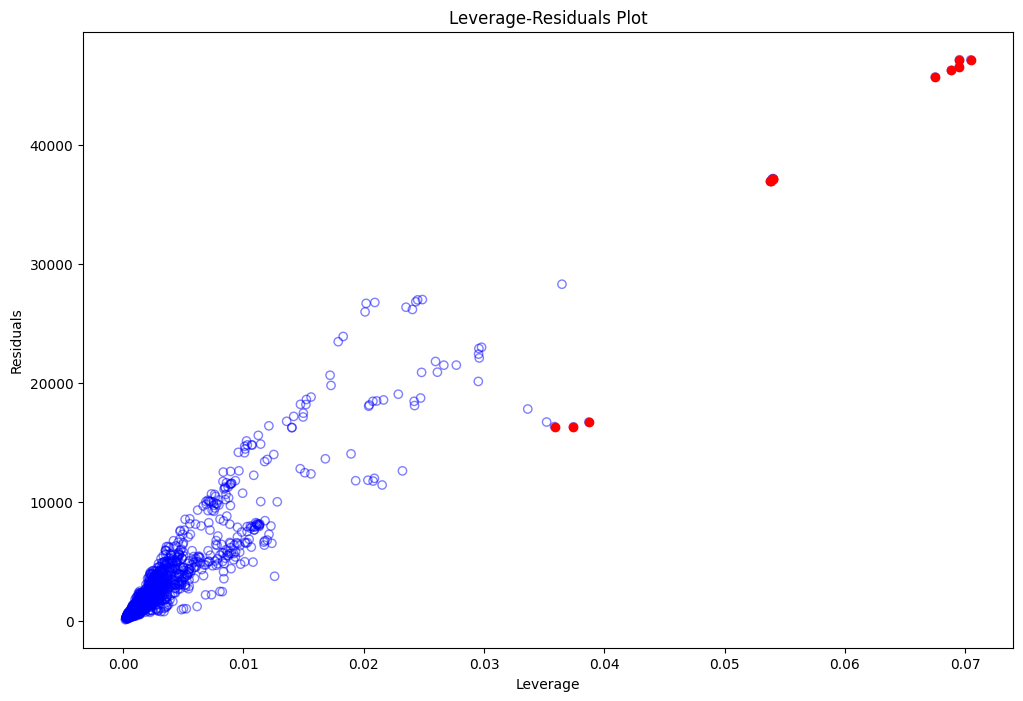

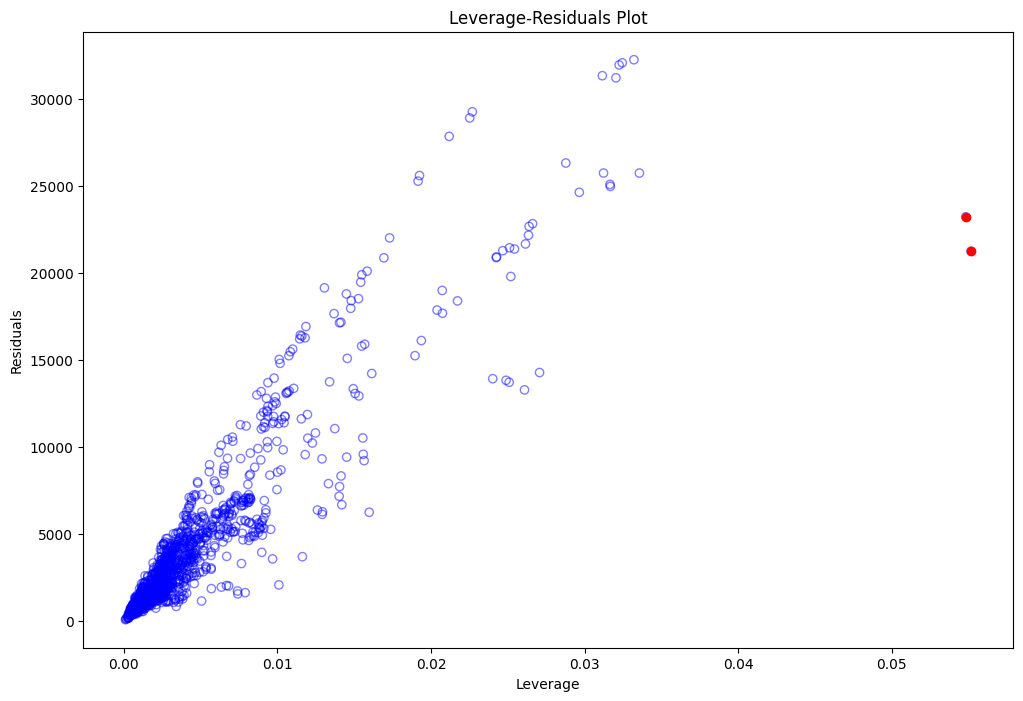

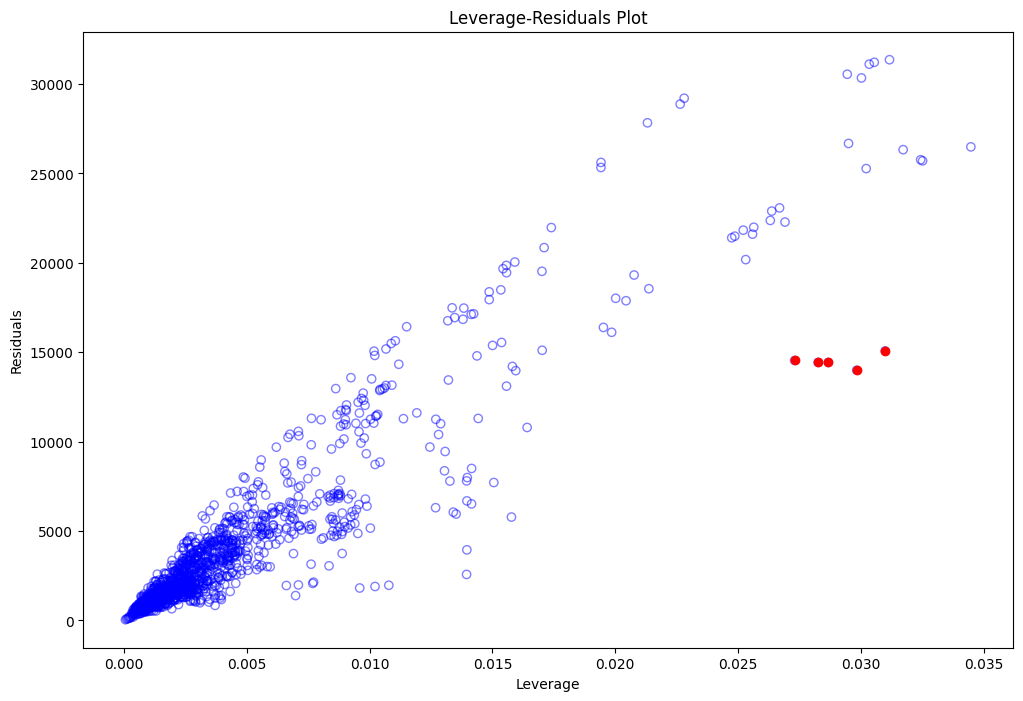

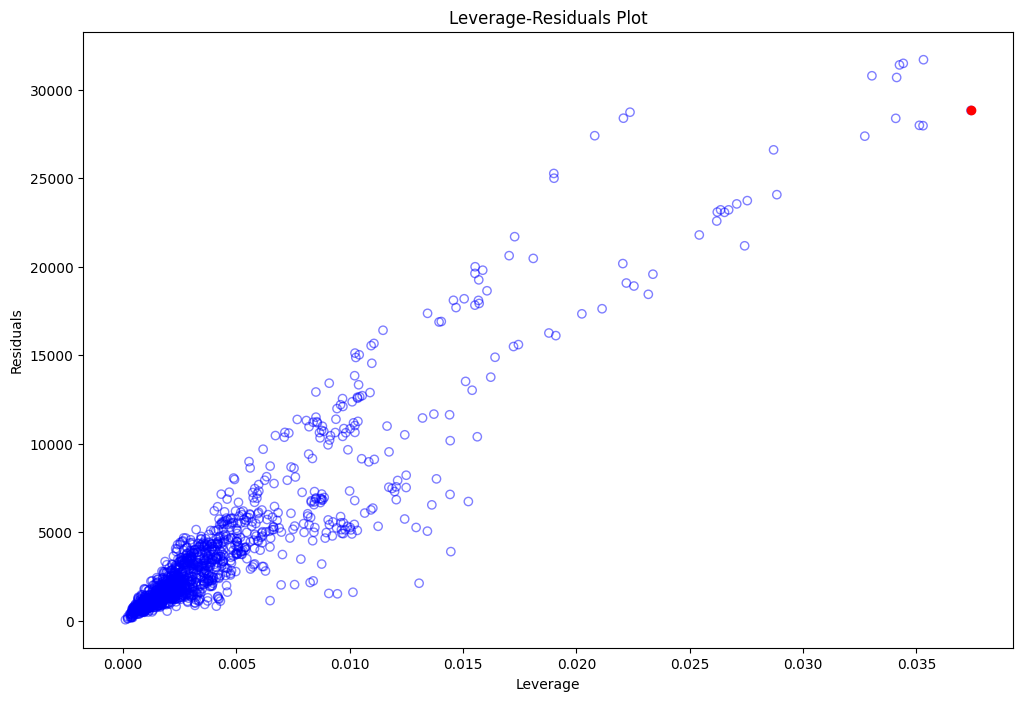

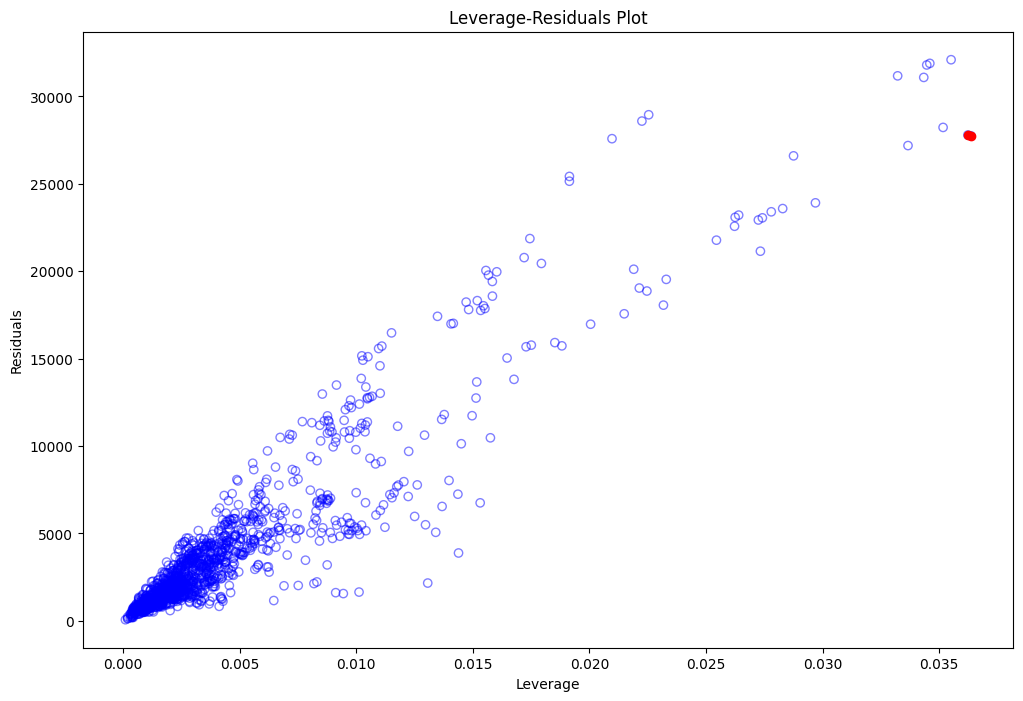

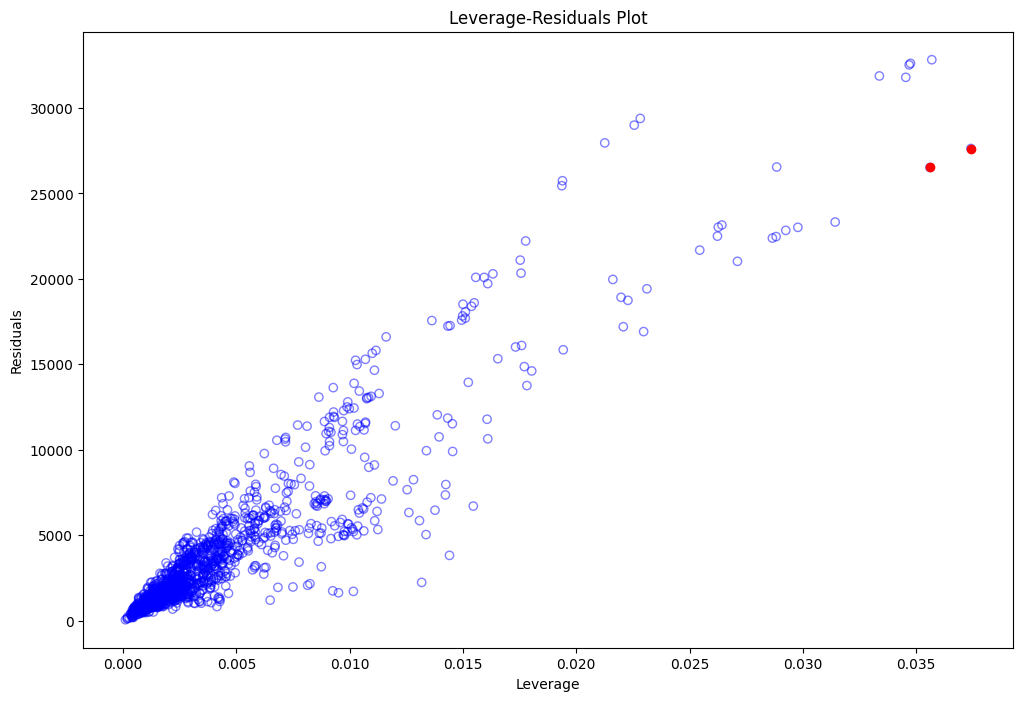

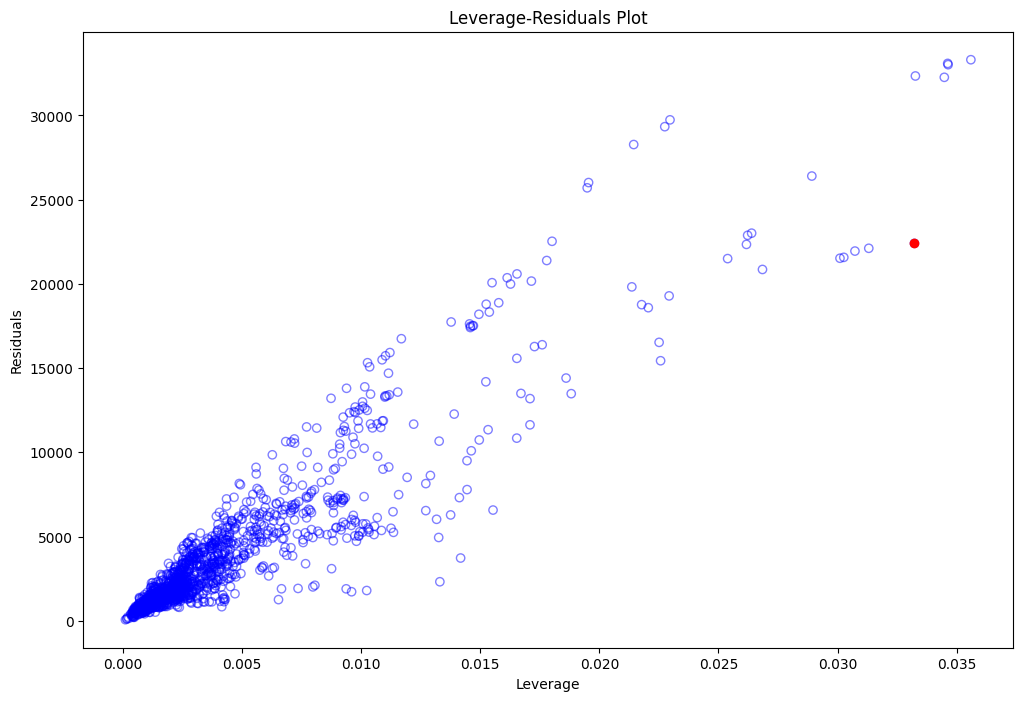

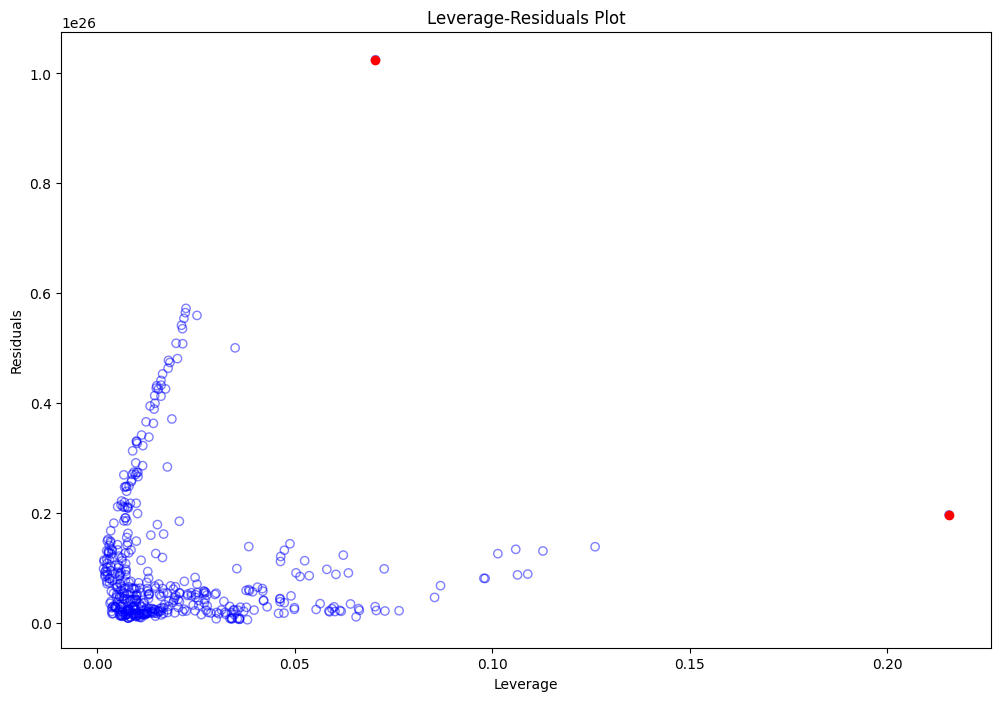

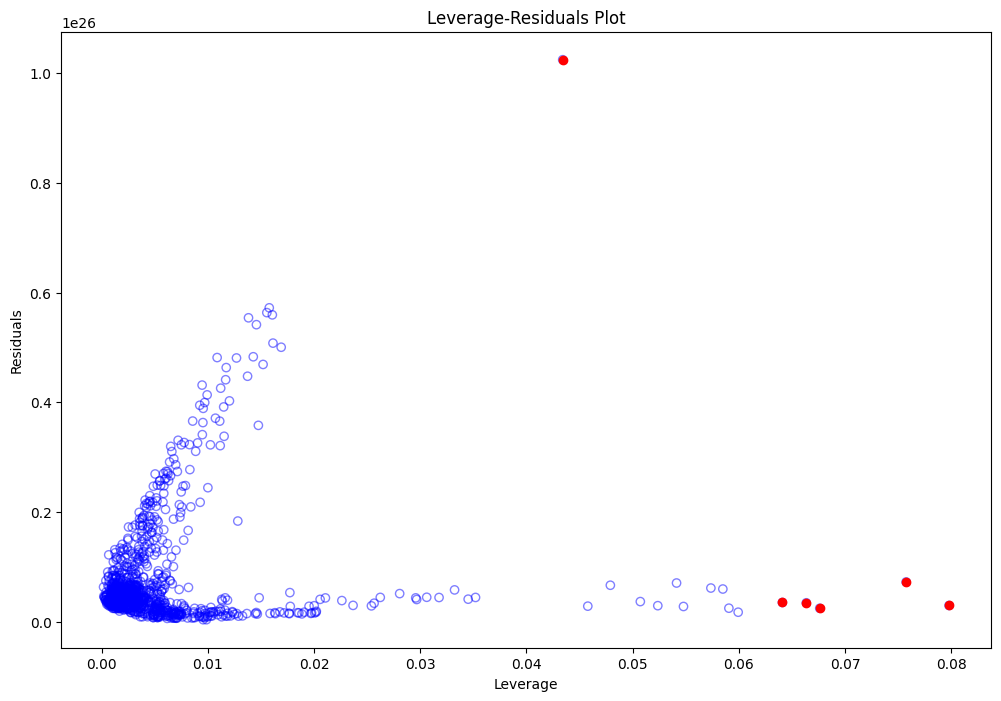

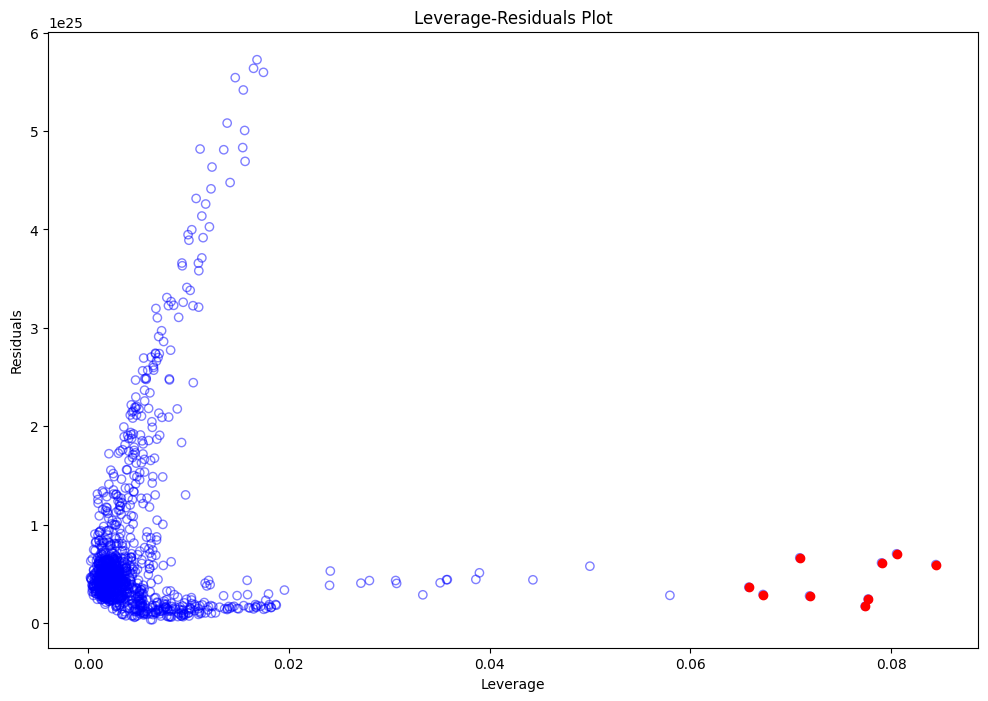

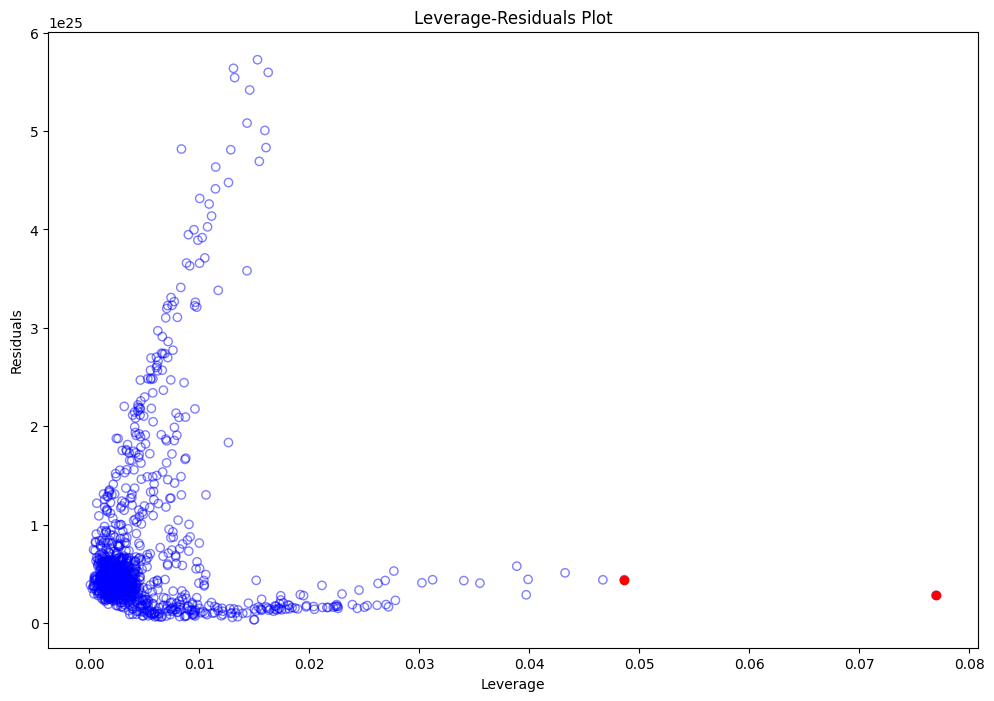

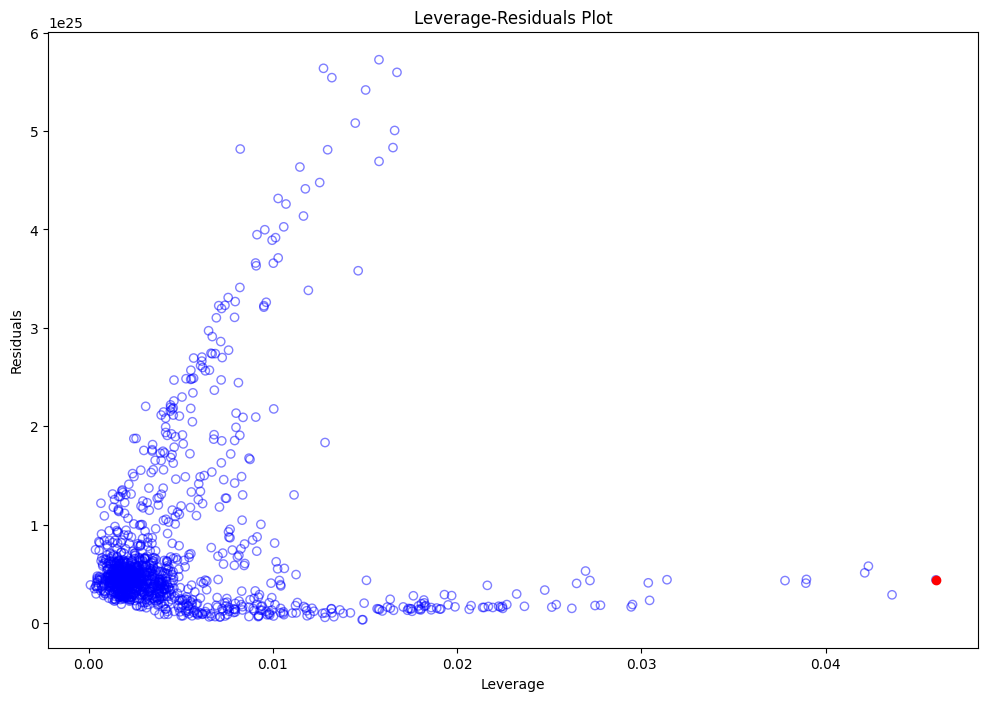

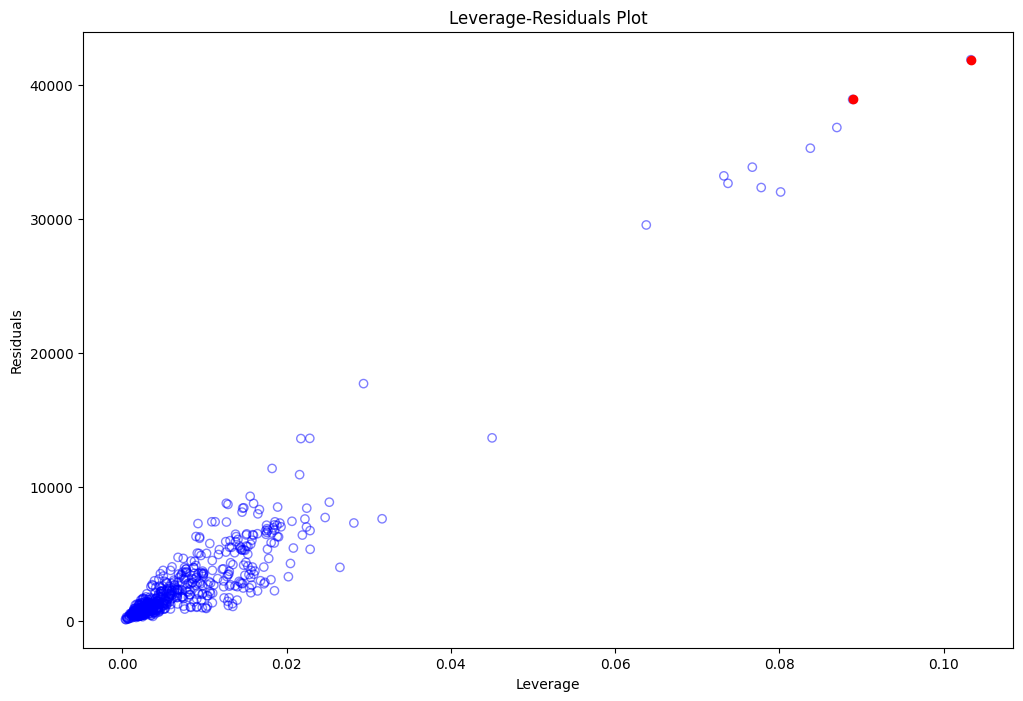

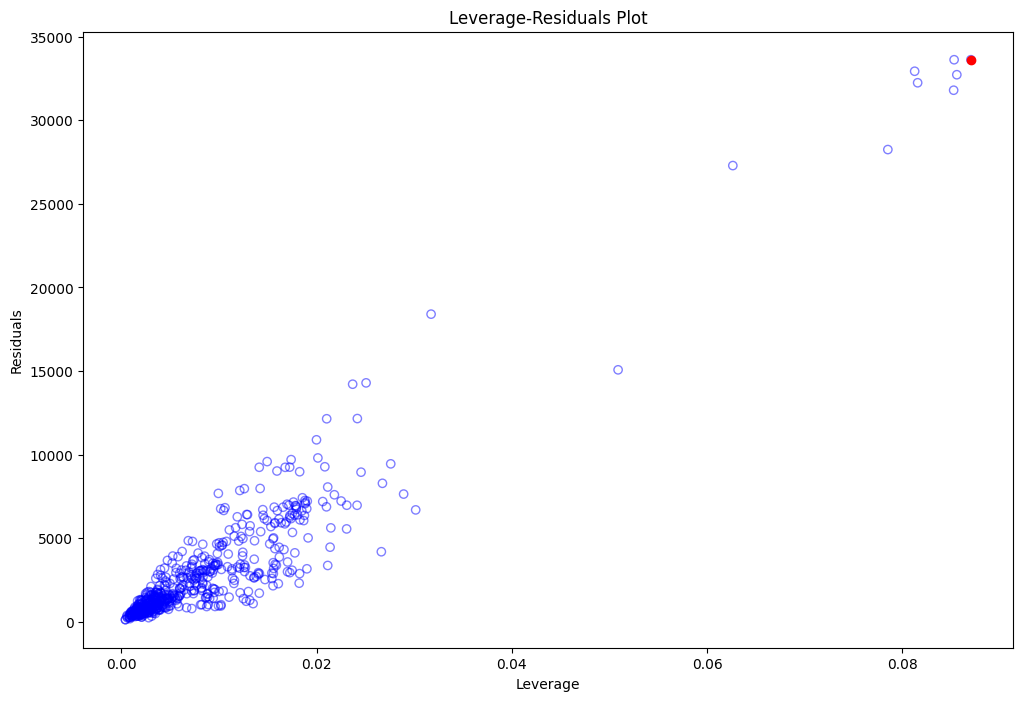

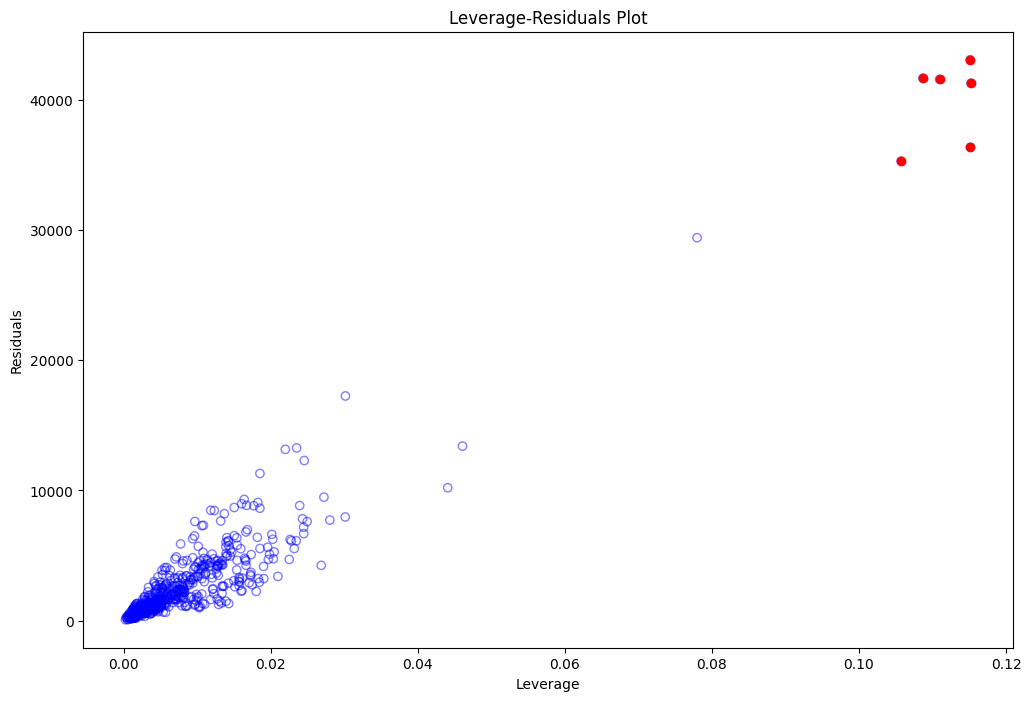

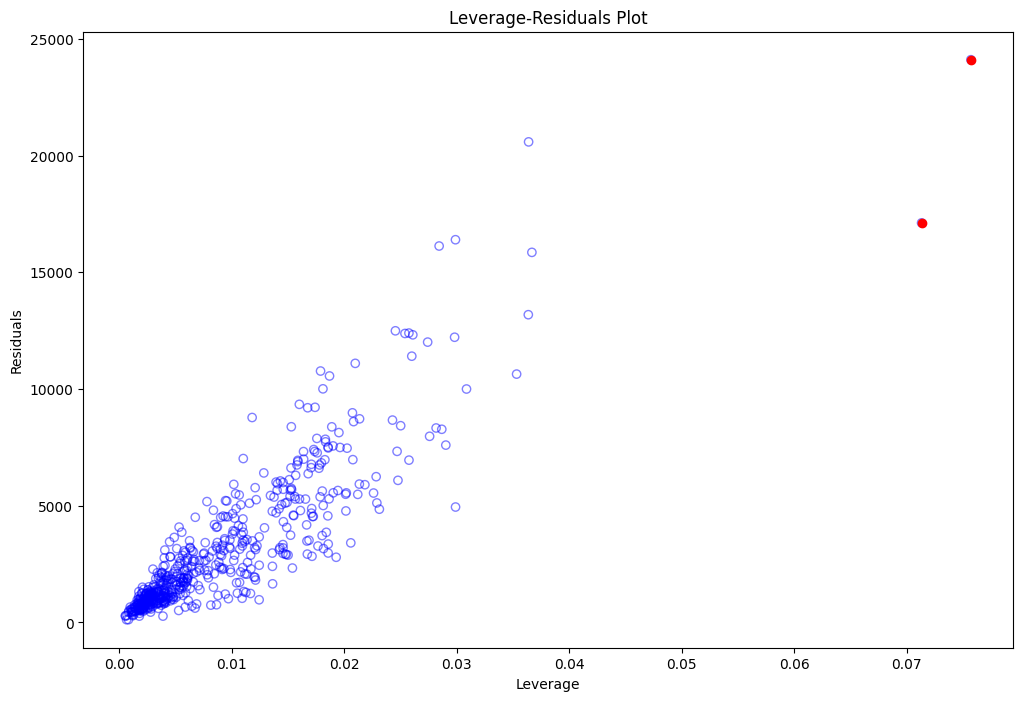

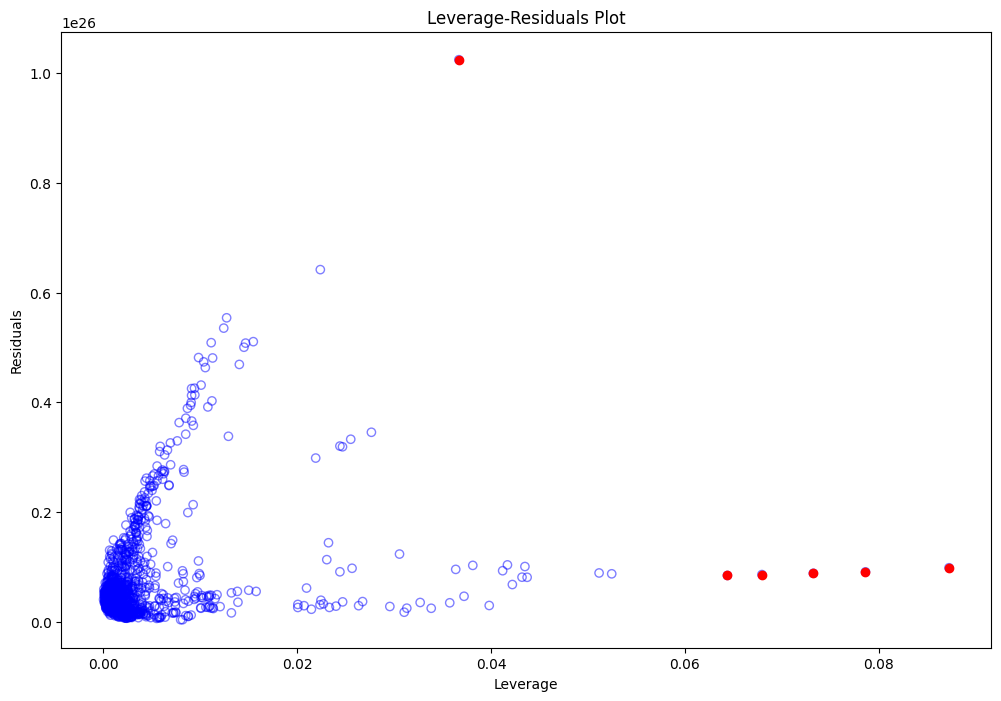

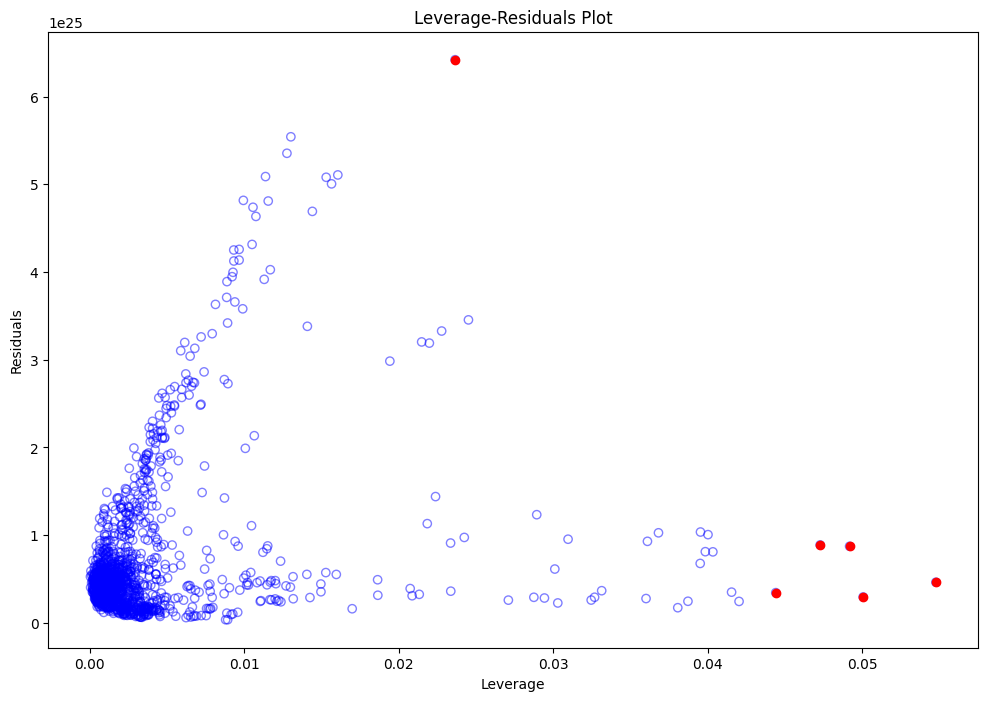

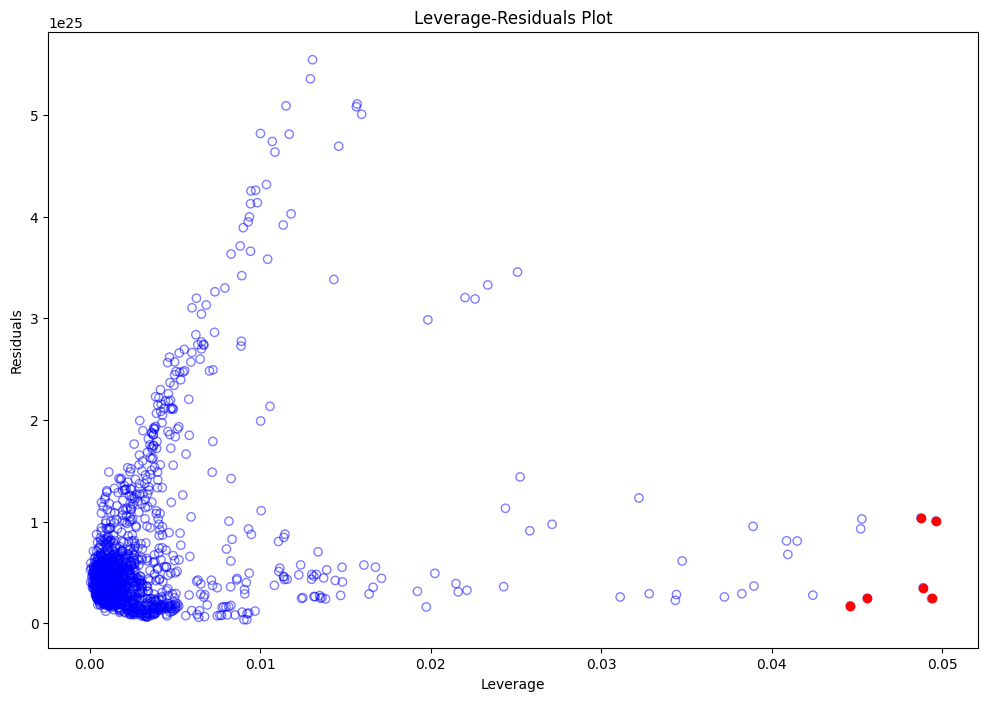

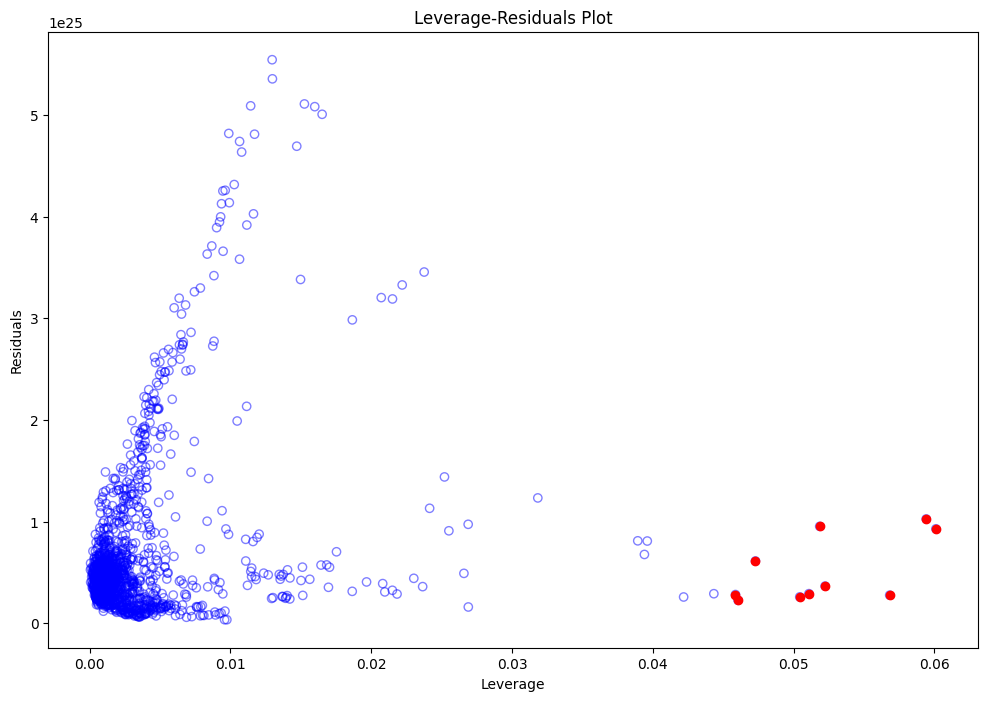

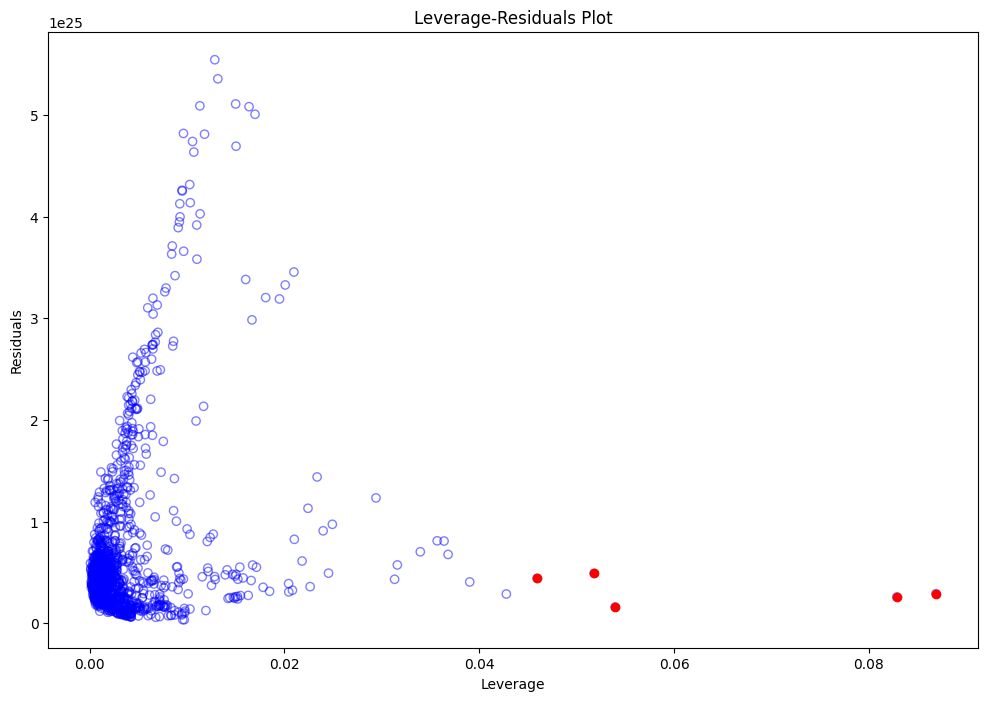

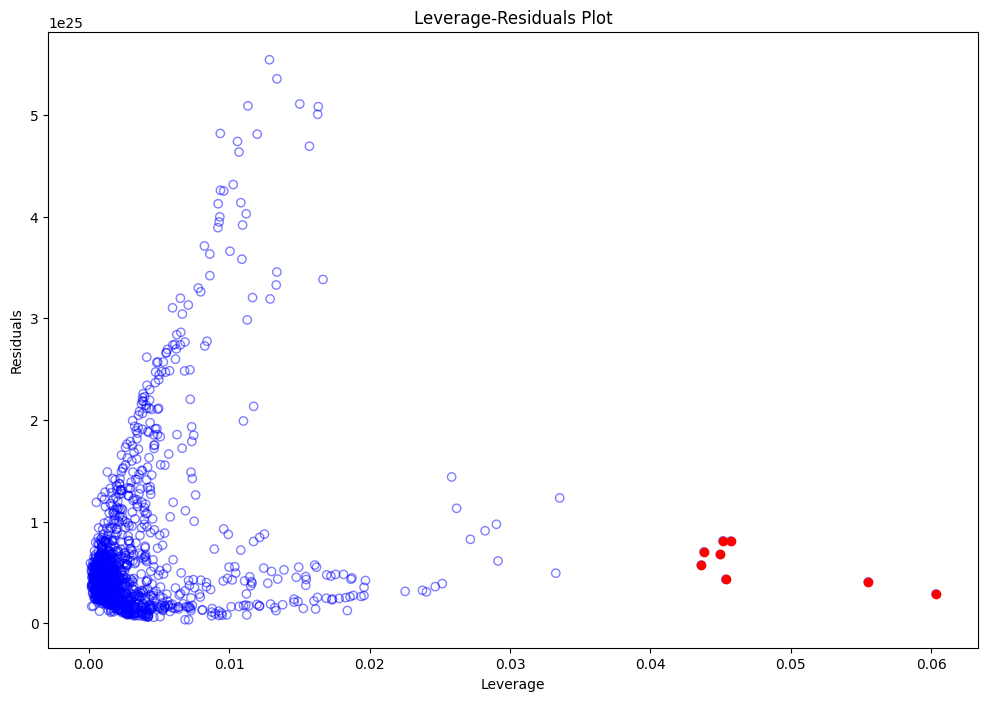

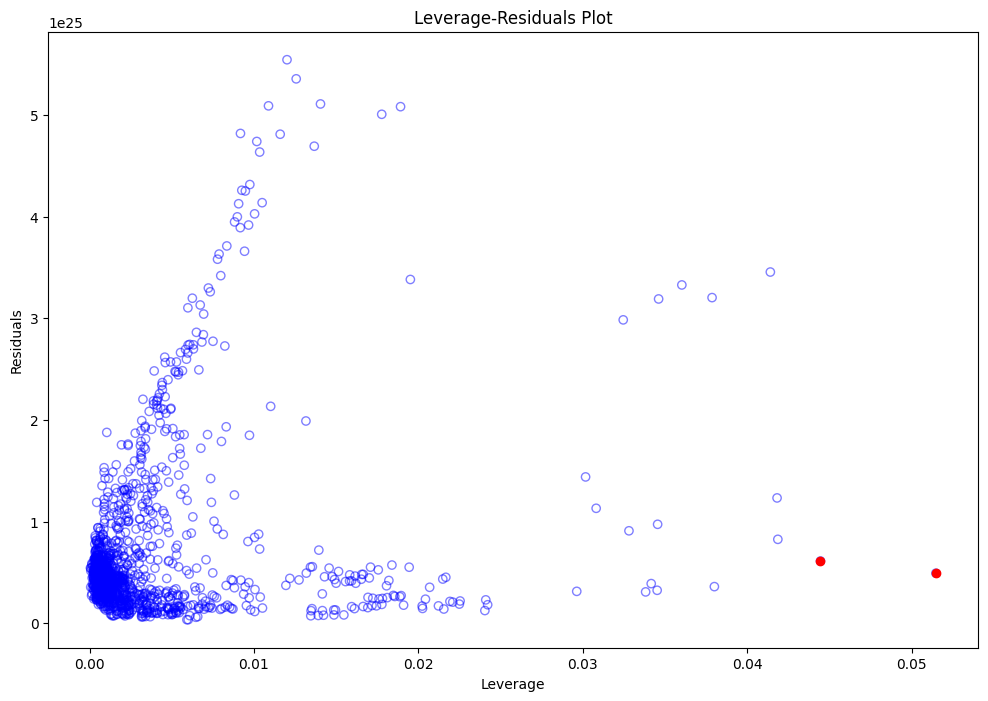

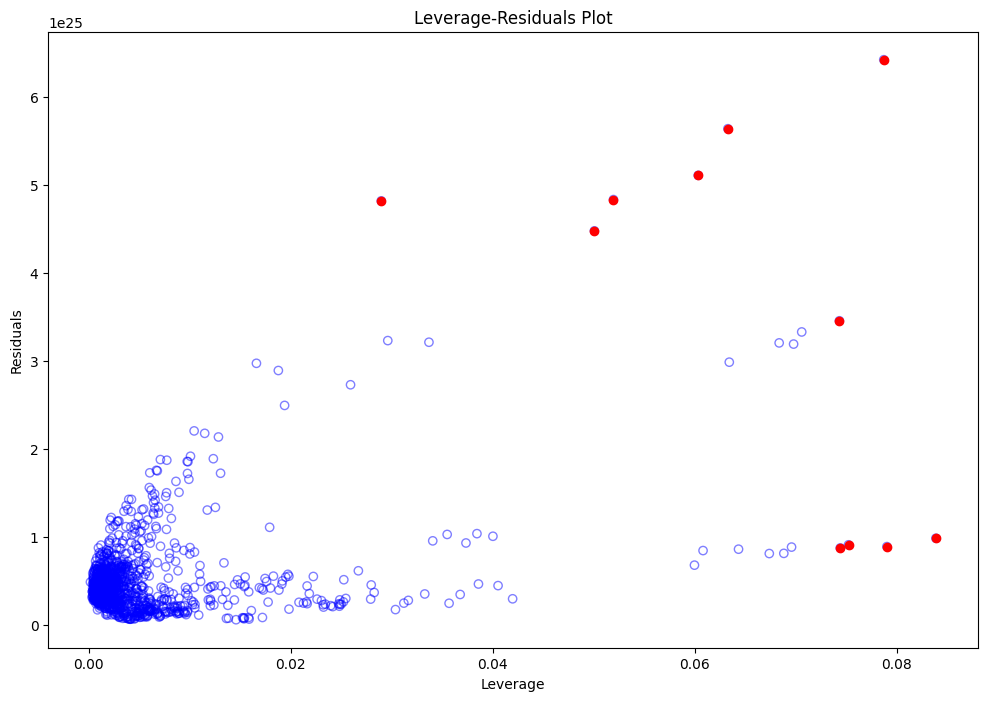

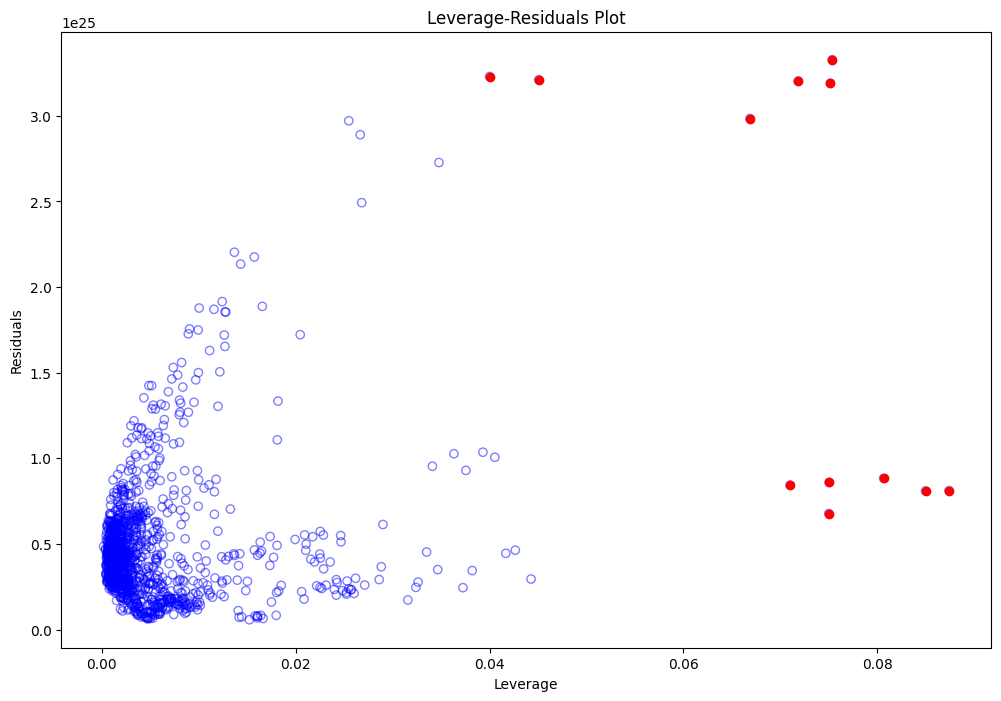

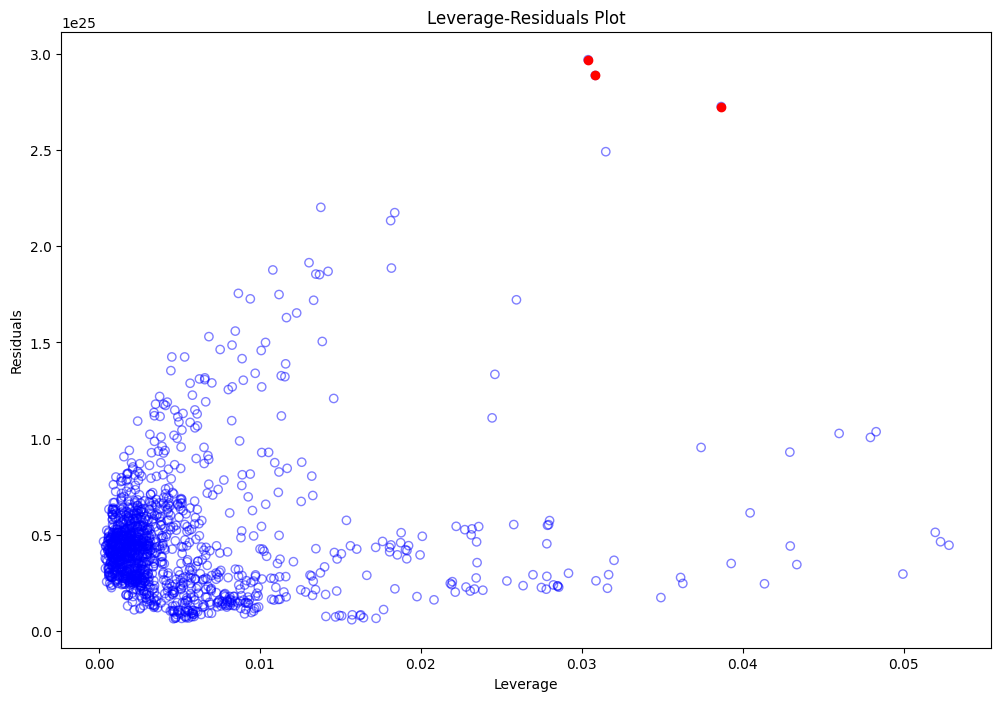

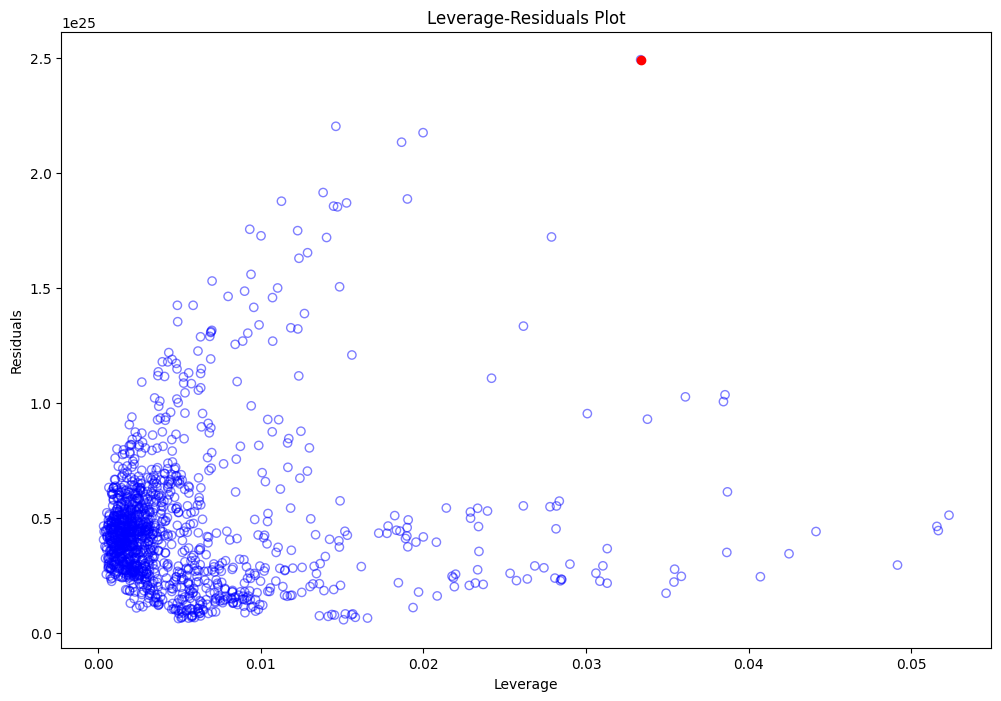

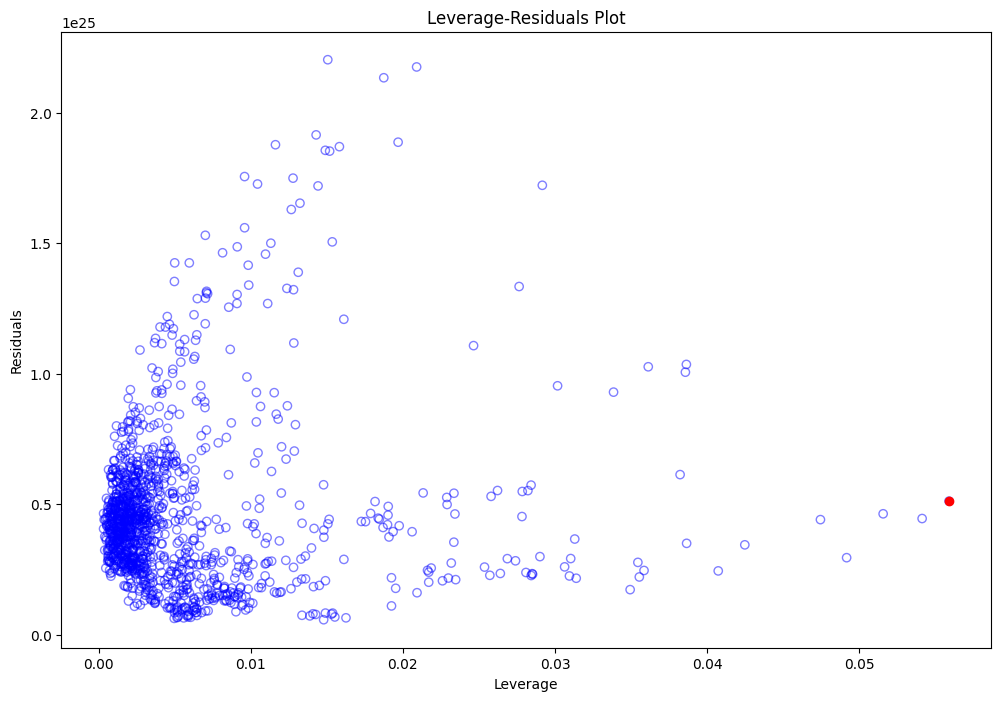

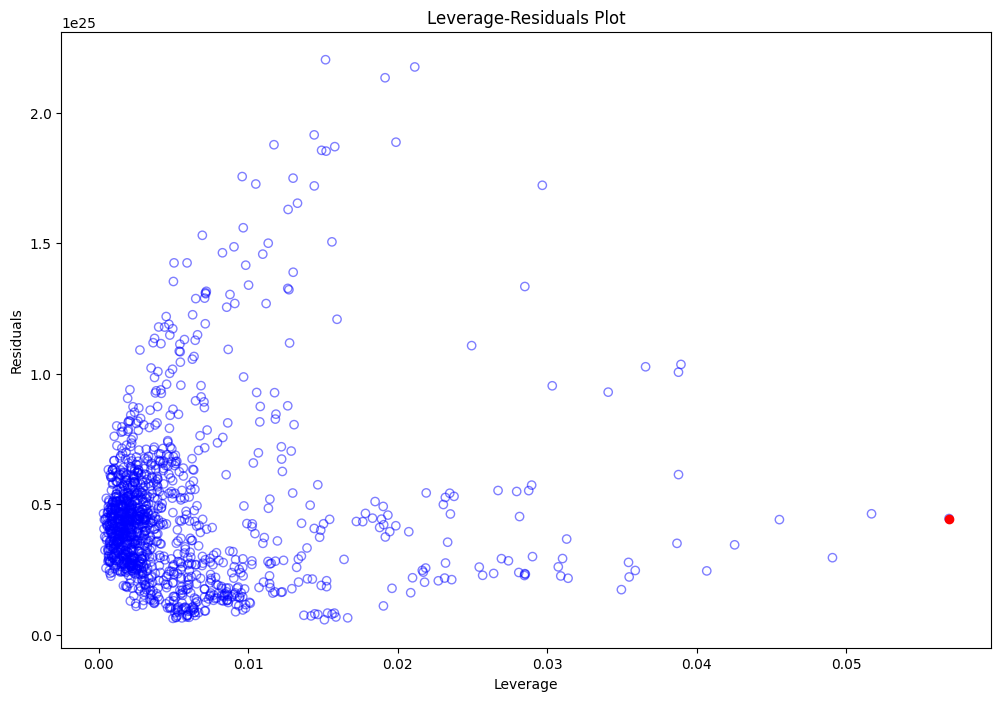

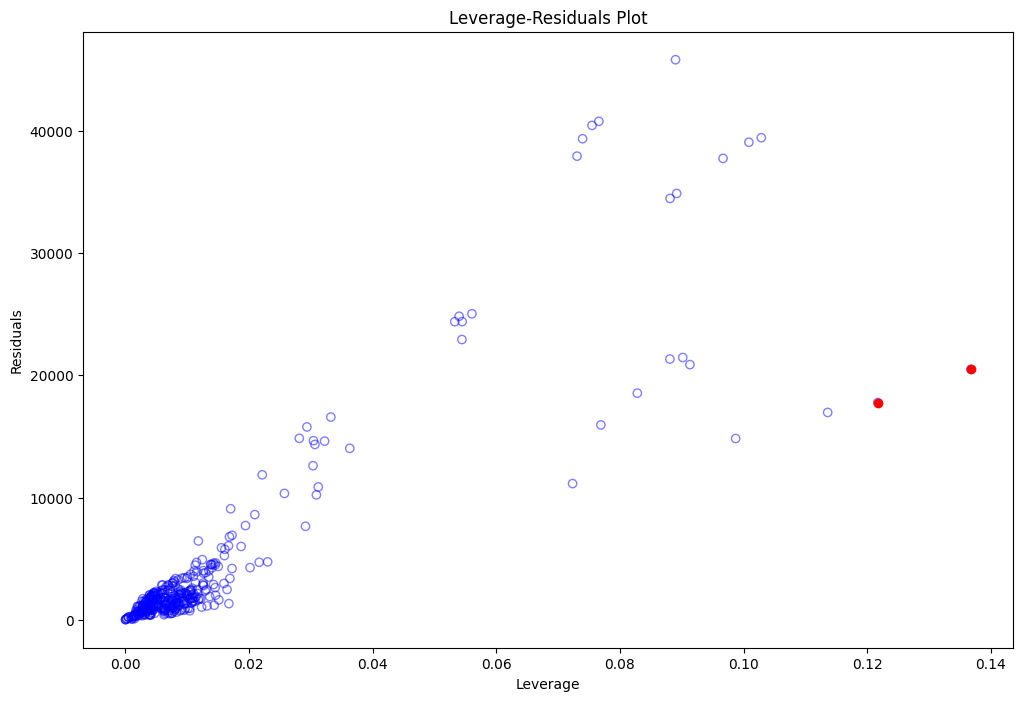

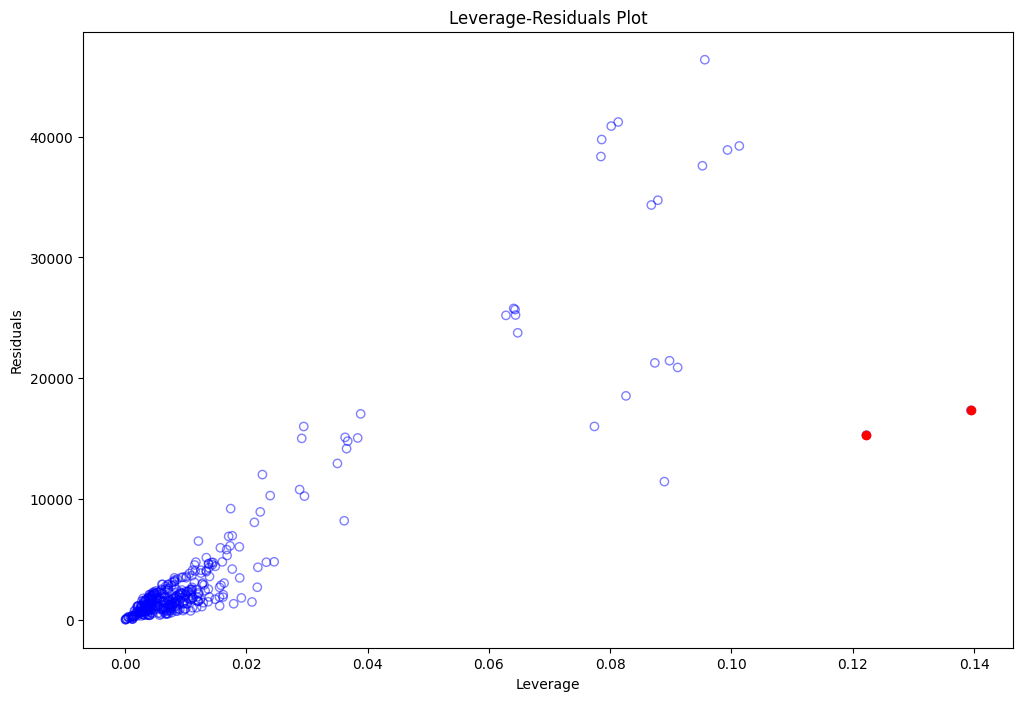

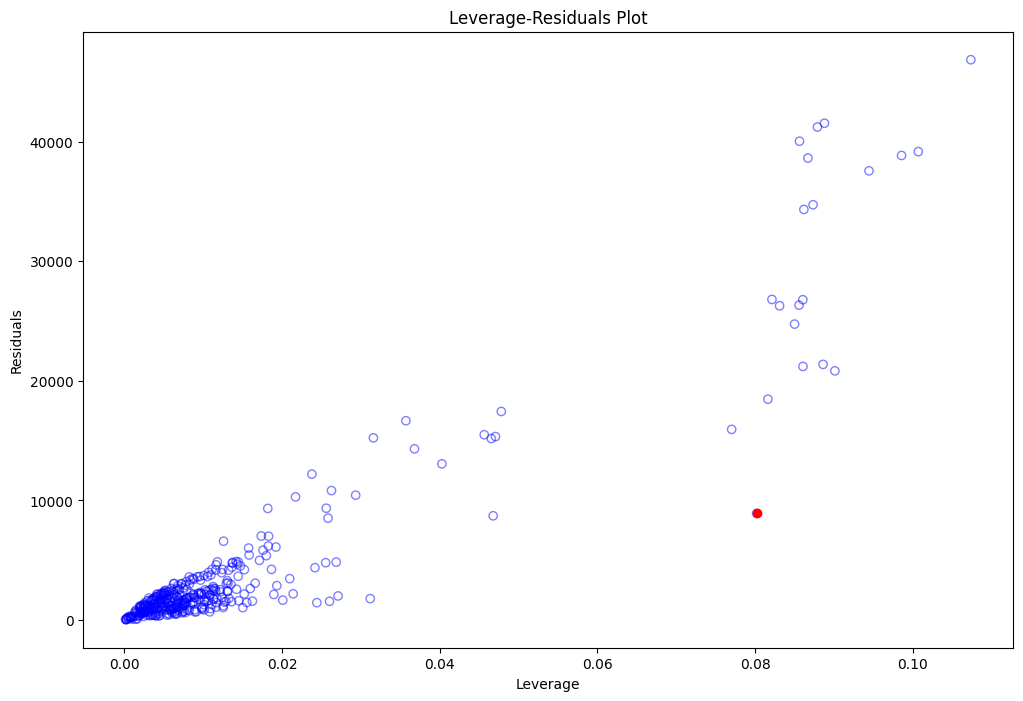

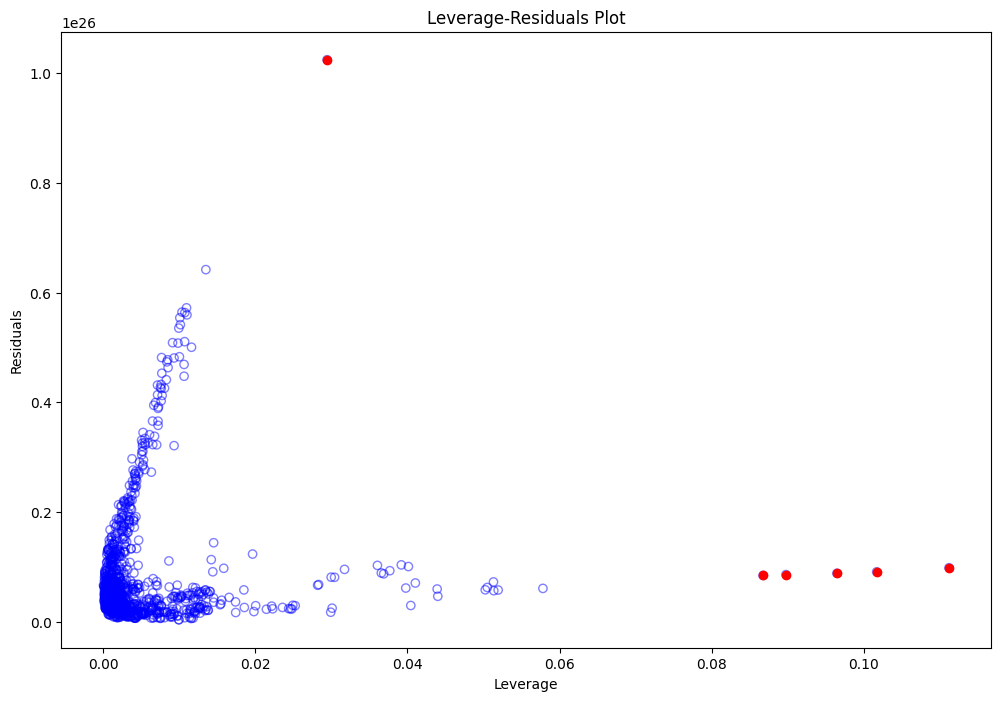

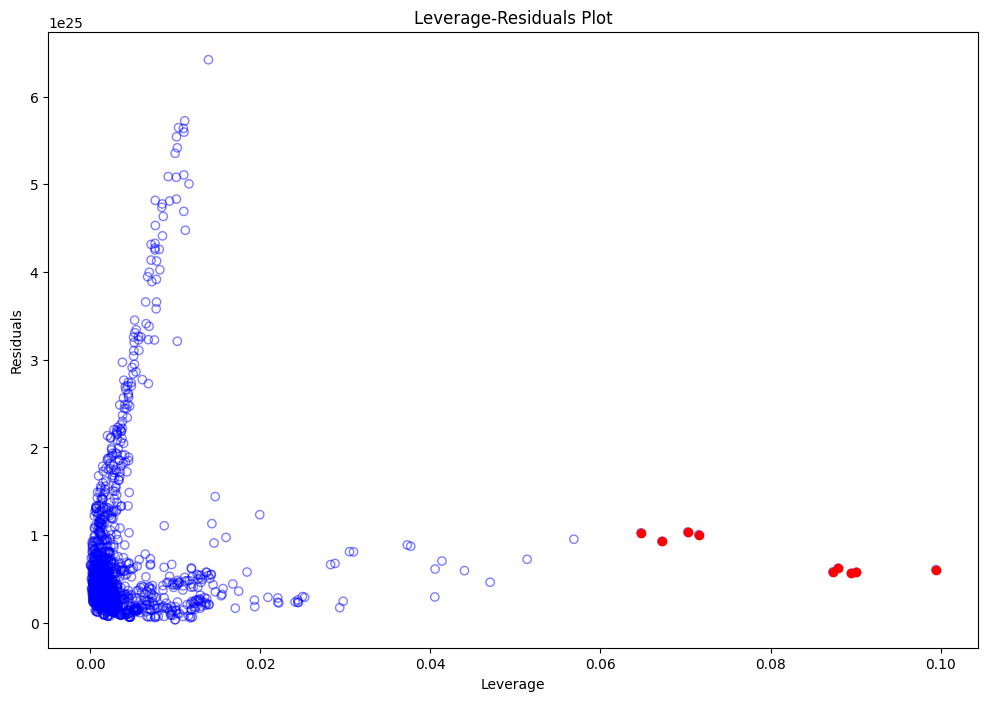

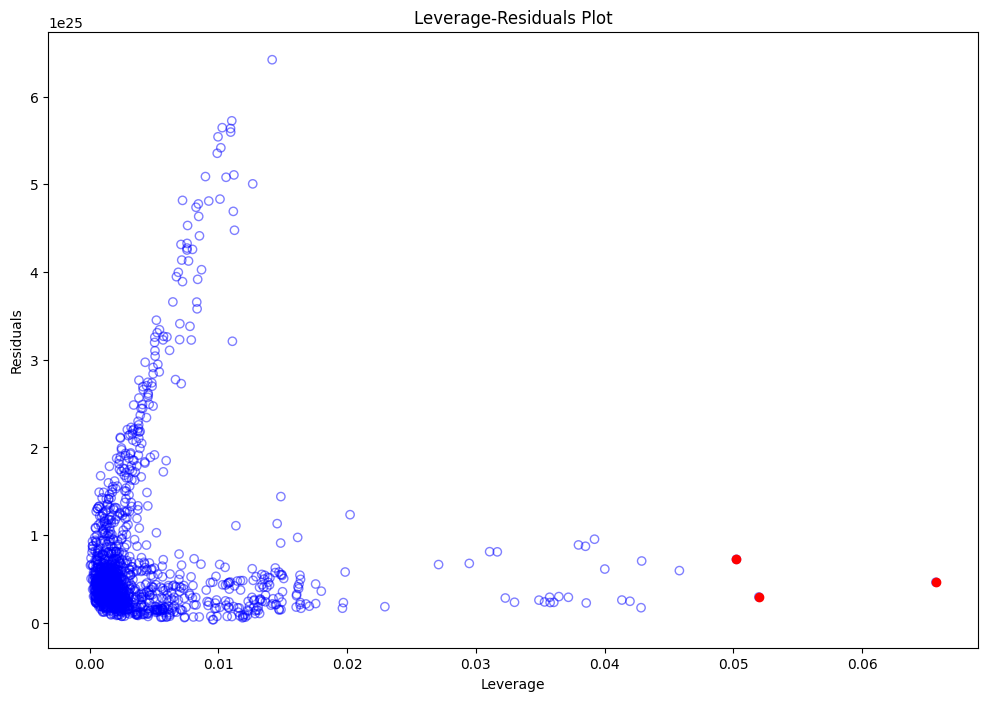

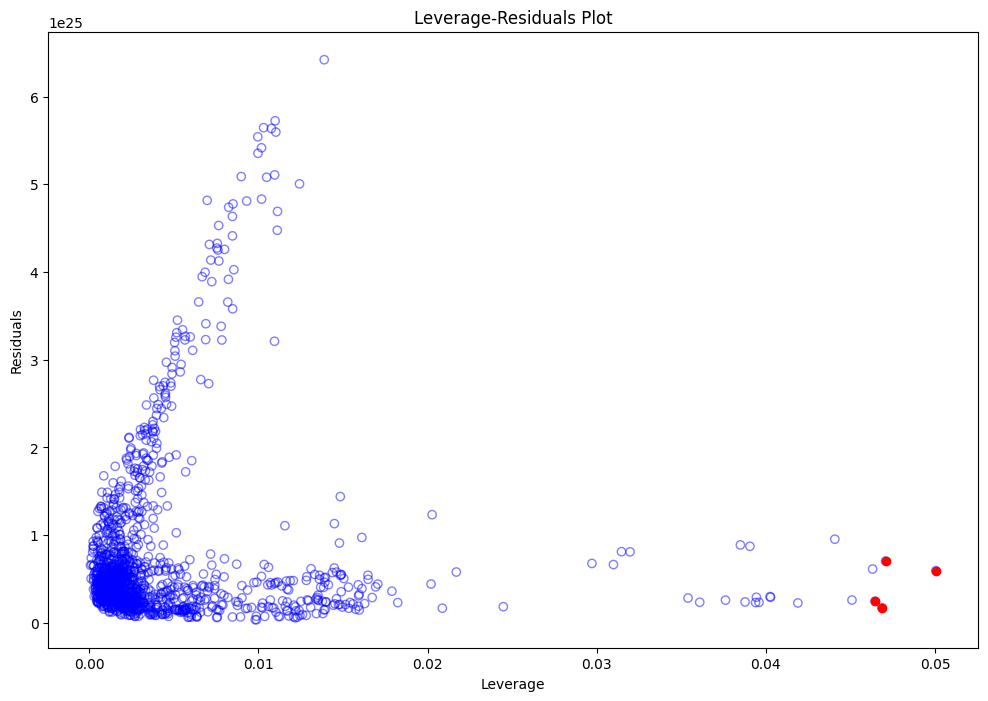

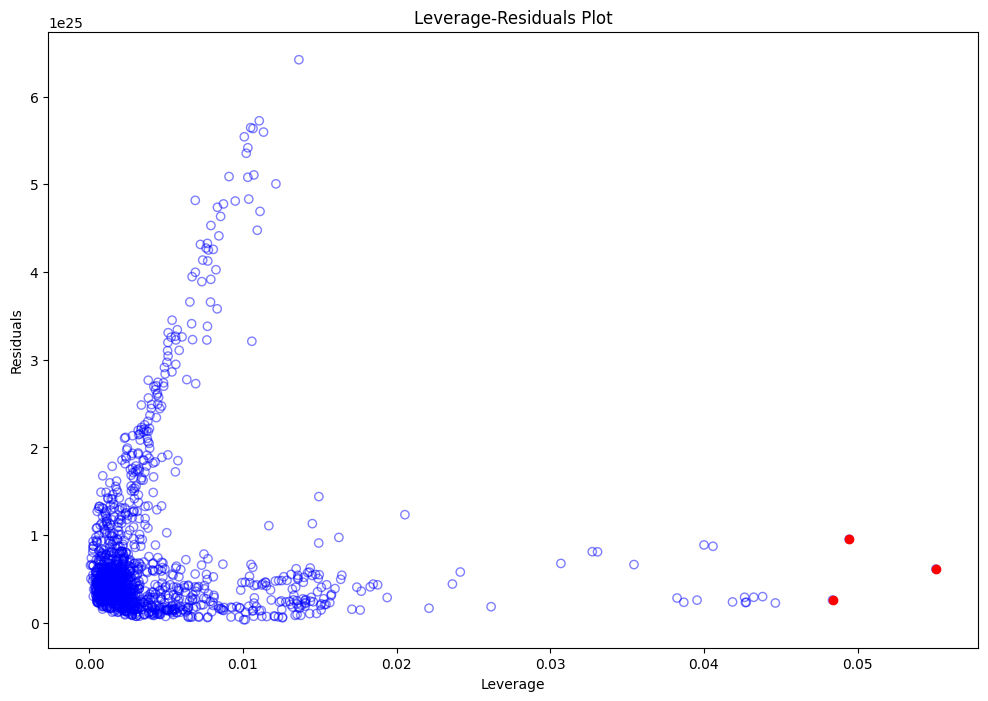

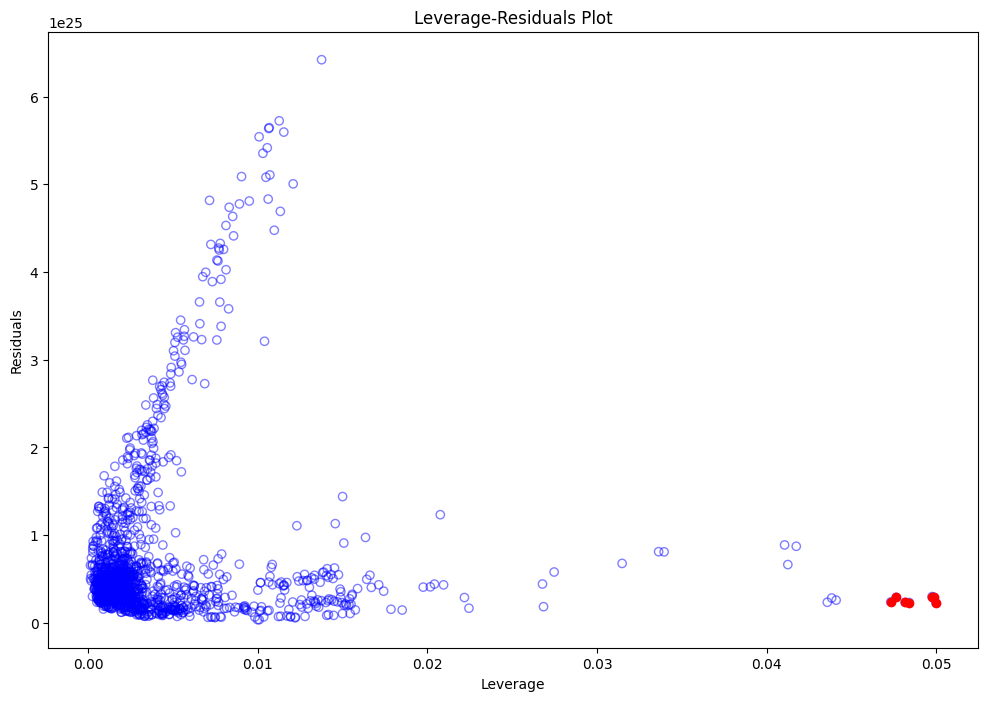

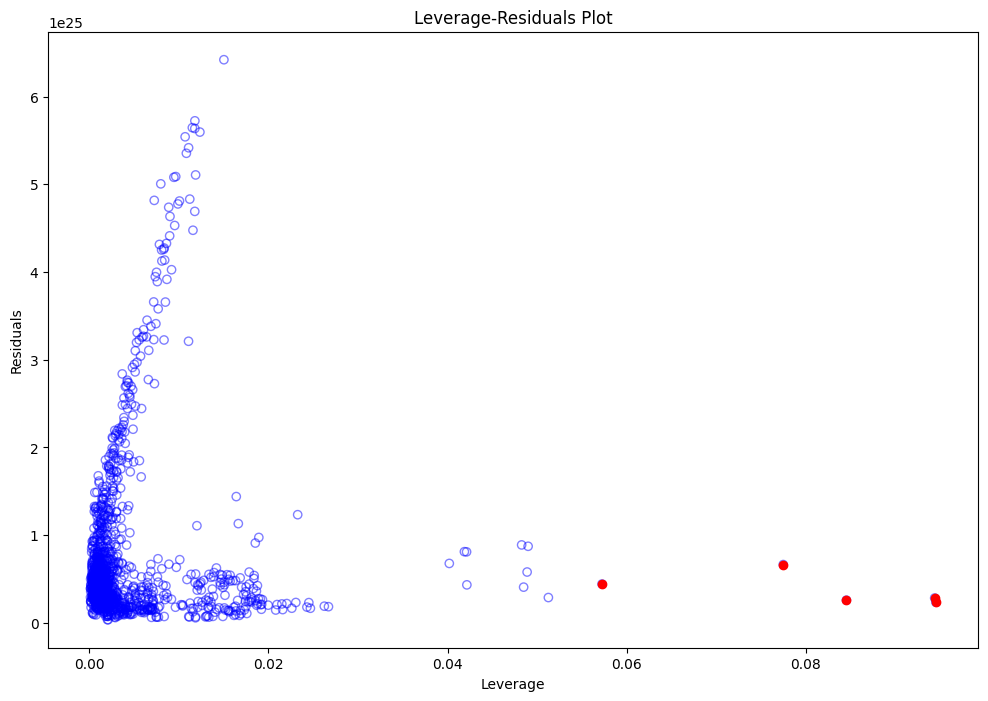

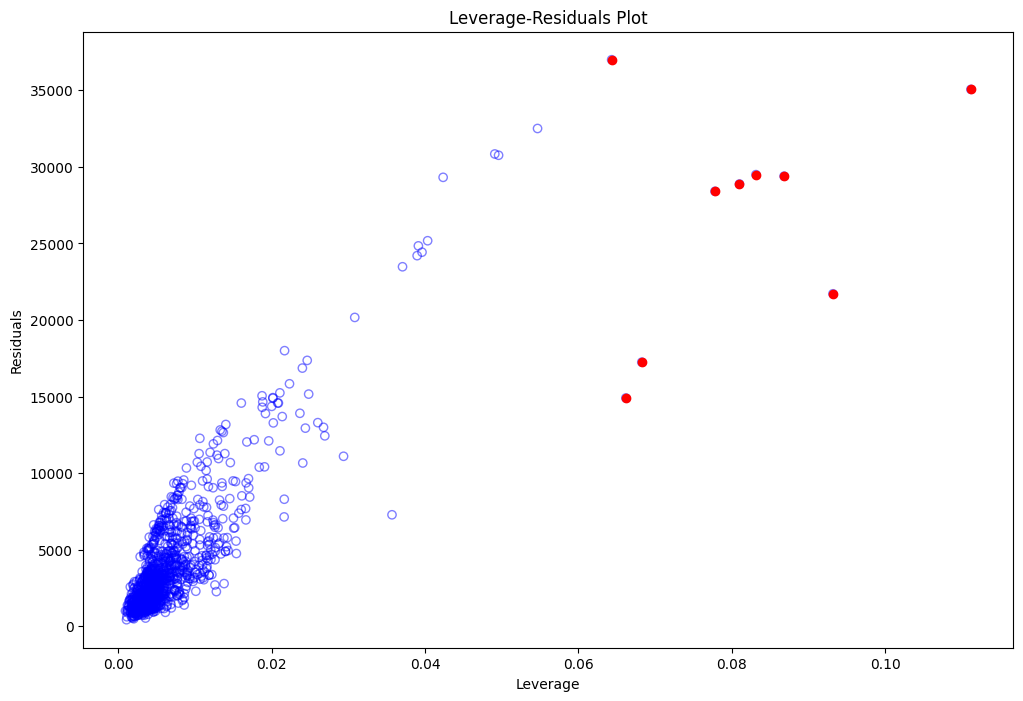

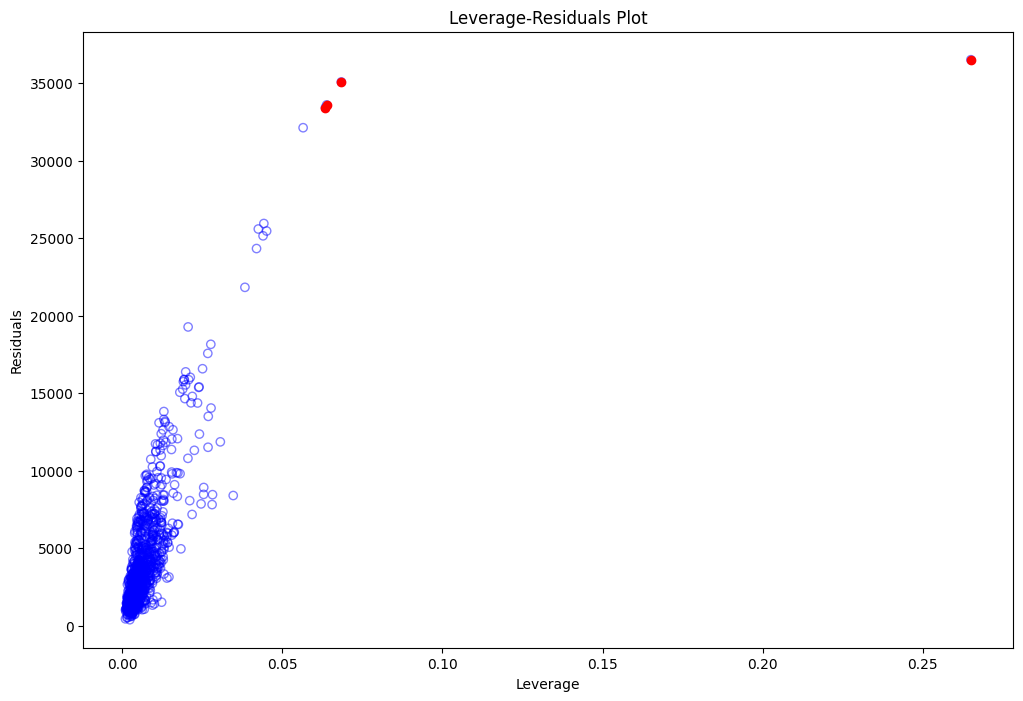

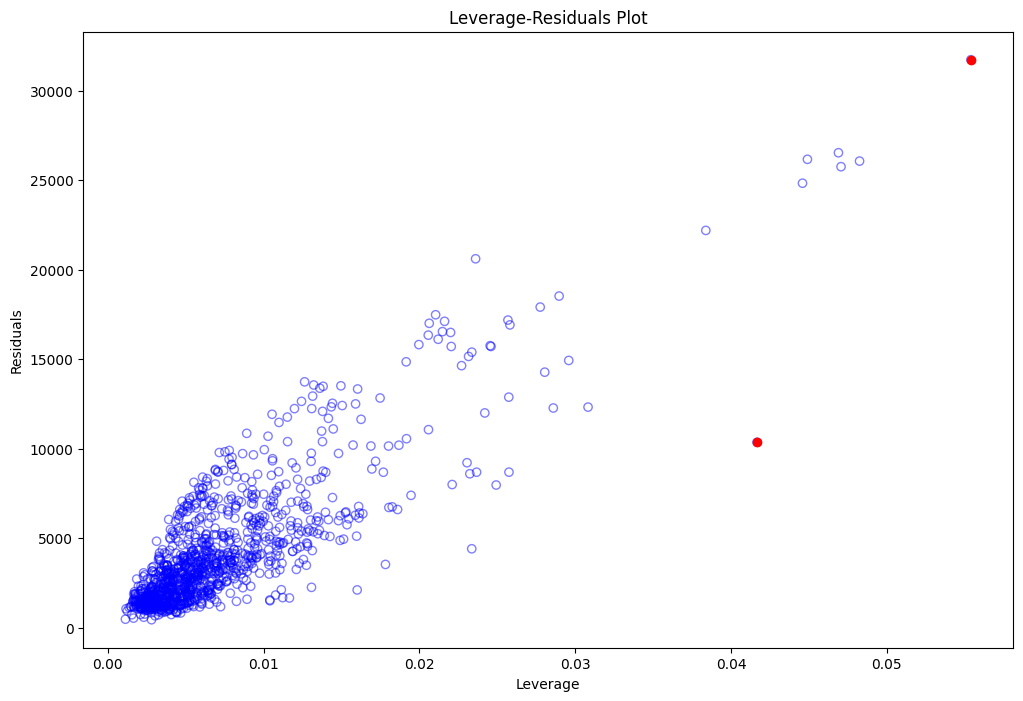

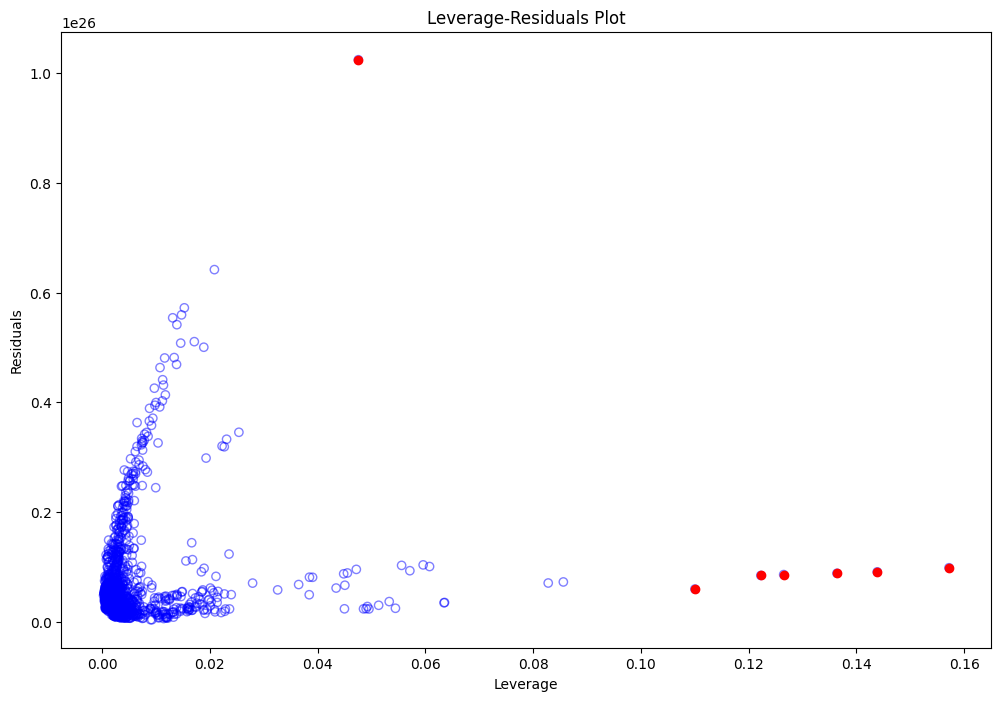

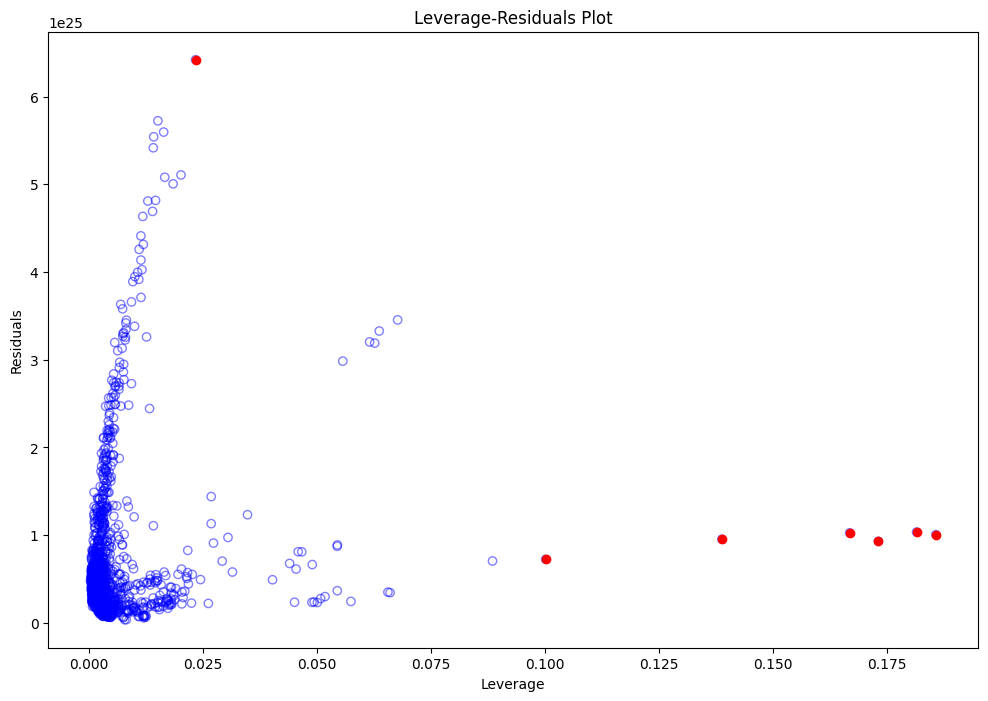

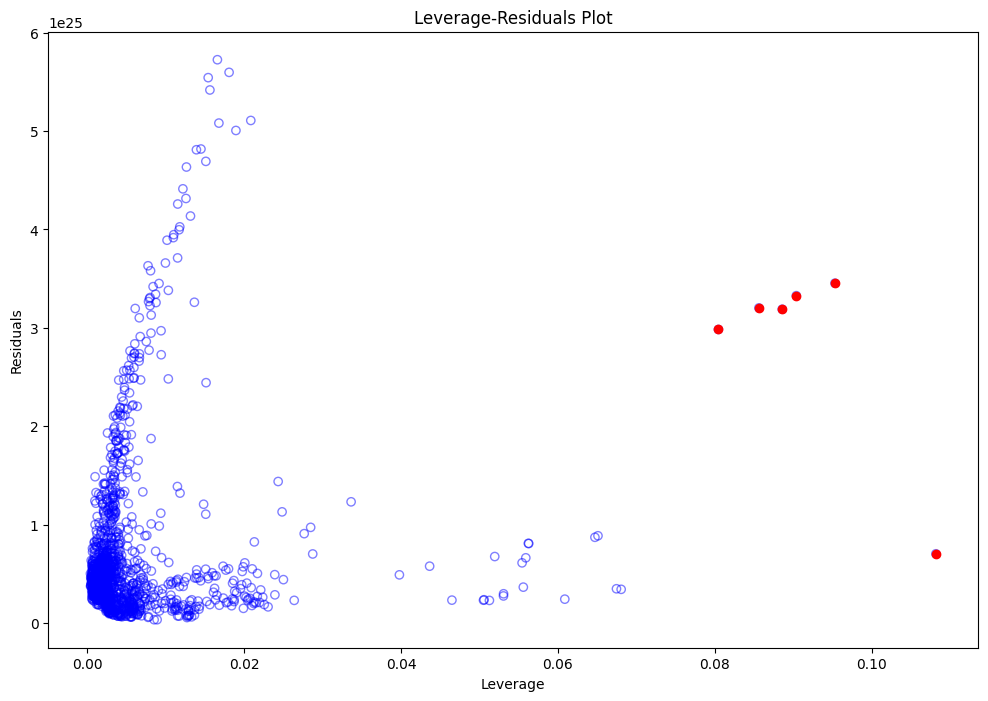

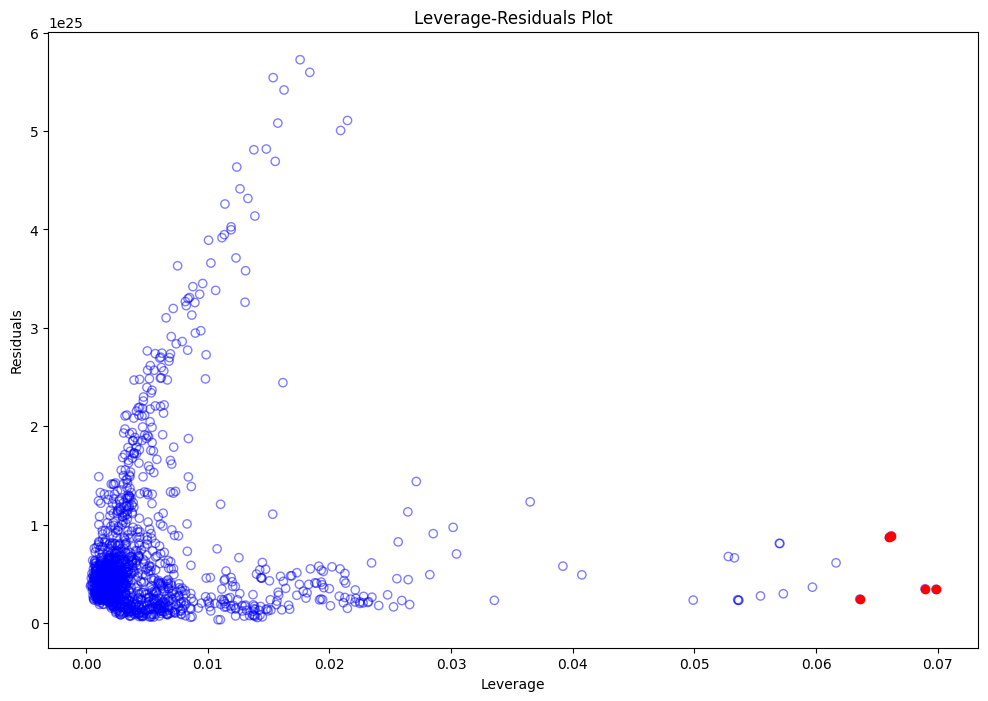

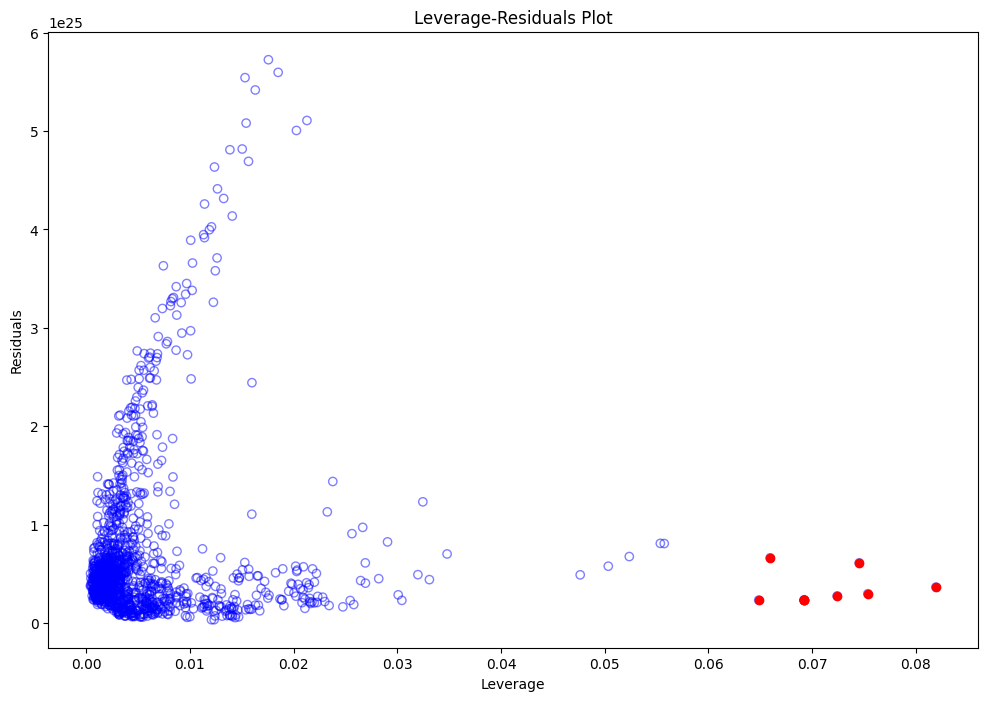

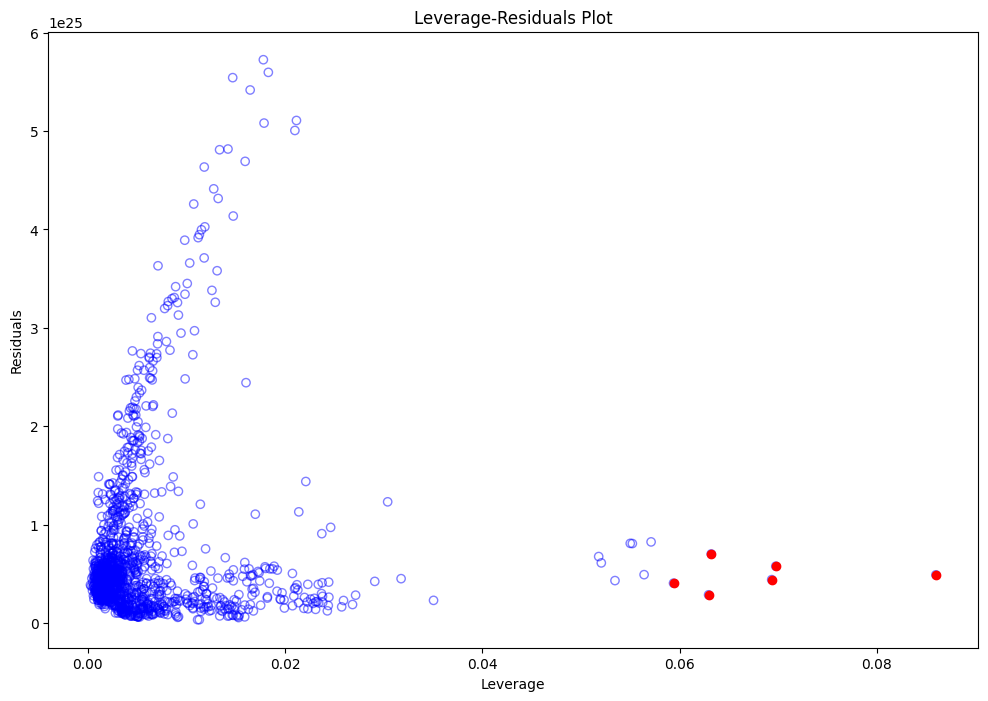

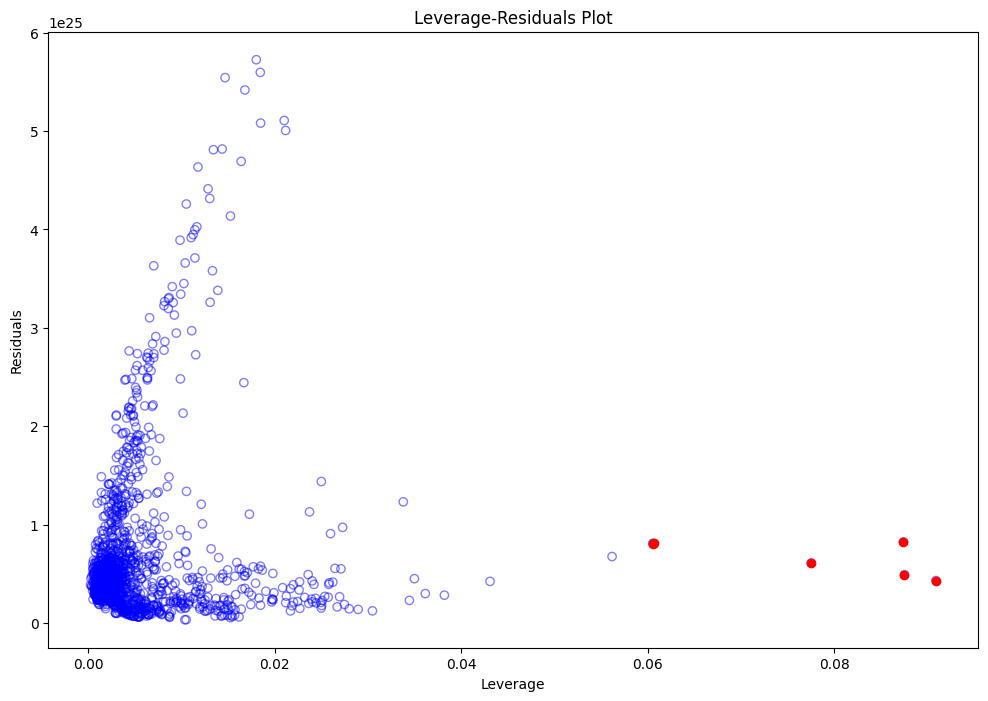

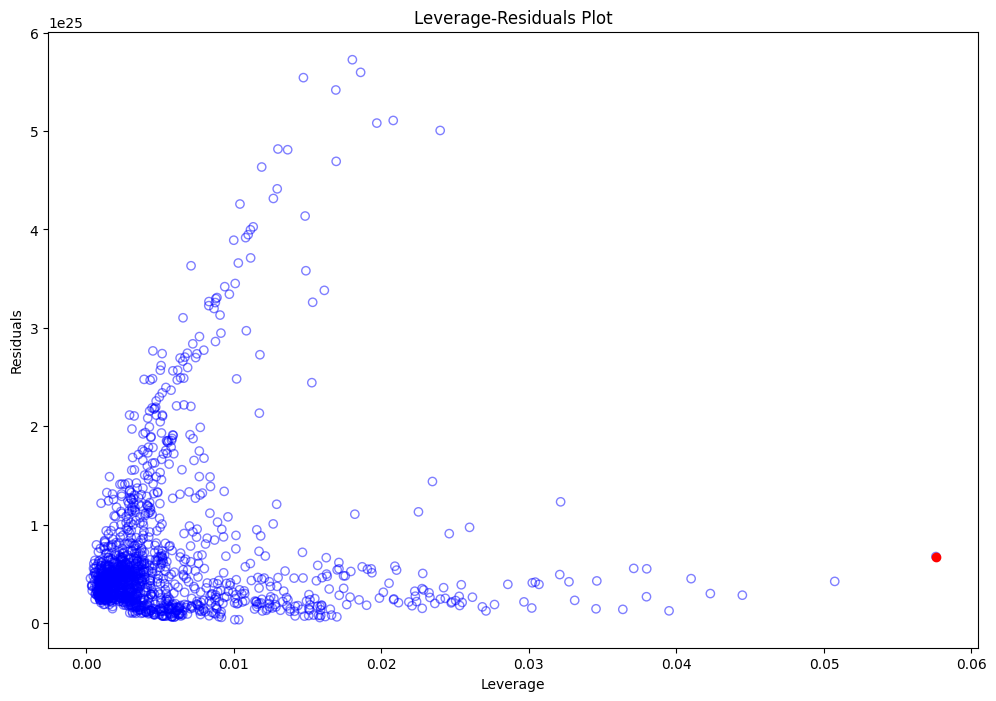

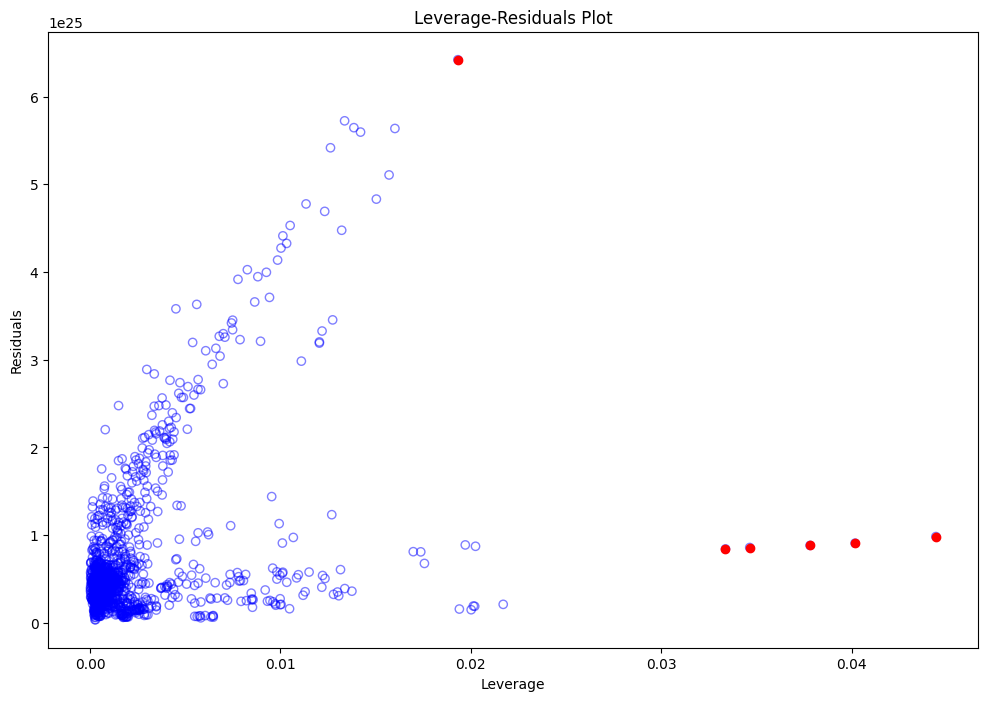

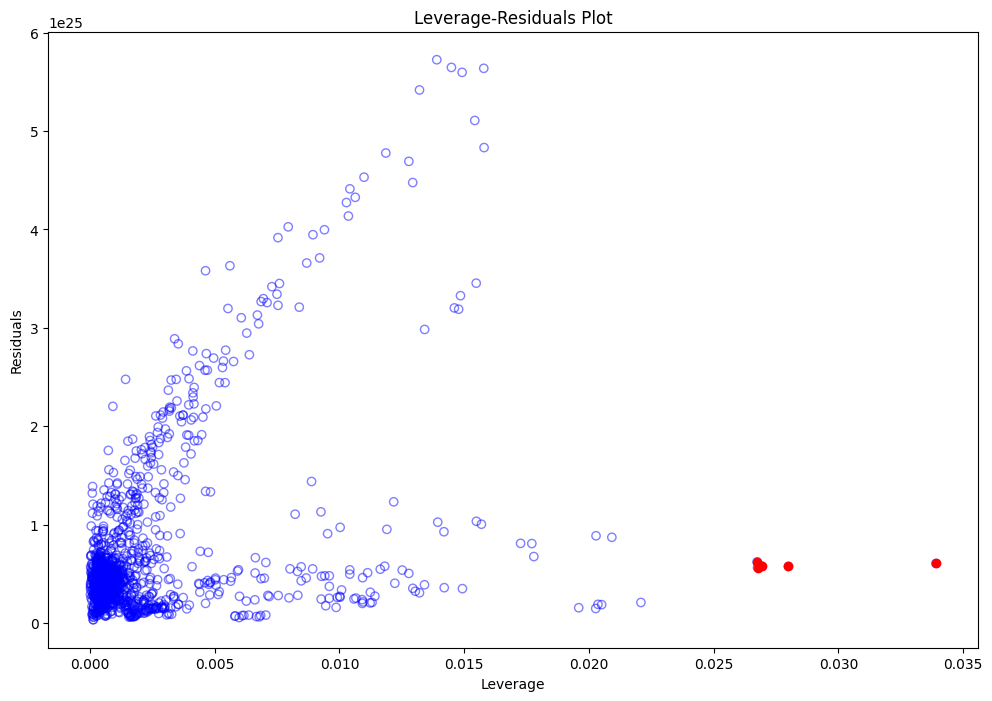

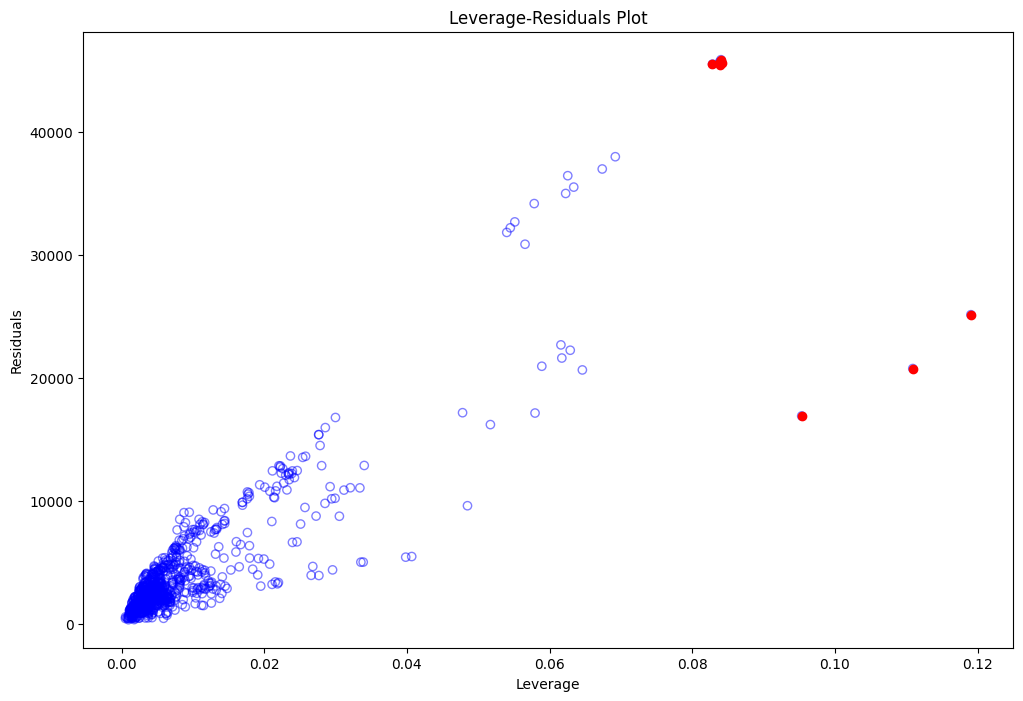

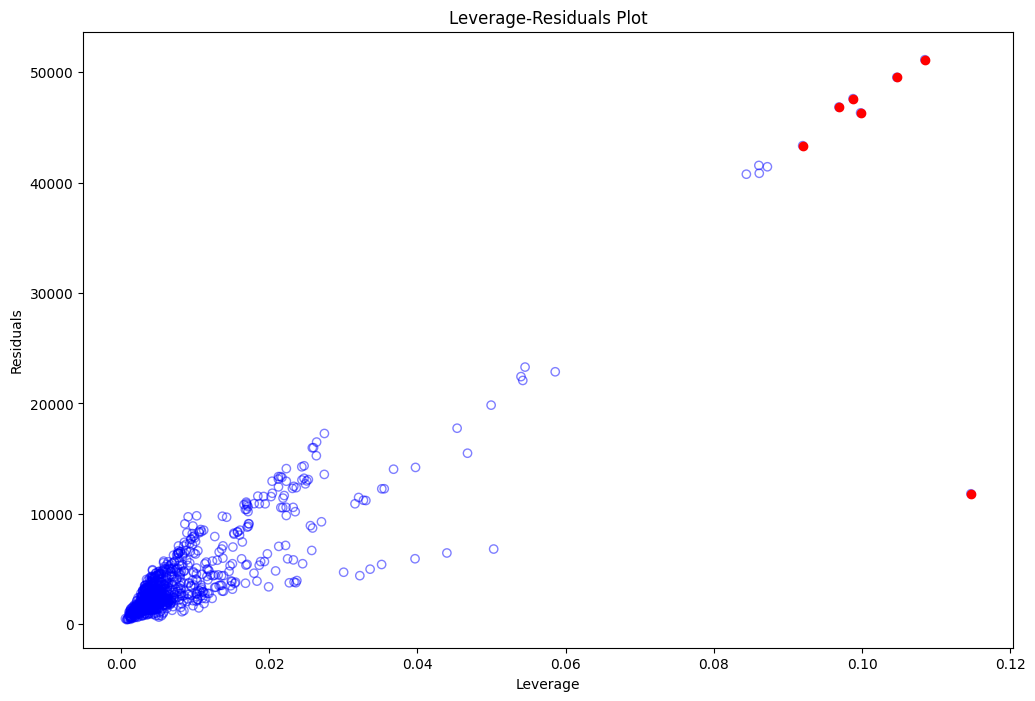

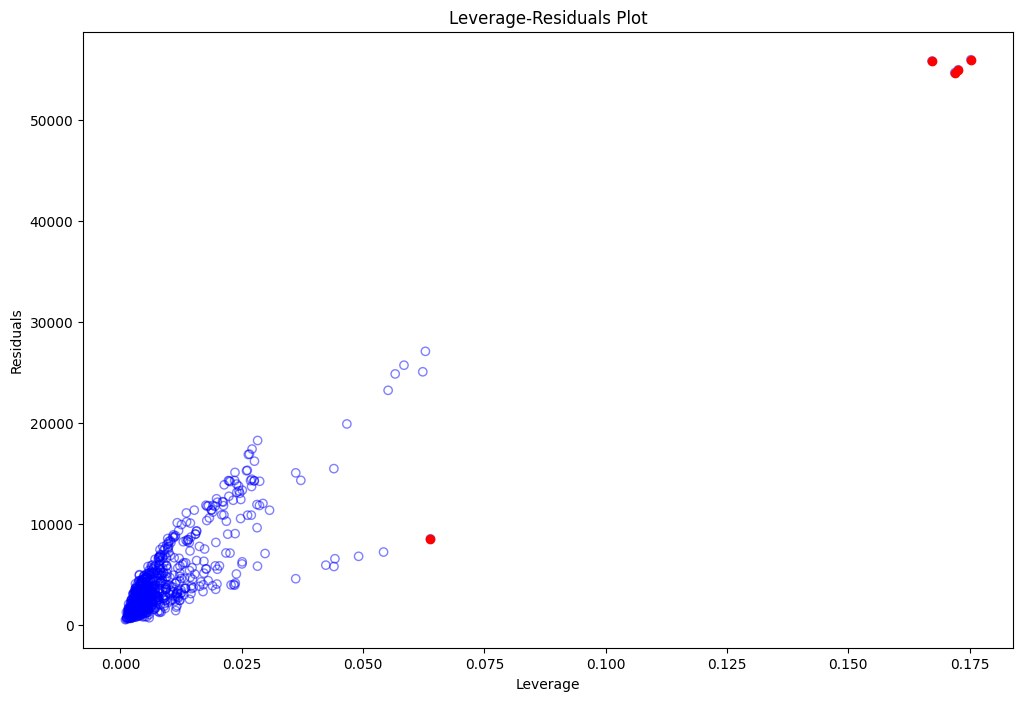

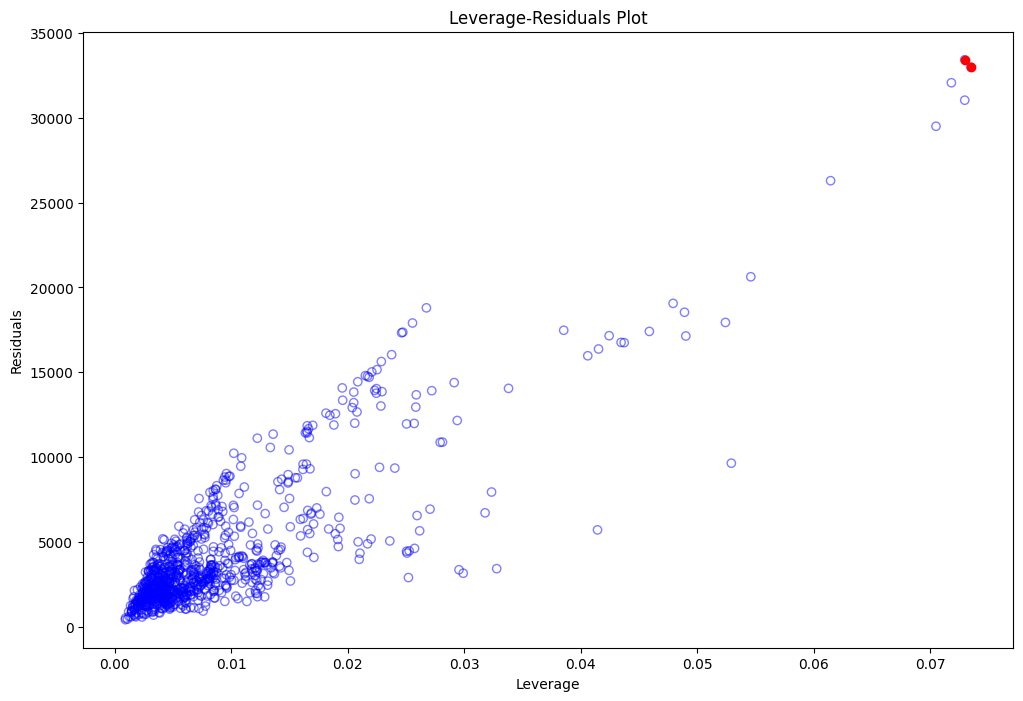

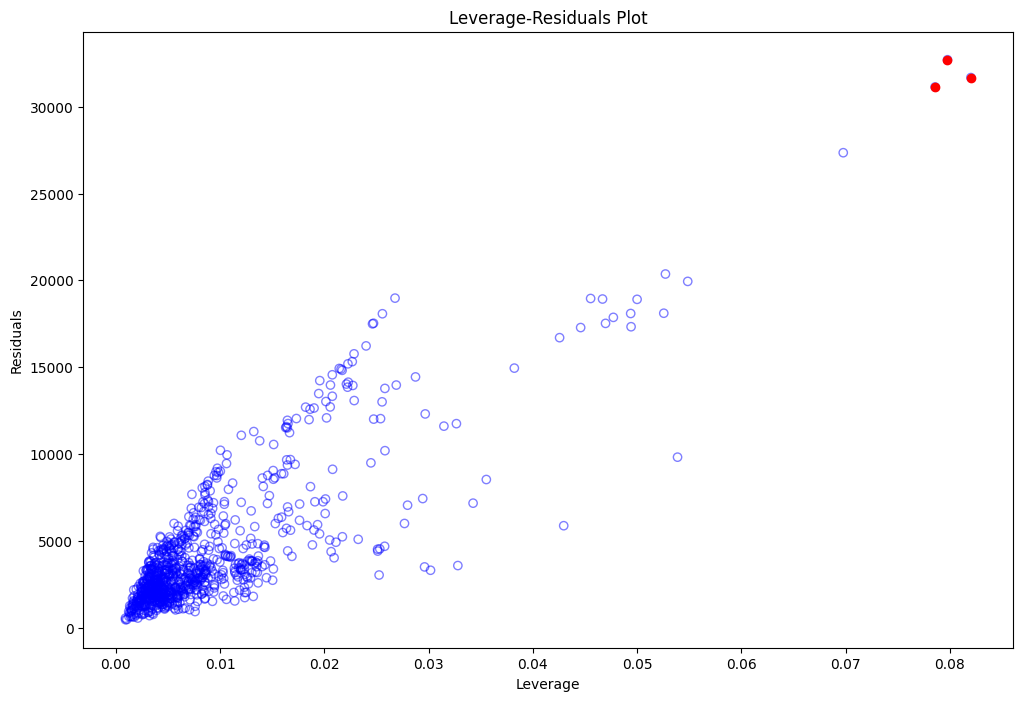

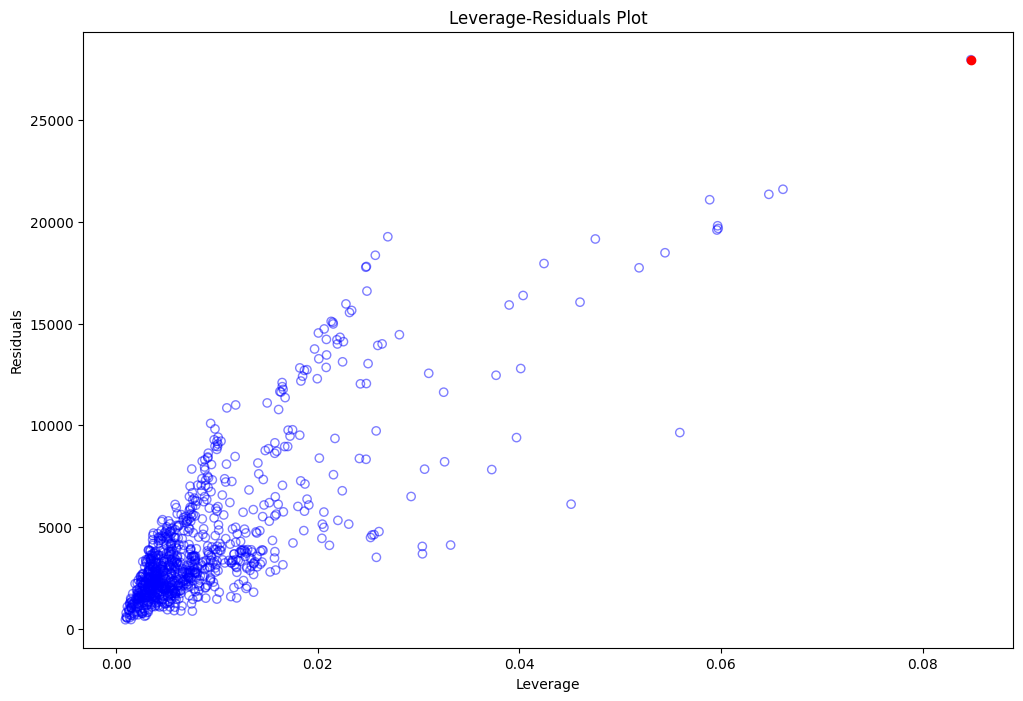

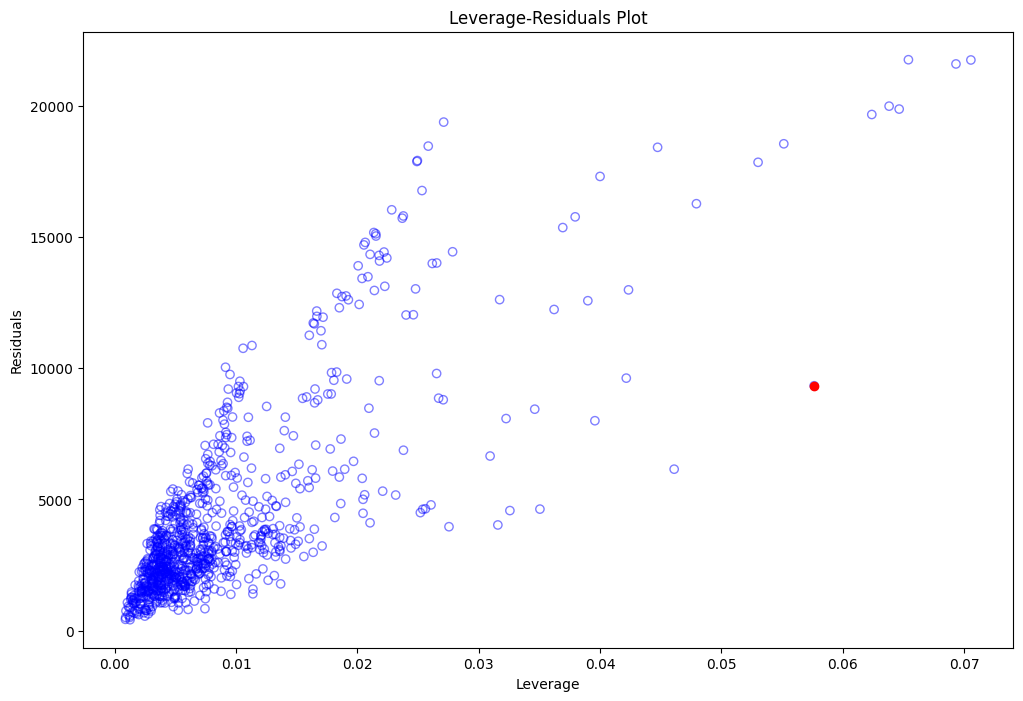

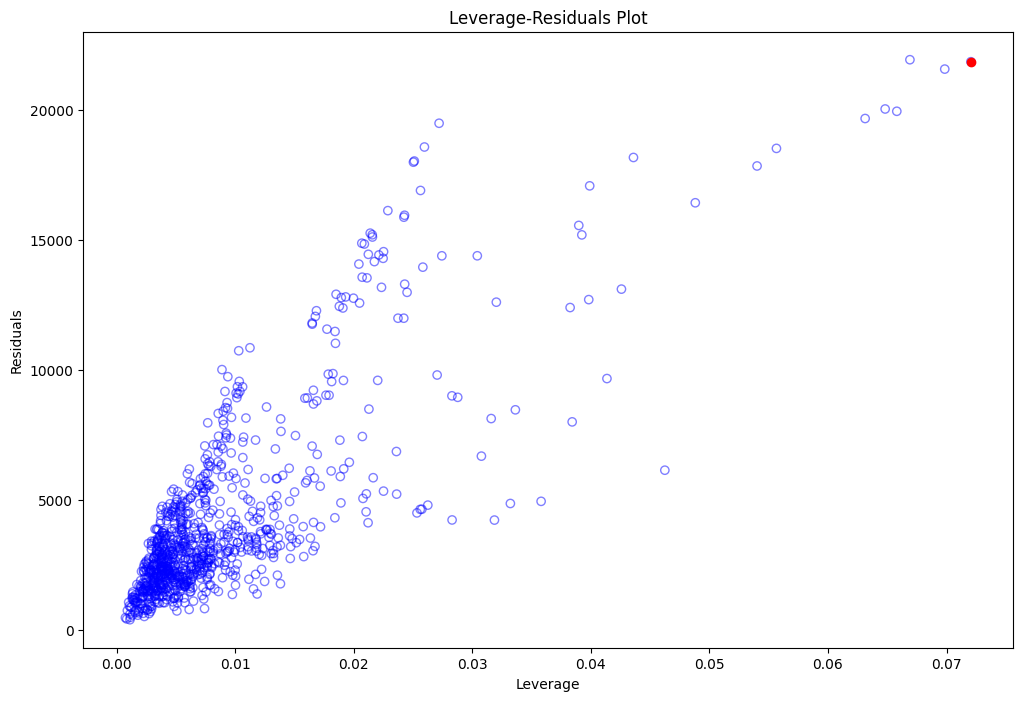

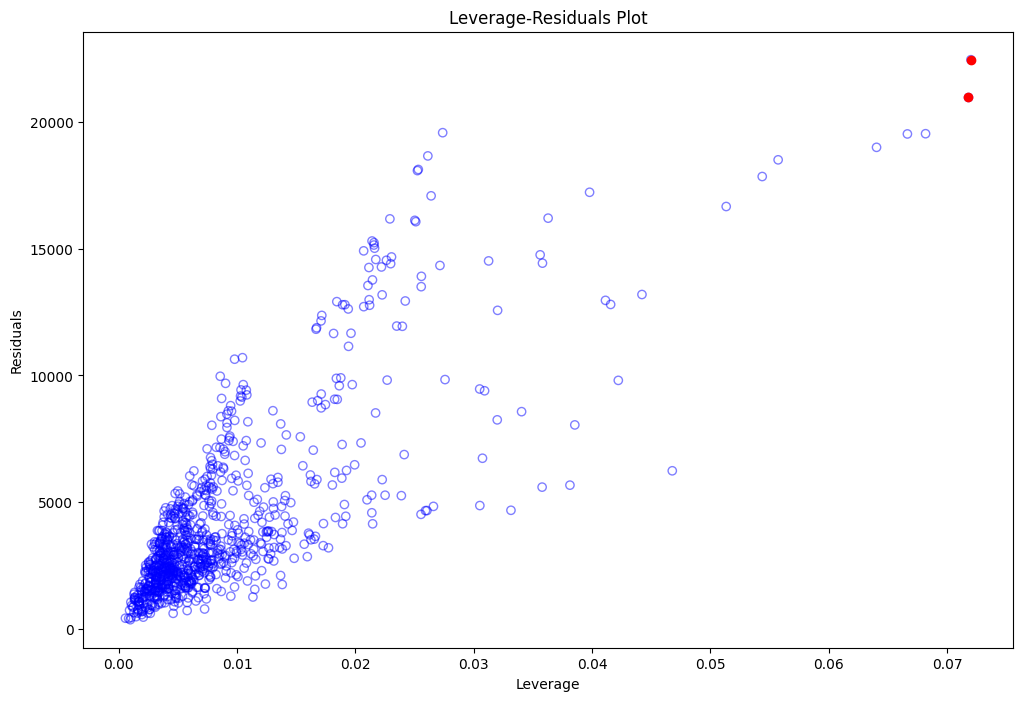

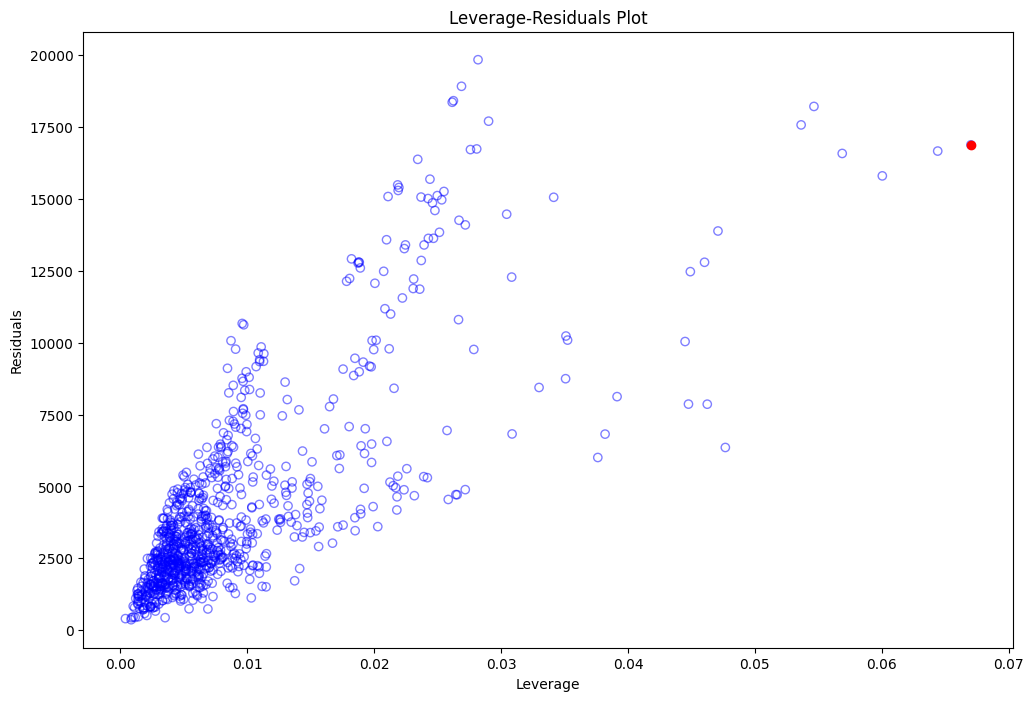

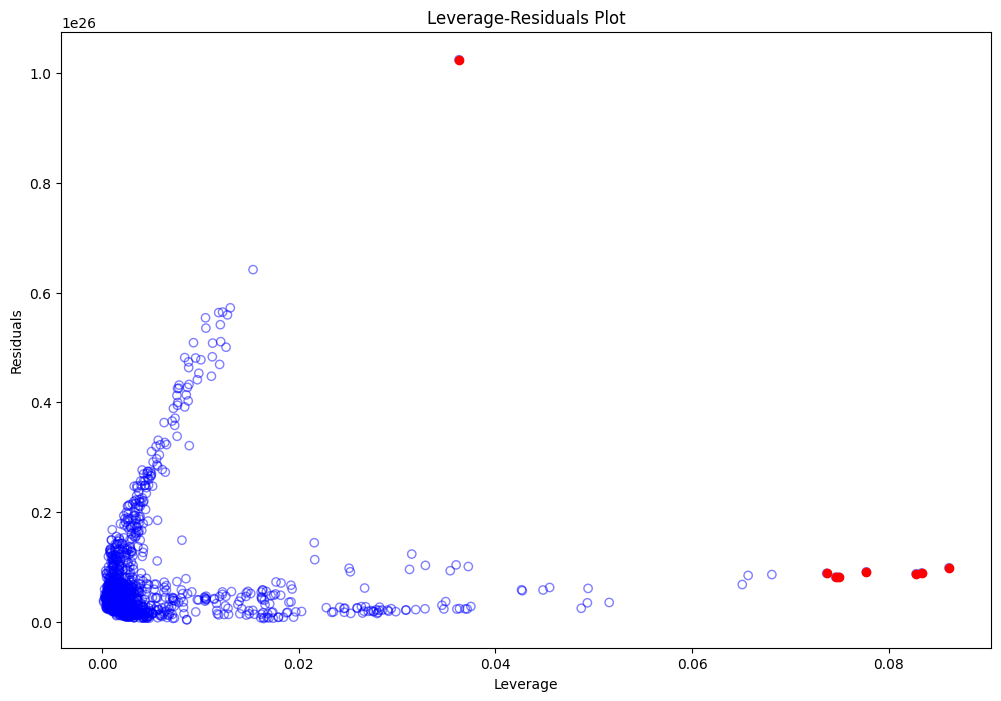

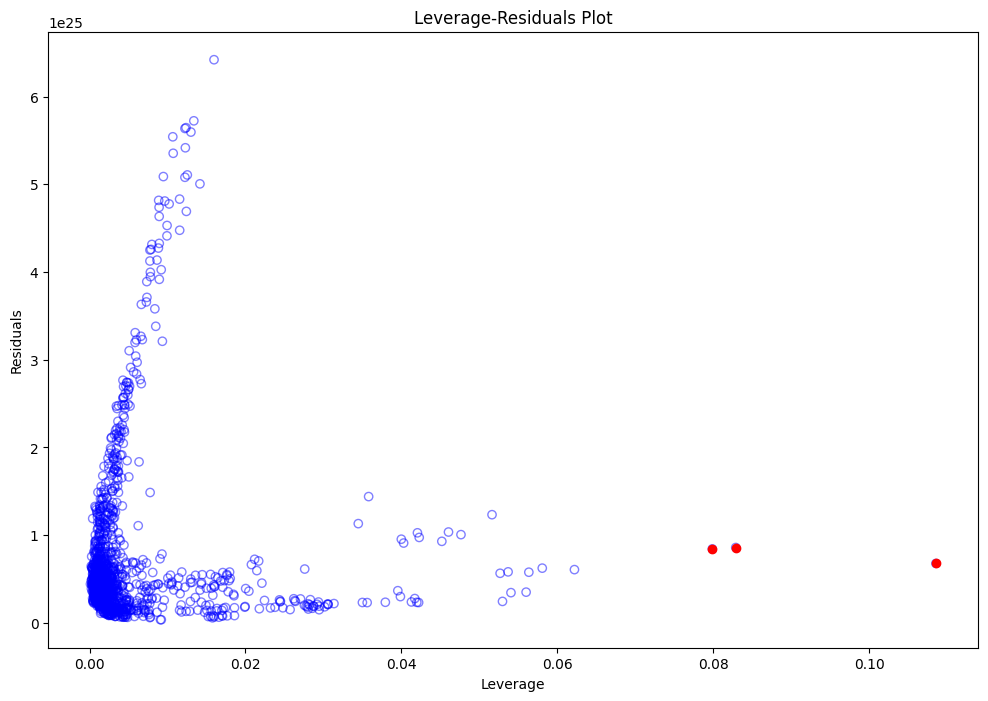

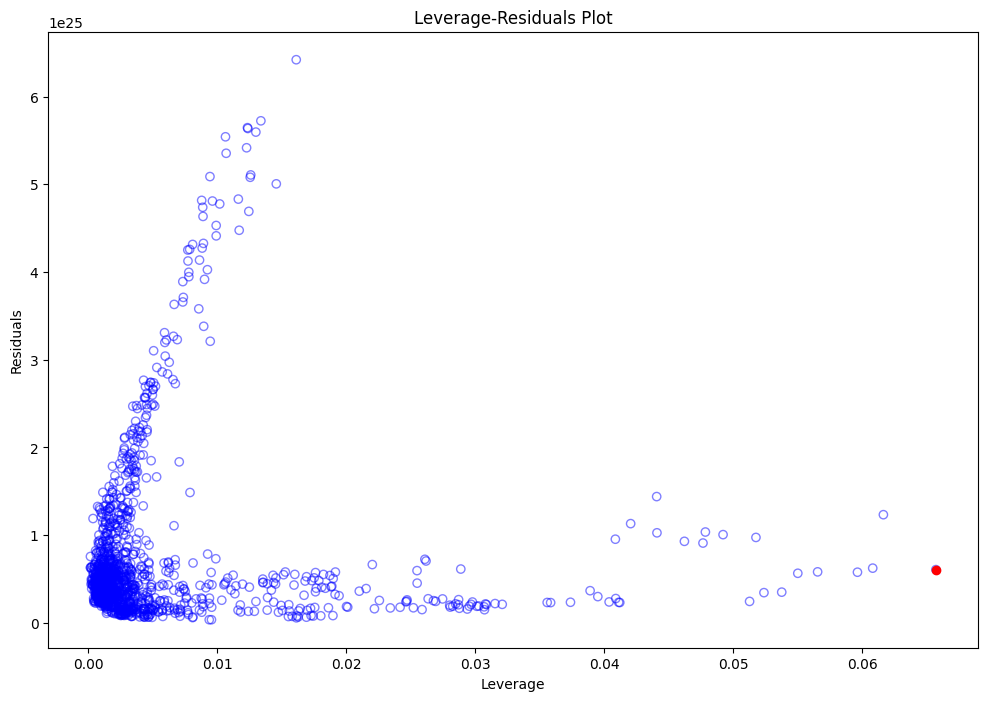

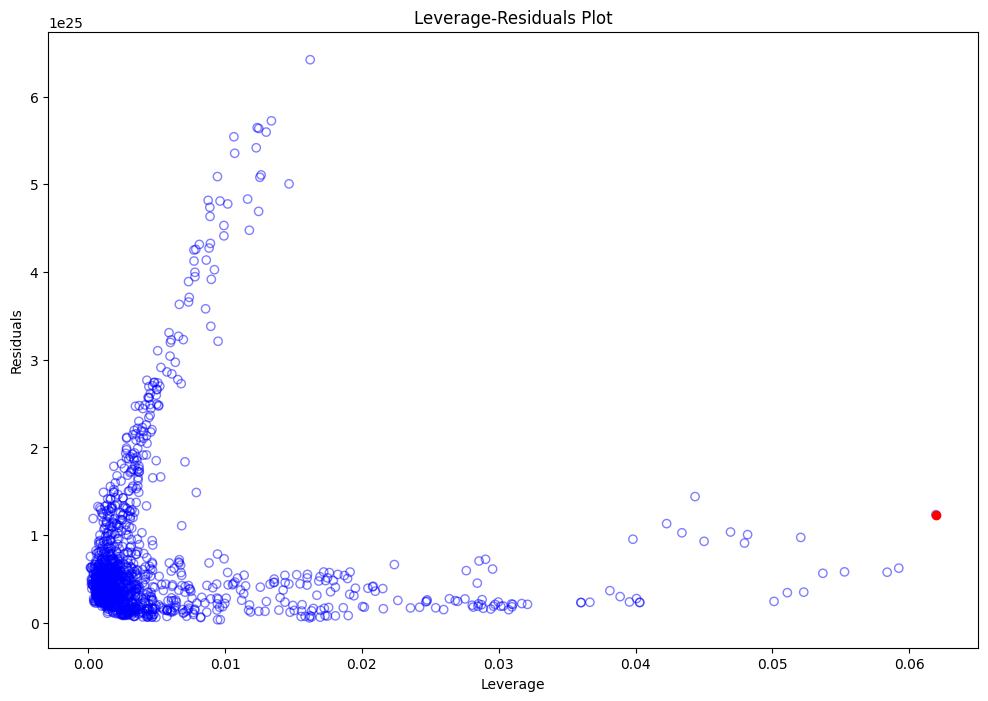

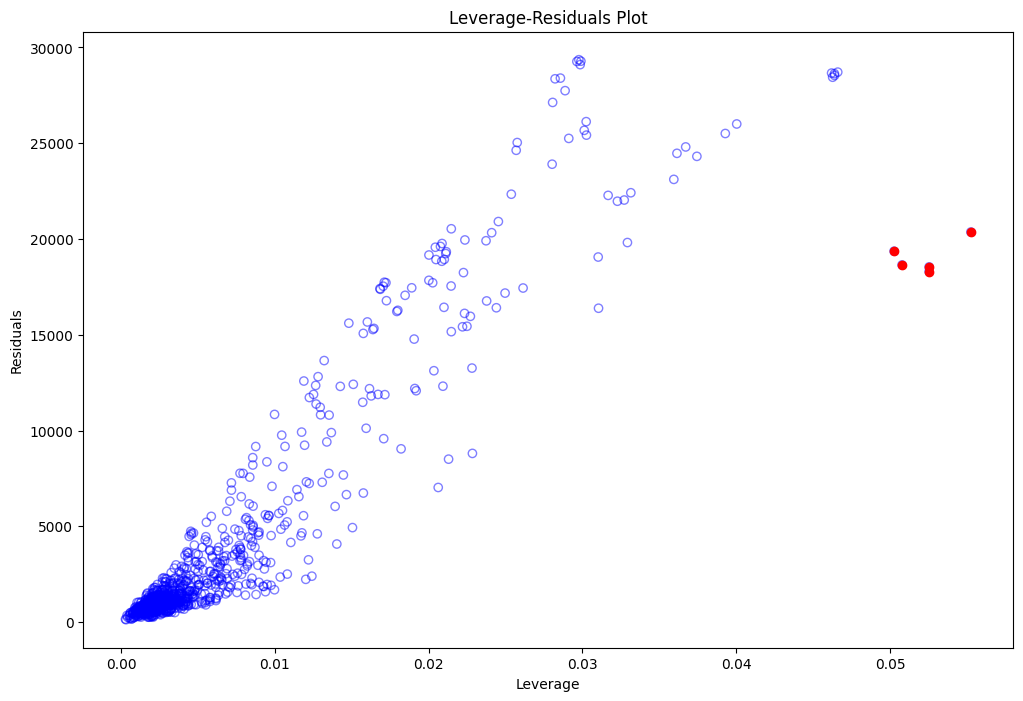

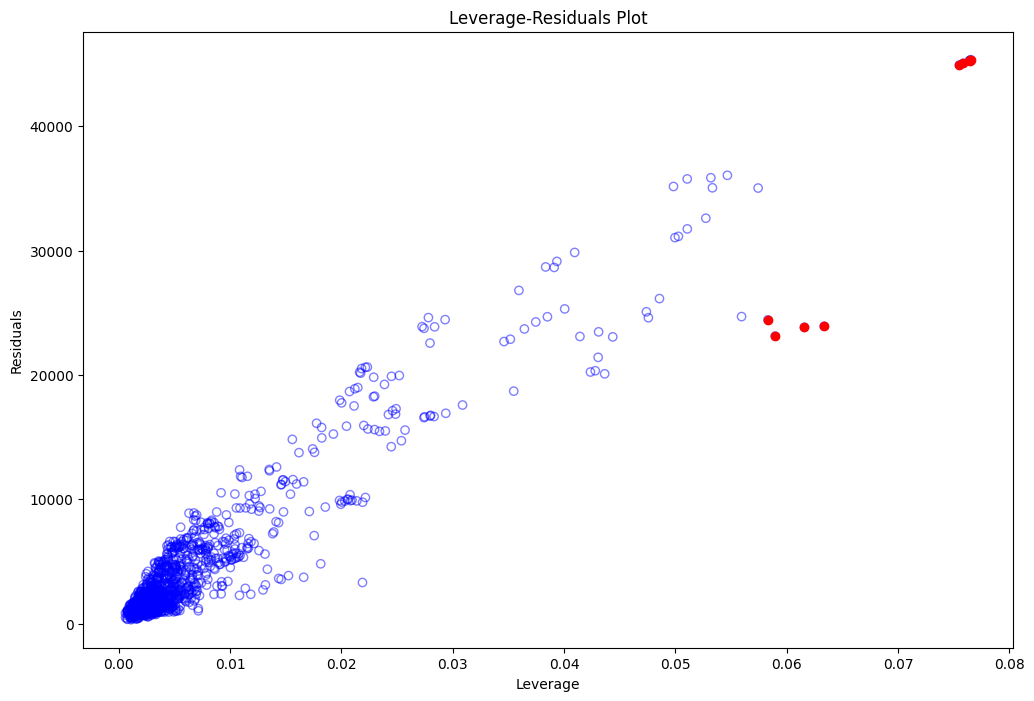

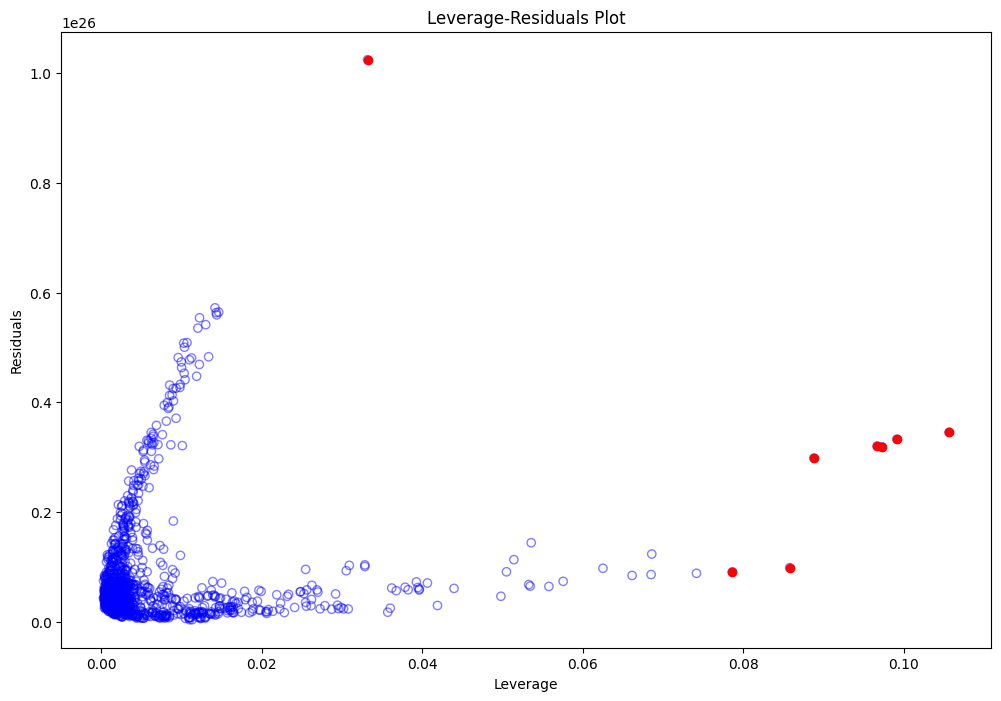

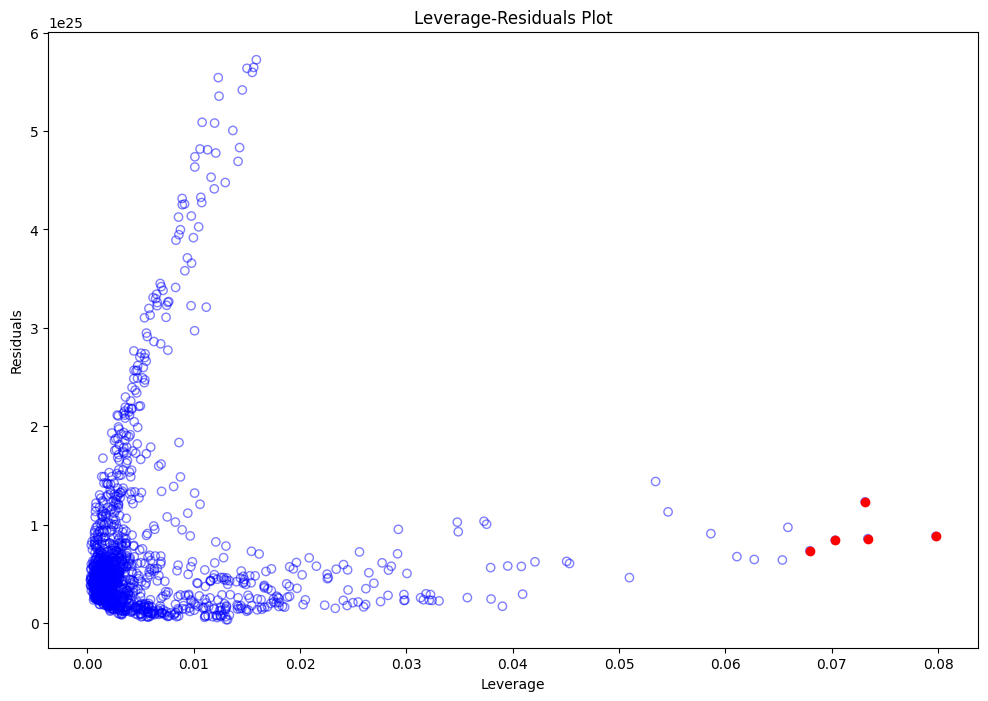

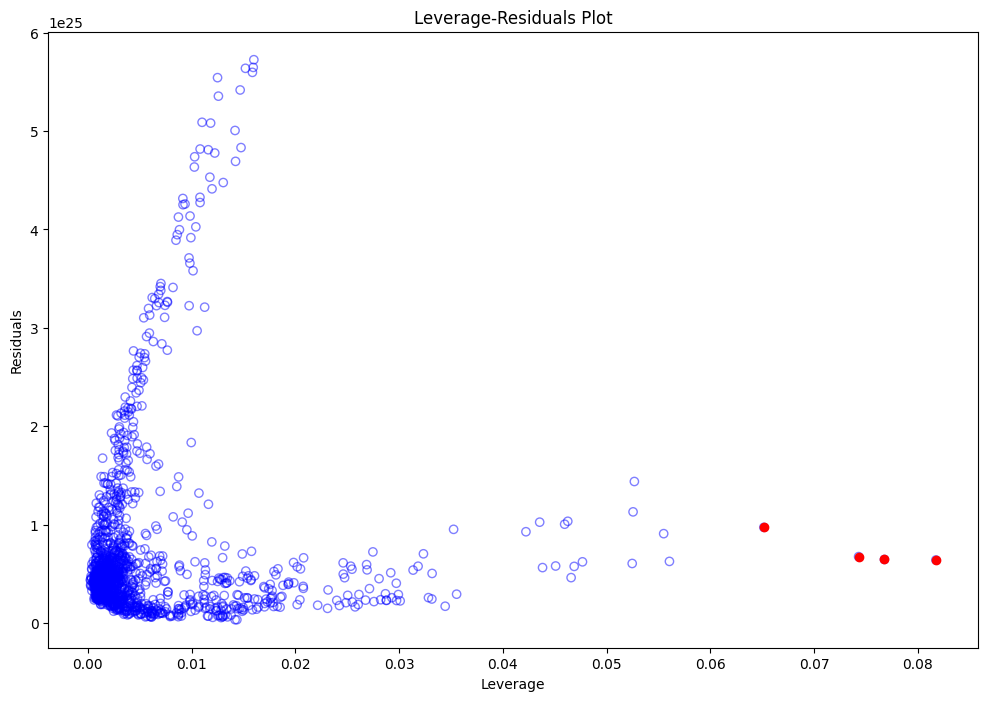

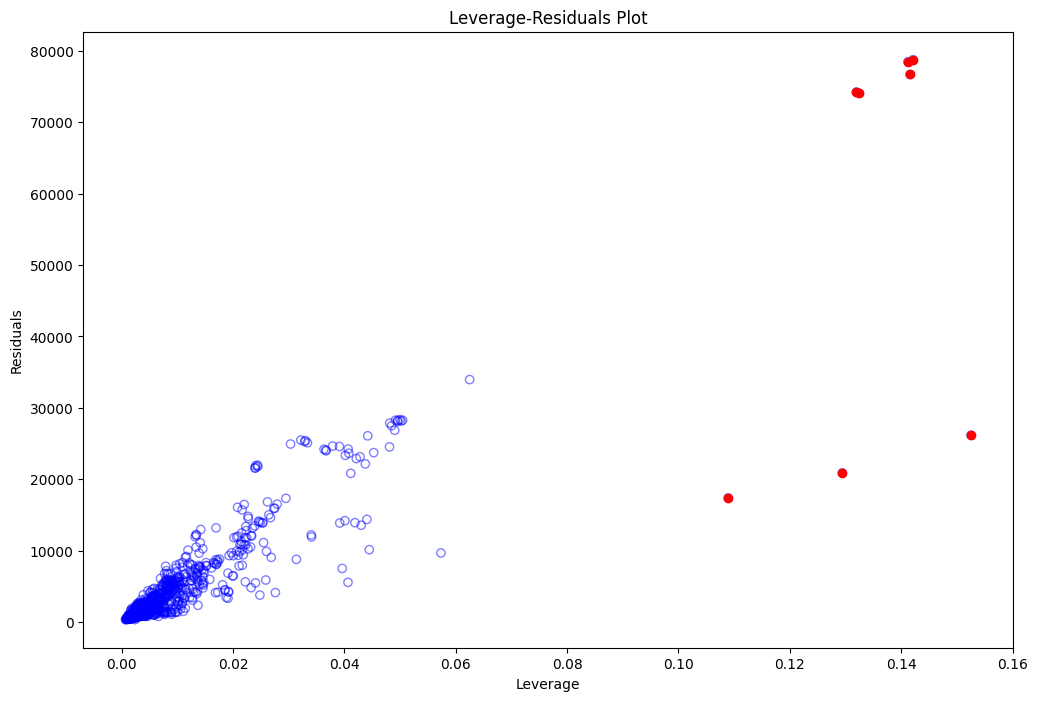

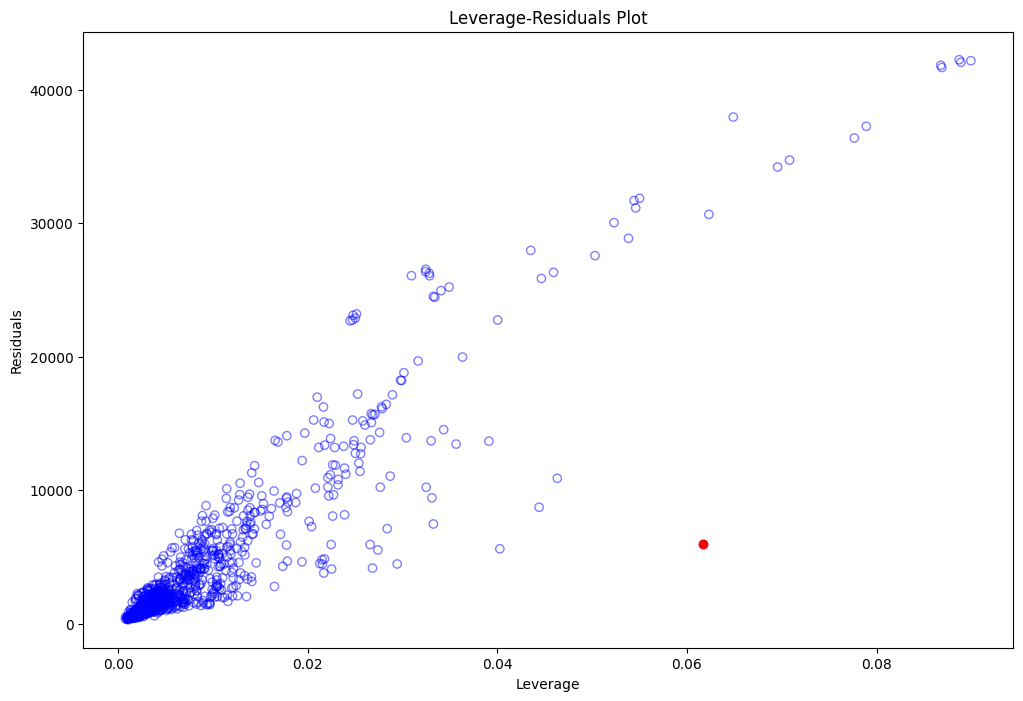

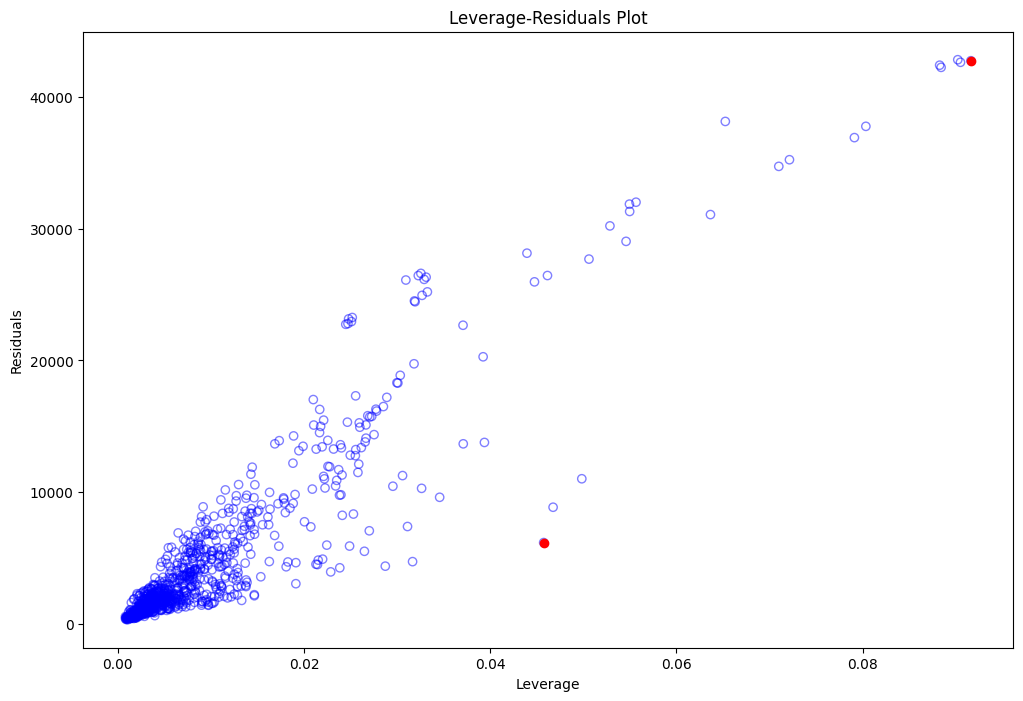

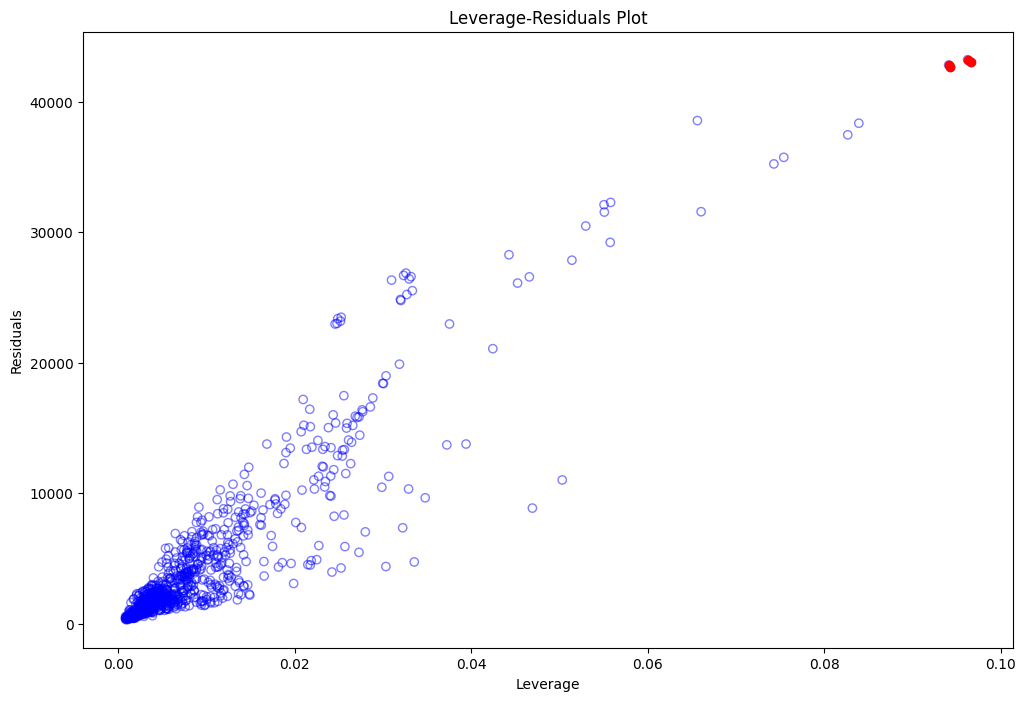

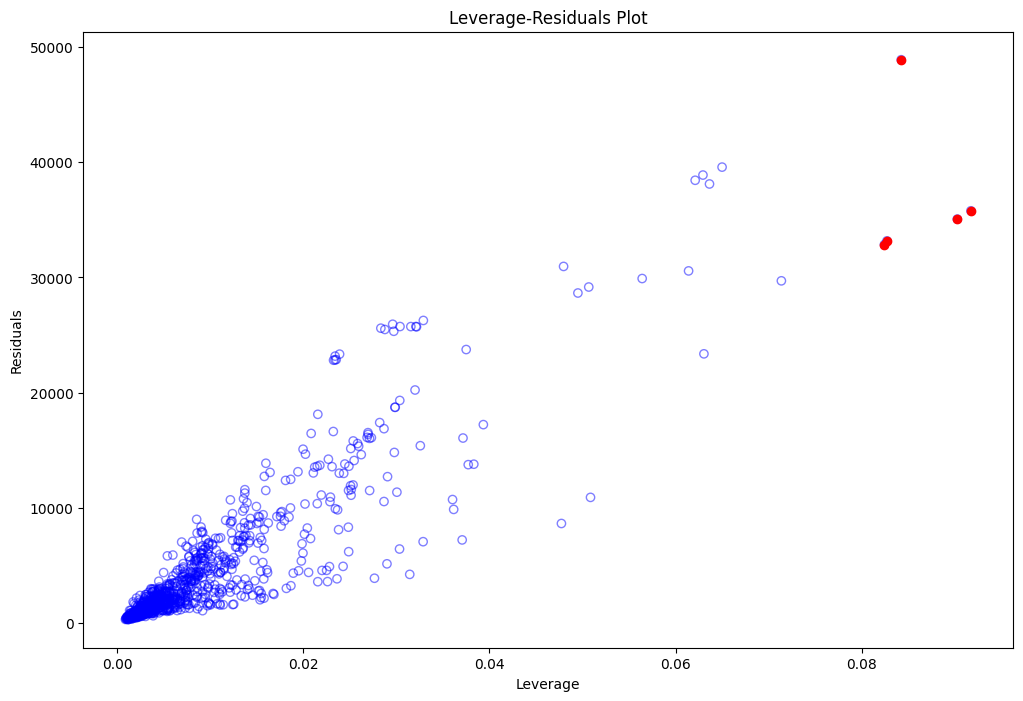

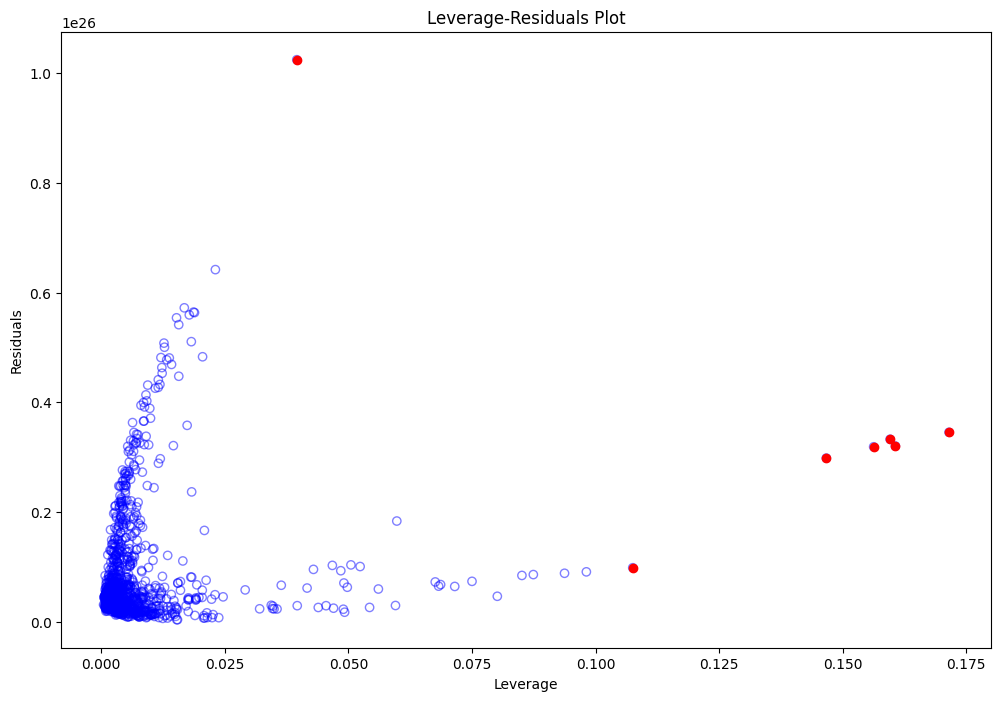

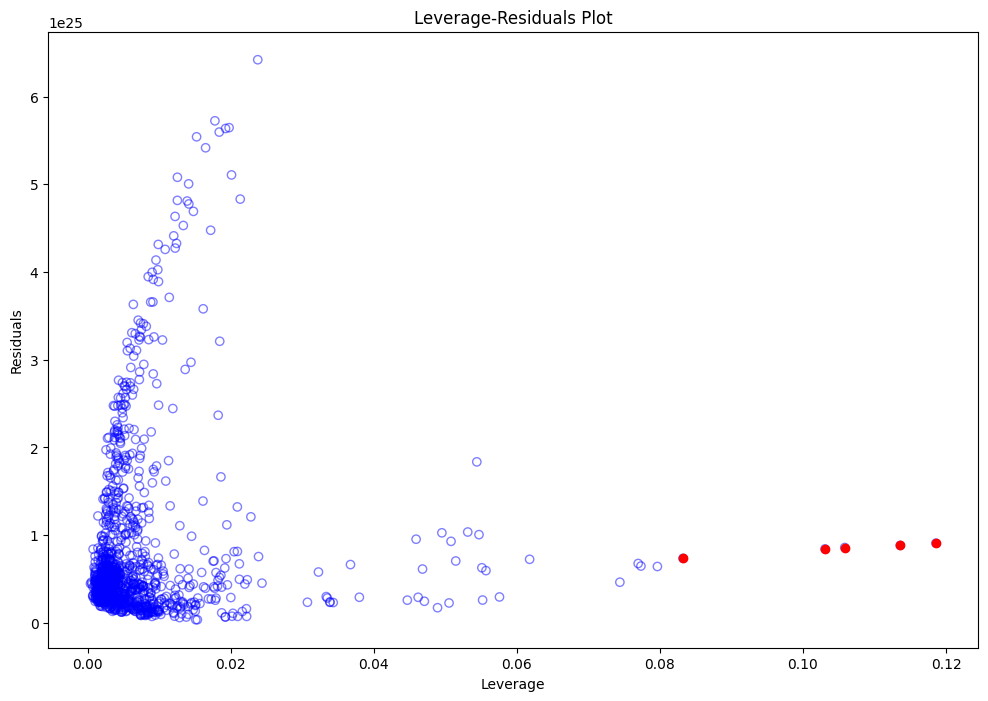

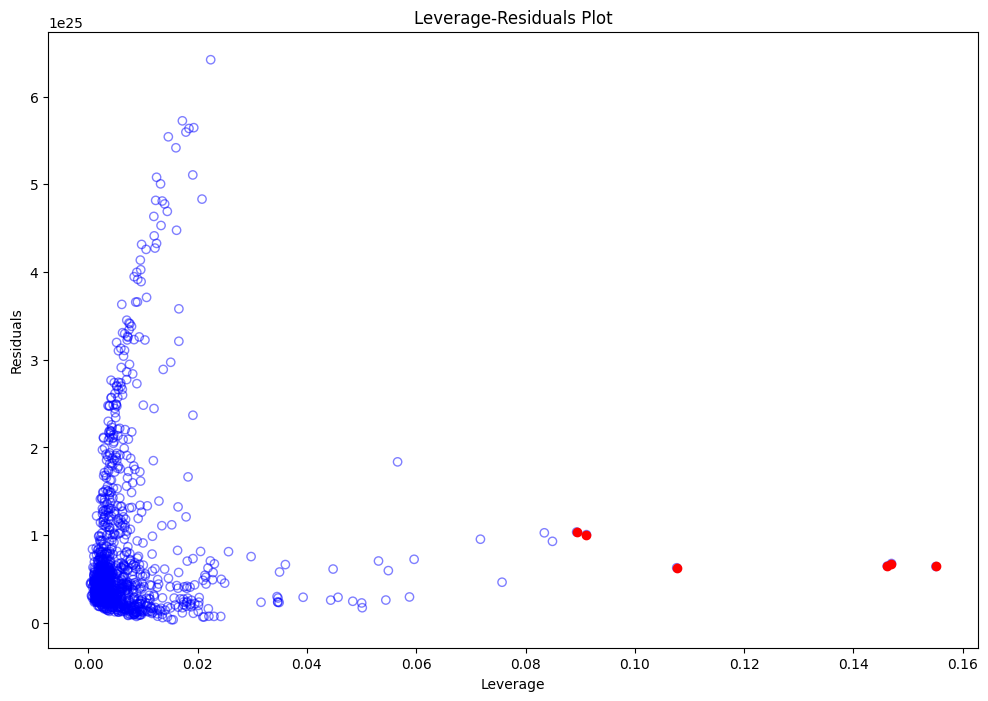

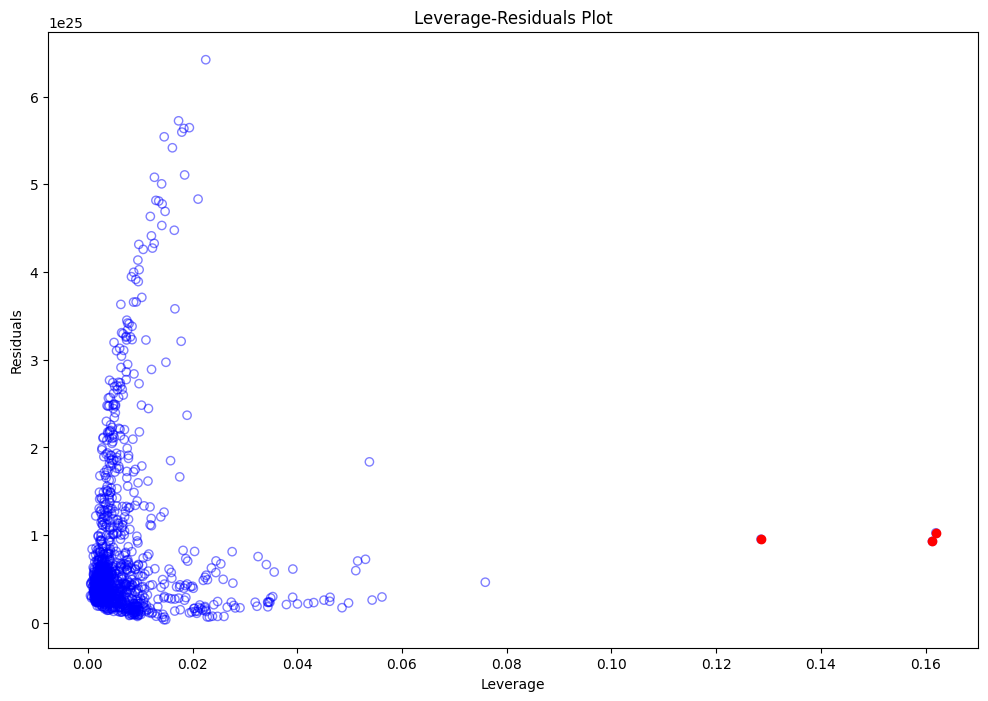

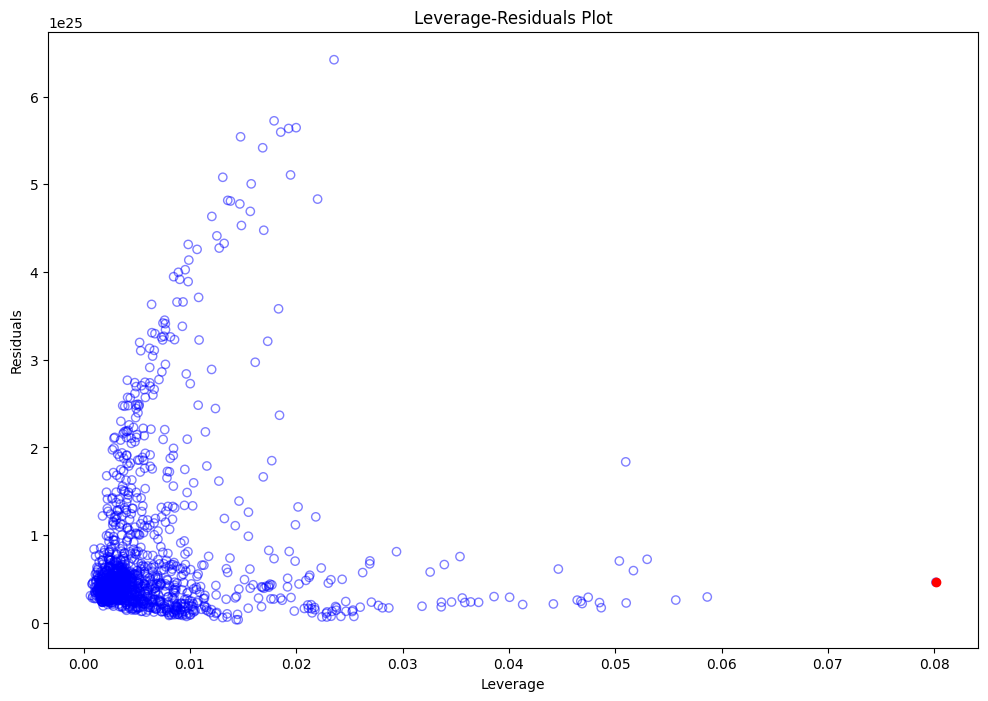

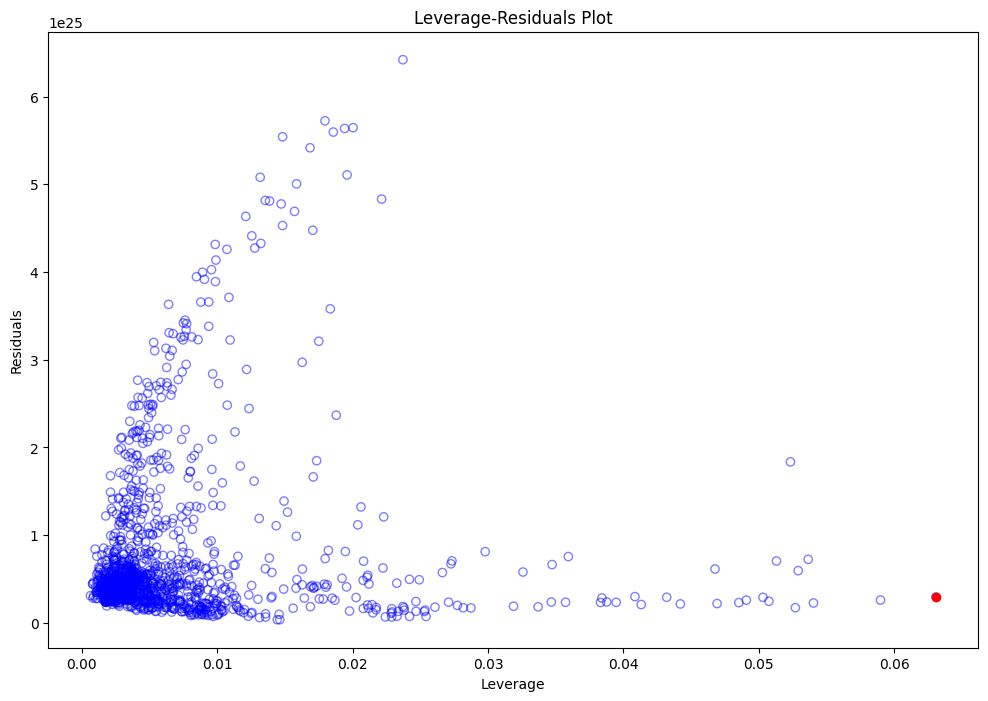

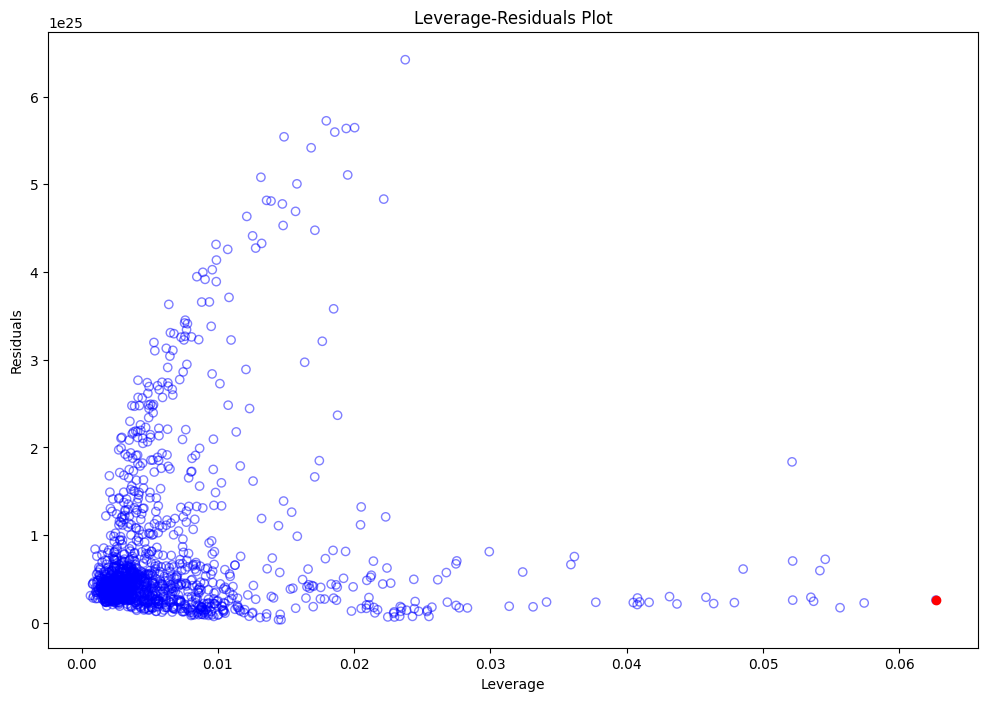

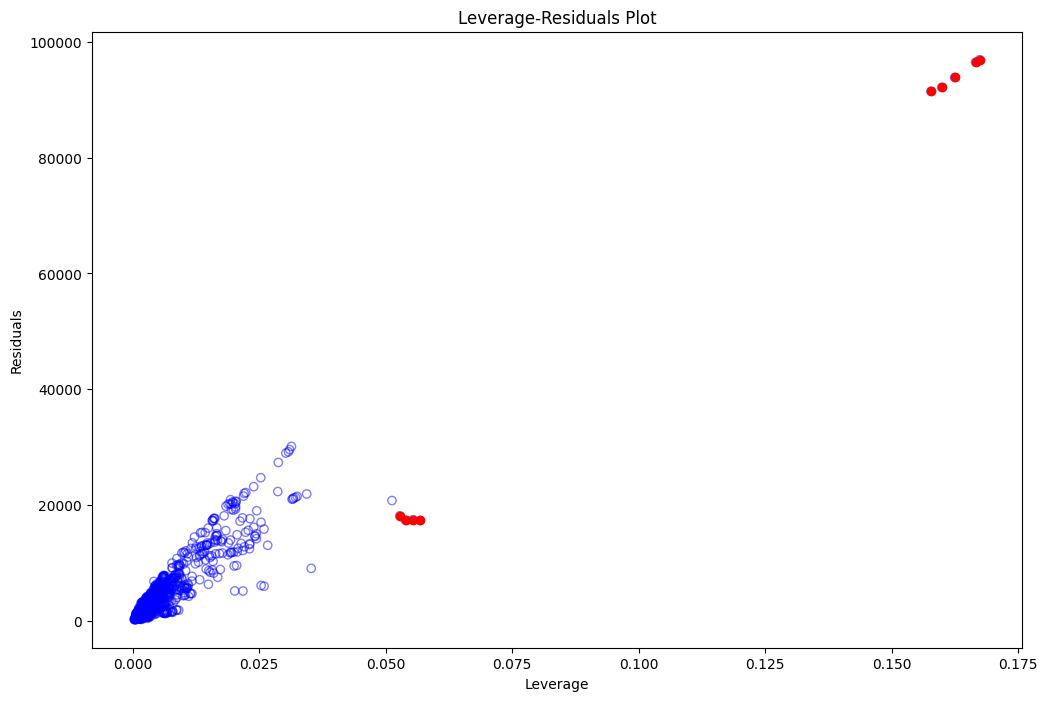

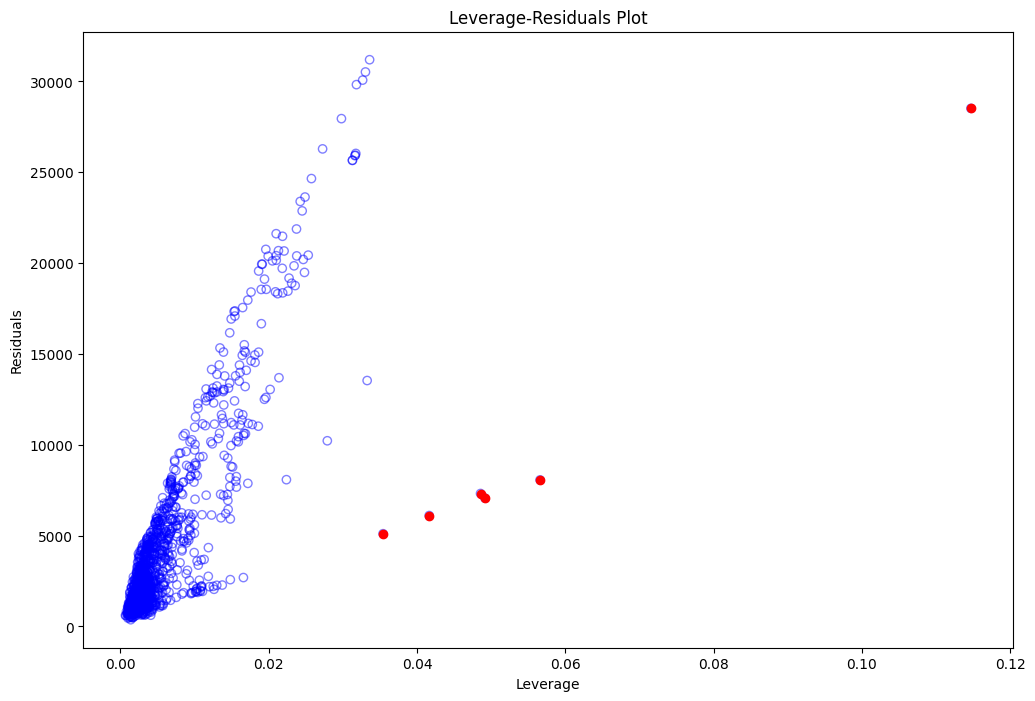

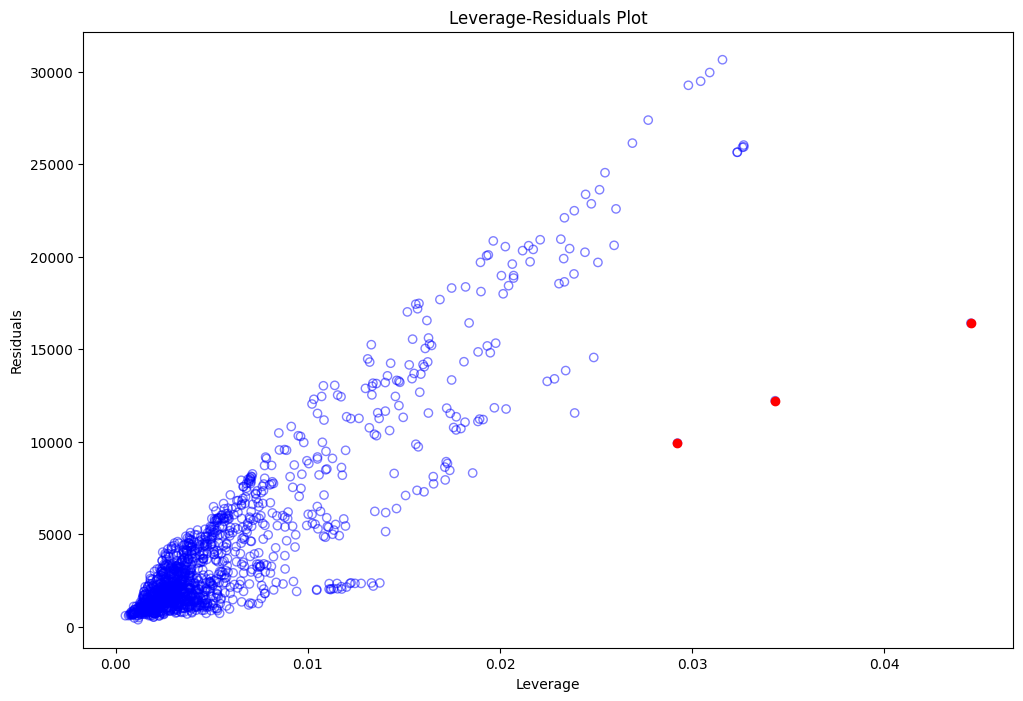

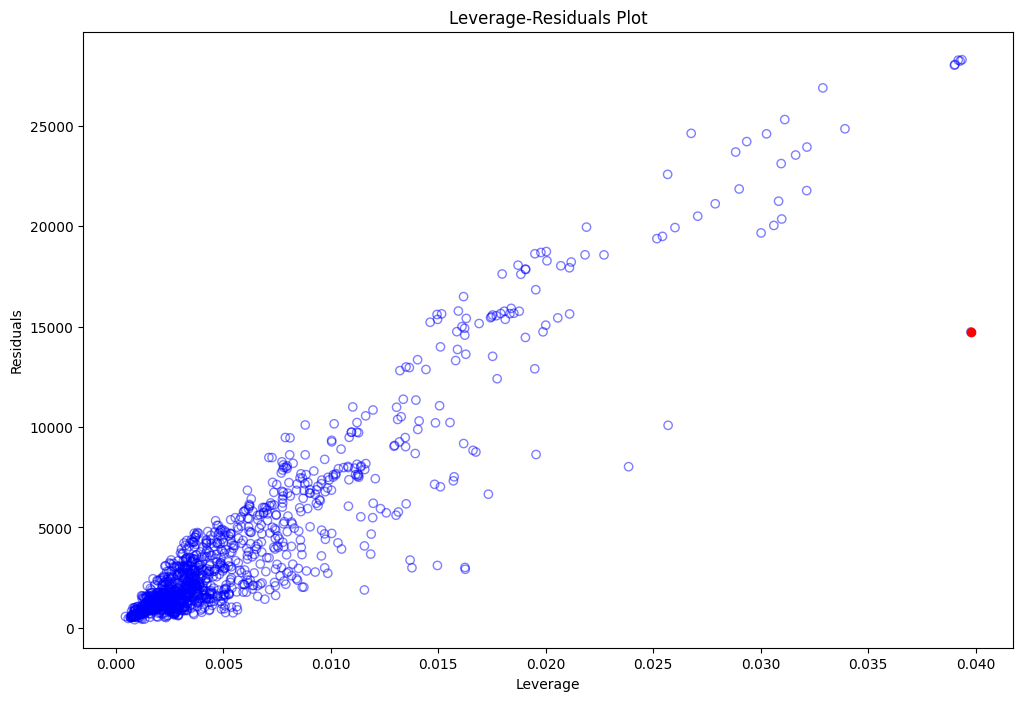

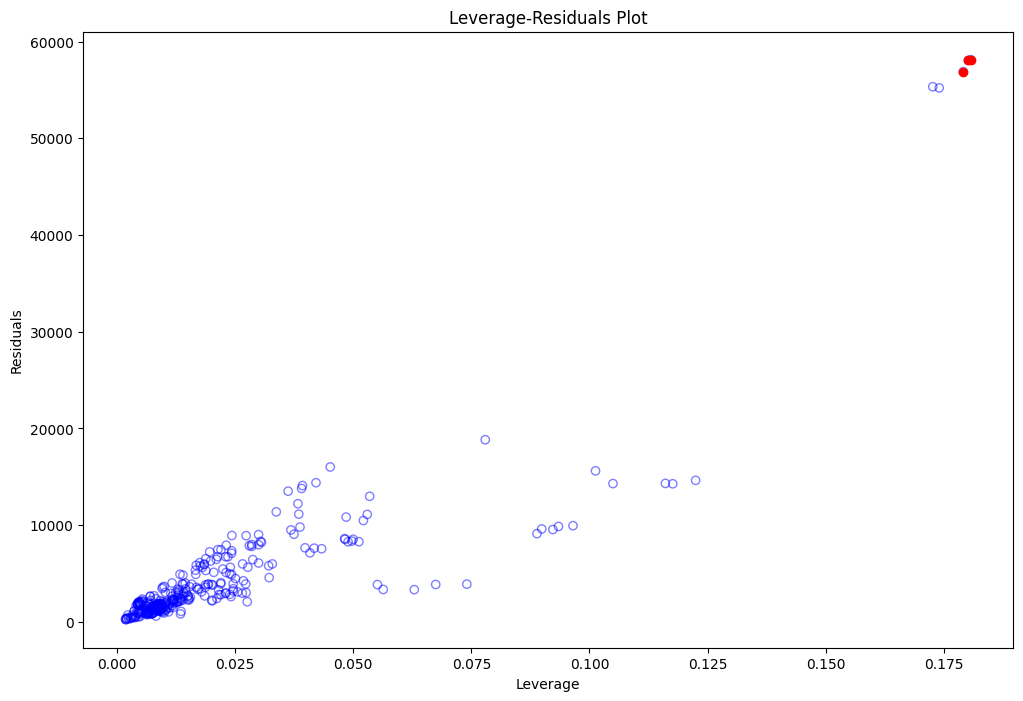

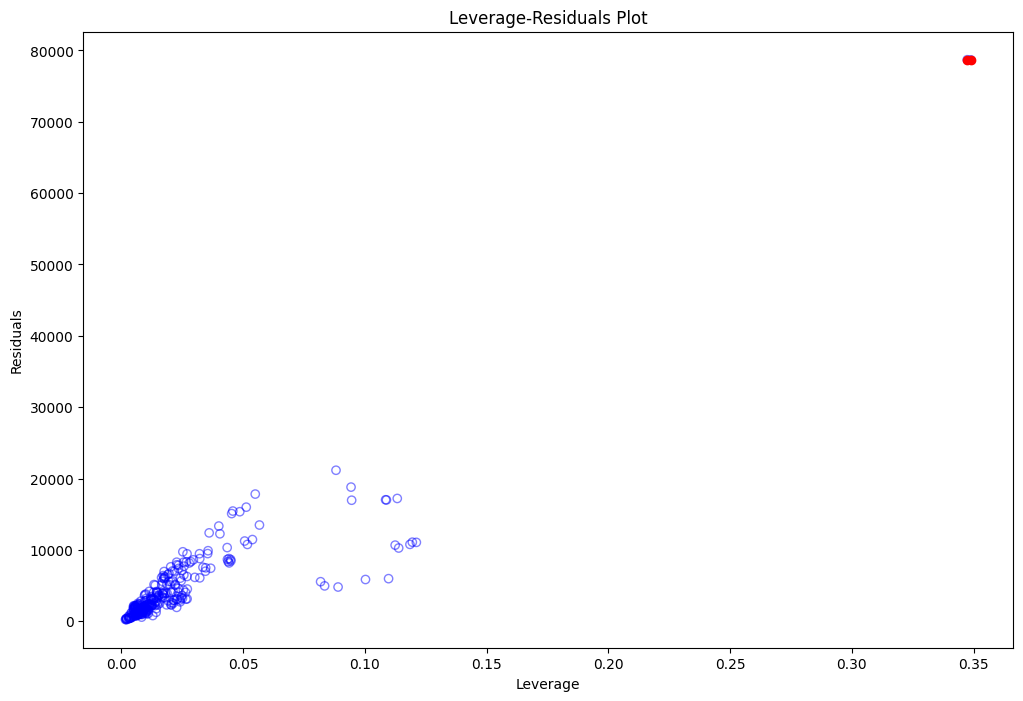

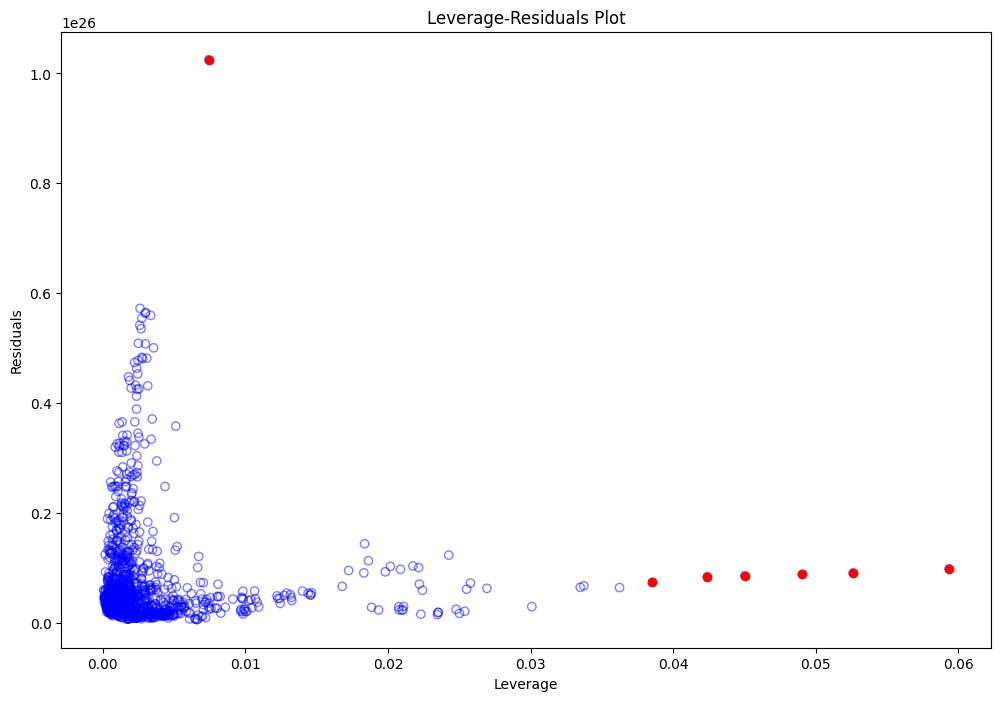

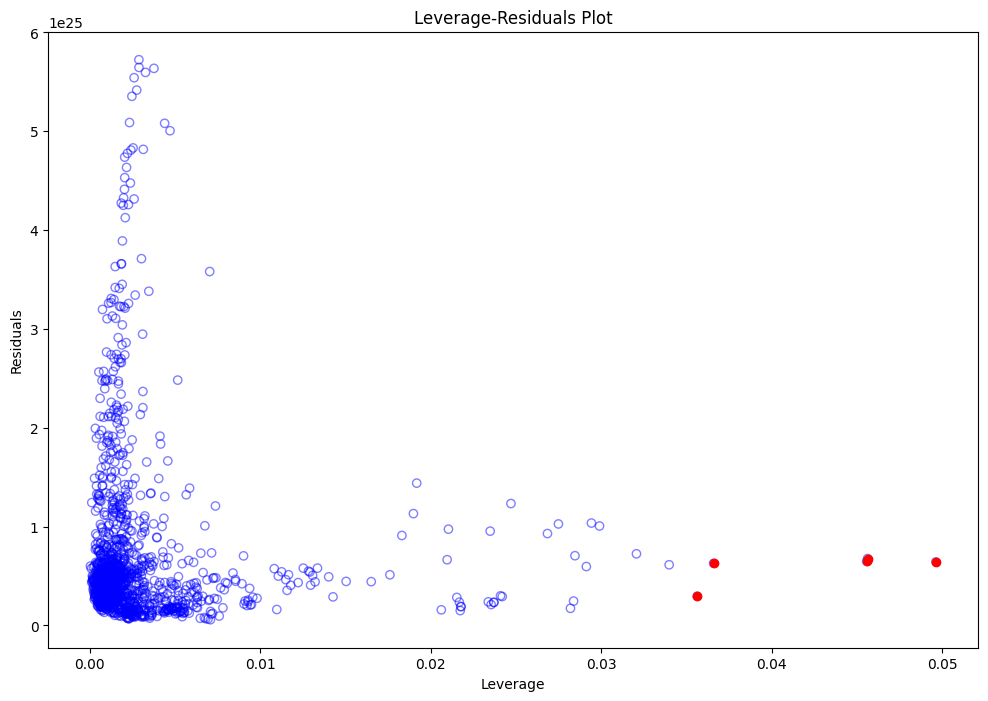

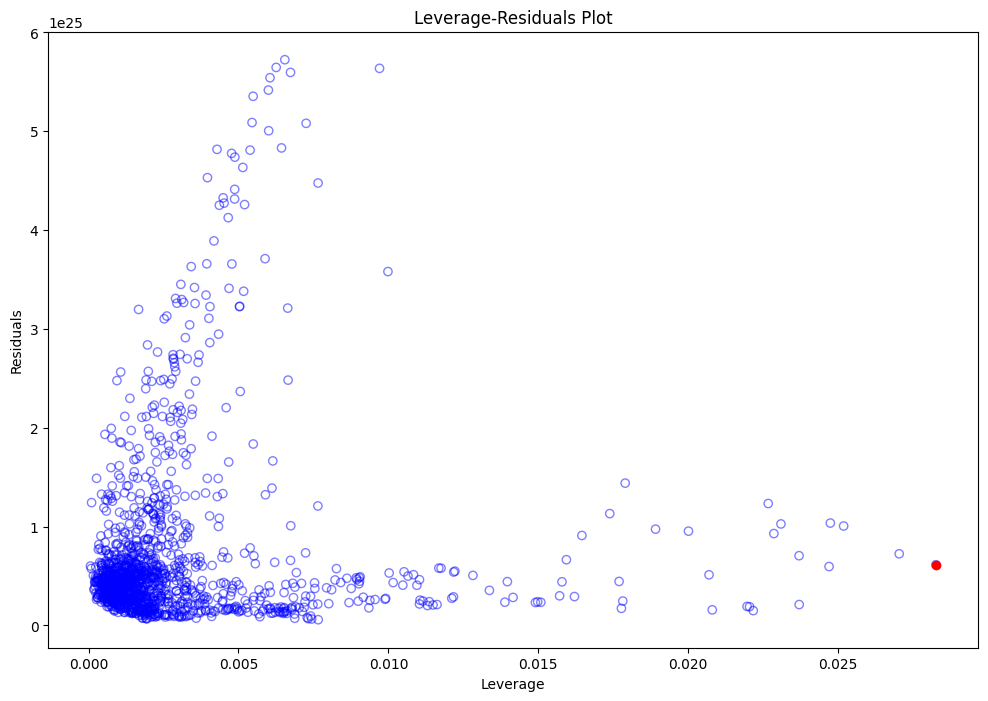

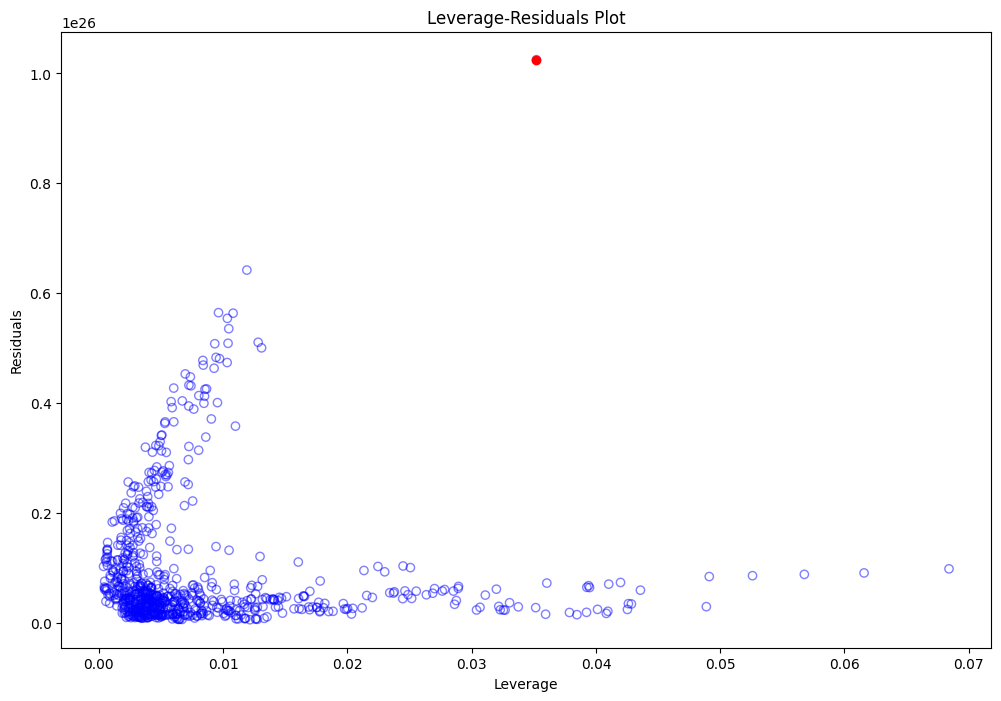

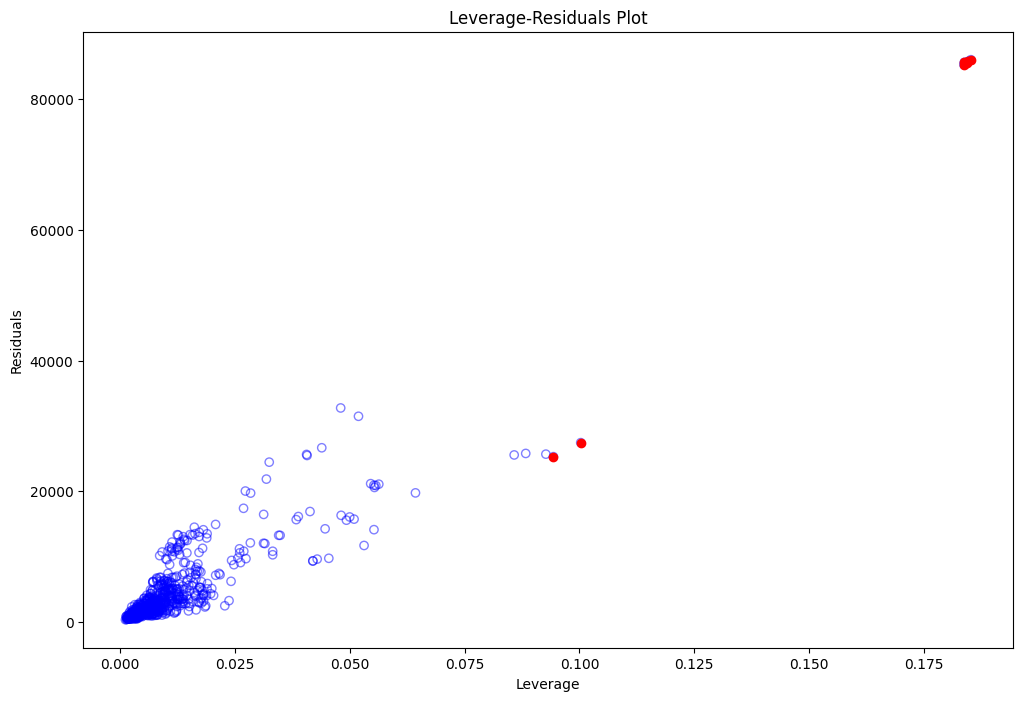

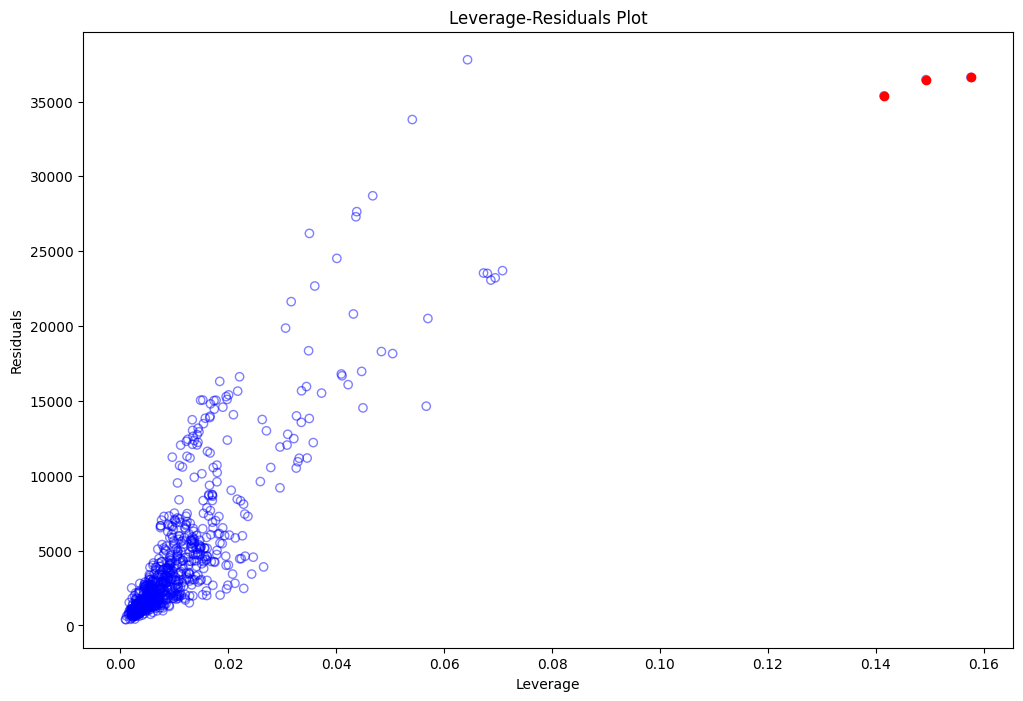

In [9]:
k_folds = 5
random_state = 42
influence_plot_dir = Path("plots/")

experiment_name = f"PLS_Models_{pd.Timestamp.now().strftime('%m-%d-%y_%H%M%S')}"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

for oxide in tqdm(major_oxides, desc="Processing oxides"):
    _oxide_ranges = oxide_ranges.get(oxide, None)
    if _oxide_ranges is None:
        logger.info("Skipping oxide: %s", oxide)
        continue

    for compositional_range in _oxide_ranges.keys():
        logger.debug(
            "Starting MLflow run for compositional range: %s, oxide: %s",
            compositional_range,
            oxide,
        )

        logger.info("Filtering data by compositional range.")
        data_filtered = filter_data_by_compositional_range(
            processed_data, compositional_range, oxide, oxide_ranges
        )

        # Separate 20% of the data for testing
        train, test = custom_train_test_split(
            data_filtered,
            group_by="Sample Name",
            test_size=0.2,
            random_state=random_state,
        )

        train_cols = train.columns
        test_cols = test.columns

        n_components = training_info[oxide][compositional_range]["n_components"]
        norm = training_info[oxide][compositional_range]["normalization"]
        scaler = (
            Norm1Scaler(reshaped=True)
            if norm == 1
            else Norm3Scaler(spectrometer_wavelength_ranges, reshaped=True)
        )
        logger.debug("Initializing scaler: %s", scaler.__class__.__name__)

        logger.debug("Fitting and transforming training data.")
        train = scaler.fit_transform(train)
        logger.debug("Transforming test data.")
        # TODO: Maybe only transform?
        test = scaler.fit_transform(test)

        # turn back into dataframe
        train = pd.DataFrame(train, columns=train_cols)
        test = pd.DataFrame(test, columns=test_cols)

        # run_cross_validation(
        #     oxide, compositional_range, n_components, random_state, k_folds, train
        # )

        run_outlier_removal(
            oxide,
            compositional_range,
            n_components,
            train,
            test,
            experiment_name,
            influence_plot_dir,
        )